## Campaign altitude




In [1]:
# imports from packages
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec # gridspec for nested subfigures
from matplotlib.lines import Line2D
from matplotlib_map_utils.core import north_arrow
import matplotlib.dates as mdates
from windrose import WindroseAxes
import glob
import os
import seaborn as sns
import numb_conc # functions relating to number concenctration calculations
import plots


In [2]:
# --- Global formatting/settings/variables

# formatting for only showing time on the x-axis for plots per flight
# Use by setting axs[1,0].xaxis.set_major_formatter(formatter) for each axis where only time should show
formatter = mdates.DateFormatter('%H:%M')

# --- Thresholds for in-cloud values
# ----- Water content threshold
# following the korolev 22 paper: "In the present study the thresholds for liquid water content and ice water content (IWC) 
# were set as LWC > 0.01 g m−3, IWC > 0.01 g m−3, respectively. The phase composition of clouds was identified based on the 
# assessment of the ice water fraction mu = IWC∕(LWC + IWC). Thus, clouds with mu=0.9 were considered as ice, 
# clouds with Mu =0.1 were defined as liquid, 
# and clouds 0.1 ≤ 𝜇𝜇 ≤ 0.9 were determined as mixed-phase clouds."
lwc_th = 0.01

# ----- Number concentration threshold
# Following table 2 from Evans et al 2025:
# Ice concentration threshold to define ice = 0.1 L-1 (or m-3) (NT100 is given in m-3)
# Cdp drop concentration to define liquid = 2 cm-3 (numb conc corrected is given in cm-3)

n_ice_th = 0.1
n_drp_th = 2

# --- Select preselect options

# ----- In cloud threshold method
# Options:
# - 'LWC_th' based on only LWC
# - 'TWC_th' based on only TWC
# - 'LWC_IWC_th' based on LWC and IWC
# - 'N_th' based on number concentration from both CDP and CIP
th_method = 'LWC_IWC_th'

# --- Preselection options

#preselect = False # whether or not to use any preselection (sea/above70 degrees, latitude bin selections)
preselect = True # whether or not to use any preselection (sea/above70 degrees, latitude bin selections)

preopt = ''
rm_cirrus = True # remove cirrus by only looking at
rm_c_T = -35
marine = True # only use marine values (values larger than given lat)
m_lat = 70
rm_precip = False # remove precip based on selection
rm_roll = True # only use values where Rol is less than 5
roll_th = 5


# set saving paths based on preselection options
if preselect == False:
    pre_text=''
    if rm_cirrus == True:
        preopt = preopt + f'rmCir{rm_c_T}_'
        pre_text = pre_text + f'Cirrus removed (>{rm_c_T}), '
    if marine == True:
        preopt = preopt + f'mar{m_lat}_'
        pre_text = pre_text + f'only marine (lat>70), '
    if rm_precip == True:
        preopt = preopt + f'rmPre{m_lat}_'
        pre_text = pre_text + f'Precip removed, '
    if rm_roll == True:
        preopt = preopt + f'rmRoll{roll_th}_'
        pre_text = pre_text + f'Roll removed, '
        
    save_path = '/home/ninalar/Documents/MC2/procIslasMicrophy-1/save_images/Pre_selection/' #+preopt 

else:
    #save_path = 'save_images/Alldata/'
    #save_path = 'save_images/EGU/'
    save_path = '/home/ninalar/Documents/MC2/procIslasMicrophy-1/save_images/sample_rate/'
    pre_text = 'no preselect'


print(pre_text)
extr_txt = ''
#extr_txt = '(allin_off)'

#colors for flights (for consistent coloring in plots)
c_flights = {'IS22-01':'wheat',
            'IS22-02':'tab:orange',
            'IS22-03':'tab:cyan',
            'IS22-04':'tab:purple',
            'IS22-05':'tab:pink',
            'IS22-06':'tab:brown',
            'IS22-07':'tab:red',
            'IS22-08':'tab:olive',
            'IS22-09':'tab:grey',
            'IS22-10':'tab:blue',
            'IS22-11':'tab:green'}

no preselect


In [3]:
# --- Data import
# Import the processed data:
#main_path = '/home/ninalar/Documents/MC2/Results_2022-islas/Processed/ISLAS_processed' # regular path
main_path = '/home/ninalar/Documents/MC2/Results_2022-islas/Processed/with_distance_from_ice' # path with sea ice distance
file_struct = '/microphy_5s_*.nc' # structure of cip text-file names

sic_path = '/home/ninalar/Documents/MC2/procIslasMicrophy/sea_ice_satellite/asi-n6250-'
sic_file_struct = '-5.4_regridded.nc'


# get all the .nc files in the main path
files = glob.glob(os.path.join(main_path, file_struct))
files = glob.glob(main_path+file_struct)

# Exclude the file containing 'IS22-09' (flew over land)
files_to_exclude = [f for f in files if 'IS22-09' in os.path.basename(f)]
files_to_include = [f for f in files if f not in files_to_exclude]

ds = xr.open_mfdataset(files_to_include, combine='by_coords', combine_attrs='drop_conflicts') # drop the IS22-09 flight


#get full extent of the dataset:
full_extent = [ds.lon.values.min()-5, ds.lon.values.max()+1, ds.lat.values.min()-3, ds.lat.values.max()+3]

# sea ice information from satellite
min_date = '20220322'
#min_date = '20220324'
#min_date = '20220326'
#min_date = '20220329'
#min_date = '20220330'
#min_date = '20220331'
max_date = '20220403'
sic_max_ds = xr.open_dataset(sic_path  + max_date + sic_file_struct)
sic_max_ds.close()
sic_min_ds = xr.open_dataset(sic_path  + min_date + sic_file_struct)
sic_min_ds.close()

# rename data variable and update attributes
sic_max_ds['sic'] = sic_max_ds['__xarray_dataarray_variable__'].assign_attrs(units="Percent", description="Sea Ice Concentration")
sic_max_ds = sic_max_ds.drop_vars(['__xarray_dataarray_variable__'])
sic_min_ds['sic'] = sic_min_ds['__xarray_dataarray_variable__'].assign_attrs(units="Percent", description="Sea Ice Concentration")
sic_min_ds = sic_min_ds.drop_vars(['__xarray_dataarray_variable__'])

# add some attributes
sic_max_ds.attrs['date'] = max_date
sic_max_ds.attrs['file'] = f'asi-n6250-{min_date}-5.4_regridded.nc'
sic_min_ds.attrs['date'] = min_date
sic_min_ds.attrs['file'] = f'asi-n6250-{min_date}-5.4_regridded.nc'


In [4]:
# calculate potential temperature and equivalent potential temperature
# get temperature in kelvin and pressure in mbar
ds['T_k']=ds['T']+274.15
ds['T'].attrs['units']='degree_Celsius'
ds['DP1'].attrs['units']='degree_Celsius'

def pot_temp(temp, pressure):
    press_ratio = 1000/pressure
    kappa = 0.286
    ratio = press_ratio**kappa
    pot_temp = temp*ratio

    return pot_temp

ds['theta']= pot_temp(ds['T'], ds['P'])


In [5]:
#---- Select incloud, relevant values

# commenting out all other masks for the EGU version

# Masks for different types of selections 
#lwc_mask = (ds['LWC calc']>=lwc_th).compute() # mask the values based on lwc according to threshold
#twc_mask = (ds['TWC']>=lwc_th).compute() # mask the values based on twc according to threshold
lwc_iwc_mask = ((ds['LWC calc']>= lwc_th)|(ds['IWC100']>= lwc_th)).compute() # mask the values based on lwc or iwc according to threshold
#nt_mask = ((ds['Number Conc calc']>= n_drp_th)|(ds['NT100']>= n_ice_th)).compute() # using calc instead of corr


# --- First selection: all data or only lower clouds/relevant data, only marine data
if preselect == True:
    # select only marine values (lat higher than 70)
    if marine == True:
        marinelat_mask = (ds['lat']>=m_lat).compute()
        ds_relevant = ds.where(marinelat_mask, drop = True)

    if rm_cirrus == True:
        # select only values where temperature is higher than selected temperature (avoid cirrus)
        cirrusT_mask = (ds['T']>=rm_c_T).compute()
        ds_relevant = ds_relevant.where(cirrusT_mask, drop = True)

    if rm_roll == True:
        # select only values where roll is less than selected threshold
        roll_mask = (ds['ROLL']<=roll_th).compute()
        ds_relevant = ds_relevant.where(roll_mask, drop=True)

    
else:
    ds_relevant = ds

# ---- Second selection: what should be considered in-cloud?
# th_method is used to selecting the selection criteria and is added to saved plots for organizing
if th_method == 'LWC_th':
    # only lwc have to be larger than threshold, use lwc mask
    incloud_mask = lwc_mask
    th = f'{lwc_th} m^-3, (LWC)'
elif th_method == 'TWC_th':
    # twc have to be larger than threshold value, use twc mask
    incloud_mask = twc_mask
    th = f'{lwc_th} m^-3, (TWC)'
elif th_method == 'LWC_IWC_th':
    # either lwc or iwc needs to be larger than the threshold, use lwc_iwc_mask
    incloud_mask = lwc_iwc_mask
    th = f'{lwc_th} m^-3, (LWC or IWC)'
elif th_method == 'N_th':
    incloud_mask = nt_mask
    th = f'Nt_cdp>{n_drp_th} cm^-3, Nt_cip100>{n_ice_th} L^-1'
else:
    print('WARNING: in-cloud threshold method not defined!')

# create the selected dataset based on selected mask
ds_incloud = ds_relevant.where(incloud_mask, drop = True)



# Printing sizes of datasets for overview:
print(f'Full dataset size: {len(ds.time)}')
print(f'Relevant(over sea, warmer than -35) dataset size: {len(ds_relevant.time)}')
print(f'In-cloud threshold: {lwc_th} g/m3')
#print(f'Incloud dataset (LWC_th) size: {len(ds_relevant.where(lwc_mask, drop=True).time)}')
#print(f'Incloud dataset (TWC_th) size: {len(ds_relevant.where(twc_mask, drop=True).time)}')
print(f'Incloud dataset (LWC_IWC_th) size: {len(ds_relevant.where(lwc_iwc_mask, drop=True).time)}')
print(f'Used dataset: {th_method}, size:{len(ds_incloud.time)}')



Full dataset size: 22392
Relevant(over sea, warmer than -35) dataset size: 11572
In-cloud threshold: 0.01 g/m3
Incloud dataset (LWC_IWC_th) size: 5307
Used dataset: LWC_IWC_th, size:5307


In [6]:
# creating the summary values for in cloud observations

# Get the number of in cloud observations per flight
c_df = ds_incloud['time'].groupby("islasid").count().to_dataframe()


# Get the max and min temperatures for the fligths incloud values
t_df = ds_incloud['T'].to_dataframe()
t_min = t_df.groupby("islasid").min()
t_max = t_df.groupby("islasid").max()

# Get the max, min and mean distance from sea ice for the fligths incloud values
dist_df = ds_incloud['distance_from_ice'].to_dataframe()
dist_min = dist_df.groupby("islasid").min()
dist_max = dist_df.groupby("islasid").max()
dist_mean = dist_df.groupby("islasid").mean()

# get the max and min altitude per flight

# get the max and mean LWC and IWC per flight
lwc_df = ds_incloud['LWC calc'].to_dataframe()
lwc_max = lwc_df.groupby("islasid").max()
lwc_mean = lwc_df.groupby("islasid").mean()
iwc_df = ds_incloud['IWC100'].to_dataframe()
iwc_max = iwc_df.groupby("islasid").max()
iwc_mean = iwc_df.groupby("islasid").mean()

summary_df = pd.concat([c_df,t_min['T'],t_max['T'],
                        dist_min['distance_from_ice'], dist_max['distance_from_ice'],dist_mean['distance_from_ice'],
                        lwc_max['LWC calc'],lwc_mean['LWC calc'],
                        iwc_max['IWC100'],iwc_mean['IWC100']],axis=1)
summary_df.columns = ['count','T_min','T_max','Dist_min','Dist_max','Dist_mean','LWC max', 'LWC mean','IWC max','IWC_mean']
#print(summary_df)
#min_time = ds['time'].groupby('islasid').min()
#min_time.values

In [7]:
# Distance bin set up

dist_bin_size = 200 # alternatives: 125, 200, 250, 300

min_dist = dist_df['distance_from_ice'].min()
max_dist = dist_df['distance_from_ice'].max()
print(f'Min: {min_dist}, Max: {max_dist}')

if dist_bin_size == 125:
    dist_bins = np.arange(dist_df['distance_from_ice'].min(),dist_df['distance_from_ice'].max()+125,125) # gives 11 distance bins of 125 km
    d_text ='dist125'
    
elif dist_bin_size == 200:
    dist_bins = np.arange(dist_df['distance_from_ice'].min()-75,dist_df['distance_from_ice'].max()+175,200) # gives 8 distance bins of 200 km
    d_text ='dist200'
elif dist_bin_size == 250:
    dist_bins = np.arange(dist_df['distance_from_ice'].min()-125,dist_df['distance_from_ice'].max()+175,250) # gives 6 distance bins of 250 km
    d_text ='dist250'
elif dist_bin_size == 300:
    dist_bins = np.arange(dist_df['distance_from_ice'].min()-175,dist_df['distance_from_ice'].max()+175,300) # gives 6 distance bins of 300 km 
    d_text ='dist300'


save_path = save_path + d_text + '/'
print(save_path)
print(dist_bins)

Min: -125.0, Max: 2850.0
/home/ninalar/Documents/MC2/procIslasMicrophy-1/save_images/sample_rate/dist200/
[-200.    0.  200.  400.  600.  800. 1000. 1200. 1400. 1600. 1800. 2000.
 2200. 2400. 2600. 2800. 3000.]


In [8]:
# --- Preparations for altitude based plots
# create categorical altitude variable based on altitude values (for in-cloud, relevant and precip data

# Define the bin edges for the altitude (based on the incloud data
altitude_bins = np.arange(0, ds_incloud['alt'].max() + 300, 300) # based on max values in data
bin_labels = (altitude_bins[:-1] + altitude_bins[1:]) / 2

# need to add altitude binning information(based on in-cloud values) to all datasets 
def add_alt_bins(ds, altitude_bins):
    # digitize altitude data into bins
    alt_bin_indices = np.digitize(ds['alt'], bins = altitude_bins)

    ds = ds.assign_coords(altitude_bin=('time', alt_bin_indices)) # on 'time' dimension

    # Label bins by midpoints
    bin_labels = (altitude_bins[:-1] + altitude_bins[1:]) / 2
    ds['altitude_bin'].data = bin_labels[alt_bin_indices - 1]
    ds.coords['altitude_bin']=ds.coords['altitude_bin'].astype(int)
    return ds

ds_incloud = add_alt_bins(ds_incloud, altitude_bins) # add altitude binning information


def add_dist_bins(ds, dist_bins):
    # digitize altitude data into bins
    dist_bin_indices = np.digitize(ds['distance_from_ice'], bins = dist_bins)
   
    ds = ds.assign_coords(dist_bin=('time', dist_bin_indices)) # on 'time' dimension

    # adjust indices to 0-based
    dist_bin_indices_adj = dist_bin_indices - 1

    # Only handle valid indices
    dist_bin_labels = np.full_like(dist_bin_indices_adj, fill_value=np.nan, dtype=float)
    valid_ind = dist_bin_indices_adj < len(dist_bins)
    dist_bin_labels[valid_ind] = dist_bins[dist_bin_indices_adj[valid_ind]]

    # Label data
    ds['dist_bin'].data = dist_bin_labels
    ds.coords['dist_bin'] = ds.coords['dist_bin'].astype(int)
    return ds

ds_incloud = add_dist_bins(ds_incloud, dist_bins) # add distance binning information


# define bin edges for temperature bins (5 degrees)
temp_bins = np.arange(-35, 0, 5) # selected out data below -35 allready

def add_t_bins(ds, temp_bins):
    # digitize altitude data into bins
    temp_bin_indices = np.digitize(ds['T'], bins = temp_bins)
   
    ds = ds.assign_coords(temp_bin=('time', temp_bin_indices)) # on 'time' dimension

    # adjust indices to 0-based
    temp_bin_indices_adj = temp_bin_indices - 1

    # Only handle valid indices
    temp_bin_labels = np.full_like(temp_bin_indices_adj, fill_value=np.nan, dtype=float)
    valid_ind = temp_bin_indices_adj < len(temp_bins)
    temp_bin_labels[valid_ind] = temp_bins[temp_bin_indices_adj[valid_ind]]

    # Label data
    ds['temp_bin'].data = temp_bin_labels
    ds.coords['temp_bin'] = ds.coords['temp_bin'].astype(int)
    return ds

ds_incloud = add_t_bins(ds_incloud, temp_bins) # add temp binning information

# relevant clouds (all data)
alt_mask = (ds_relevant['alt'] <= altitude_bins.max()).compute()
ds_relevant = ds_relevant.where(alt_mask, drop = True) 
ds_relevant = add_alt_bins(ds_relevant, altitude_bins) # add altitude binning information
ds_relevant = add_dist_bins(ds_relevant, dist_bins) # add distance binning information

In [9]:
# datapoints per altitude bins and statistics
print(f'#datapoints per altitudebin: {ds_incloud['altitude_bin'].groupby('altitude_bin').count().values}')
print(f'Min #datapoints: {ds_incloud['altitude_bin'].groupby('altitude_bin').count().values.min()}')
print(f'Max #datapoints: {ds_incloud['altitude_bin'].groupby('altitude_bin').count().values.max()}')
print(f'Mean #datapoints: {ds_incloud['altitude_bin'].groupby('altitude_bin').count().values.mean()}')

#datapoints per altitudebin: [ 219 1276  503  537 1013  534  215  122   32  425   23   26   93  281
    7    1]
Min #datapoints: 1
Max #datapoints: 1276
Mean #datapoints: 331.6875


In [10]:
# --- Functions (add to file later)


def plot_flight_obs(ds, ds_incloud, sic_max_ds,sic_min_ds, obs, lat_bands='',title='', savefile = ''):
    # Function to plot latitude bands used for further analysis
    # Input: 
    # --- lat_bands: array of the the latitudes used for separation, should include at least min and max latitude
    # --- ds: full original dataset for plotting flightpaths
    # --- title: title to add to plot
    # --- savefile(optional): path and filename to save plot into

    # functions
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec # gridspec for nested subfigures
    import matplotlib.lines as mlines
    from matplotlib.patches import Rectangle

    # coordinates of Kiruna
    lat_kir = 67.8256
    lon_kir = 20.3351

    #colors for flights (for consistent coloring in plots)
    c_flights = {'IS22-01':'wheat',
              'IS22-02':'tab:orange',
              'IS22-03':'tab:cyan',
              'IS22-04':'tab:purple',
              'IS22-05':'tab:pink',
              'IS22-06':'tab:brown',
              'IS22-07':'tab:red',
              'IS22-08':'tab:olive',
              'IS22-09':'tab:grey',
              'IS22-10':'tab:blue',
              'IS22-11':'tab:green'}

    
    # --- Set up figure
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(1, 2, figure=fig)
    ax = fig.add_subplot(gs[0,0], projection=ccrs.NorthPolarStereo())

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linewidth=2)
    data_projection = ccrs.PlateCarree()

    # get the flightids
    flights = np.unique(ds.islasid.values)

    for flight in flights:
        
        # Select out the data connected with the flight
        f1_mask = (ds['islasid']==flight).compute()
        ds_f = ds.where(f1_mask, drop = True)
        f1_mask = (ds_incloud['islasid']==flight).compute()
        ds_incloud_f = ds_incloud.where(f1_mask, drop = True)


        # get datavalues for plotting lines
        lat_values = ds_f['lat'].values
        lon_values = ds_f['lon'].values

        # get datavalues for plotting incloud values
        obs_lat_values = ds_incloud_f['lat'].values
        obs_lon_values = ds_incloud_f['lon'].values
        
        if obs == True:
            # plot all lat-lon points and where incloud obs
            ax.scatter(lon_values, lat_values, marker='.', c=c_flights[flight], alpha=0.01, transform = data_projection)
            ax.scatter(obs_lon_values, obs_lat_values, marker='o',label=flight, c= c_flights[flight], transform = data_projection)
        else:
            ax.scatter(lon_values, lat_values, marker='.', c=c_flights[flight], transform = data_projection, label = flight)

    if lat_bands!='':
        # Draw latitude bands
        for lat_band in lat_bands:
            ax.plot(range(0, 51, 5), [lat_band]*11, color='k', transform=ccrs.PlateCarree())
            if lat_band in [lat_min, lat_max]:
                lat_text = round(lat_band, 2)
            else:
                lat_text = lat_band
            ax.text(28, lat_band-0.9, f"{lat_text:.2f}°", transform=ccrs.PlateCarree(), ha='center', va='bottom', fontsize=20, color='k', 
                    rotation=30, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

        # Text for northern and southern marine

        ax.text(30, 75.5, "Northern \n marine region", transform=ccrs.PlateCarree(), ha='center', va='bottom', fontsize=20, color='tab:blue', 
                    rotation=30)
        ax.text(30, 71.5, "Southern \n marine \n region", transform=ccrs.PlateCarree(), ha='center', va='bottom', fontsize=20, color='tab:red', 
                    rotation=30)
    
    # add sea ice concentration
    cs = ax.contour(sic_max_ds['lon'],sic_max_ds['lat'],sic_max_ds['sic'], transform=ccrs.PlateCarree(),levels=[25.], colors='tab:grey', linestyles='dashed')
    contour_legend_max = mlines.Line2D([], [], color='tab:grey',linestyle='--', label='25% Sea Ice \n concentration')
    cs_m = ax.contour(sic_max_ds['lon'],sic_min_ds['lat'],sic_min_ds['sic'], transform=ccrs.PlateCarree(),levels=[15.], colors='tab:grey', linestyles='dashdot')
    contour_legend_min = mlines.Line2D([], [], color='tab:grey',linestyle='-.', label='25% Sea Ice \n concentration')
    
    #Plot Kiruna 
    #ax.plot(lon_kir, lat_kir, marker='o', color='yellow', transform=data_projection)
    offset_lon = 0.7  # adjust the horizontal offset
    offset_lat = -0.7  # adjust the vertical offset
    ax.text(lon_kir + offset_lon, lat_kir + offset_lat, "Kiruna", transform=data_projection, ha='right', va='bottom')

    # set extent of the plot to the full area covered by the dataset +/- an increment of 1
    ax.set_extent([ds.lon.values.min()-5, ds.lon.values.max()+1, ds.lat.values.min()-1.5, ds.lat.values.max()+1])
    
    if title!='':
        ax.set_title(f'{title}', fontsize = 25)

    handles, labels = ax.get_legend_handles_labels() # get exisiting labels
    title_proxy = Rectangle((0,0), 0, 0, color='w') # create second "title"
    # append handles and labels with new title
    handles.append(title_proxy)
    labels.append('25% Sea Ice conc.')
    #append with sea ice information
    handles.append(contour_legend_max)
    max_date_obj = pd.to_datetime(sic_max_ds.attrs['date'], format='%Y%m%d')
    labels.append(f'Max: {max_date_obj.strftime('%b')} {max_date_obj.strftime('%d')}')
    handles.append(contour_legend_min)
    min_date_obj = pd.to_datetime(sic_min_ds.attrs['date'], format='%Y%m%d')
    labels.append(f'Min: {min_date_obj.strftime('%b')} {min_date_obj.strftime('%d')}')

    plt.legend(handles=handles, labels=labels, loc='lower left', fontsize=16, title = 'ISLAS Flight')
    plt.tight_layout()
    if savefile !='':
        plt.savefig(savefile, bbox_inches='tight', dpi=100)

def plot_flight_obs_single(full_extent, ds, ds_incloud, sic_ds, ax):
    # Function to plot latitude bands used for further analysis
    # Input: 
    # --- ds: full original dataset for plotting flightpaths
    # --- title: title to add to plot
    # --- savefile(optional): path and filename to save plot into

    # functions
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec # gridspec for nested subfigures
    import matplotlib.lines as mlines
    from matplotlib.patches import Rectangle

    # coordinates of Kiruna
    lat_kir = 67.8256
    lon_kir = 20.3351

    #colors for flights (for consistent coloring in plots)
    c_flights = {'IS22-01':'wheat',
              'IS22-02':'tab:orange',
              'IS22-03':'tab:cyan',
              'IS22-04':'tab:purple',
              'IS22-05':'tab:pink',
              'IS22-06':'tab:brown',
              'IS22-07':'tab:red',
              'IS22-08':'tab:olive',
              'IS22-09':'tab:grey',
              'IS22-10':'tab:blue',
              'IS22-11':'tab:green'}


    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linewidth=2)
    data_projection = ccrs.PlateCarree()

    # get the flightids
    flight = np.unique(ds.islasid.values)[0]

    # get datavalues for plotting lines
    lat_values = ds['lat'].values
    lon_values = ds['lon'].values

    # get datavalues for plotting incloud values
    obs_lat_values = ds_incloud['lat'].values
    obs_lon_values = ds_incloud['lon'].values
        
    # plot all lat-lon points and where incloud obs
    #ax.scatter(lon_values, lat_values, marker='.', c=c_flights[flight], alpha=0.01, transform = data_projection, label=f'Flightpath')

    # ALTERNATIVE: set c=c_flights[flight] in the two plots below (and edgecolor black)
    ax.scatter(obs_lon_values, obs_lat_values, marker='o', s=5, edgecolors='k',label='In-cloud obs.', c='k', transform = data_projection,zorder=2)
    ax.plot(lon_values, lat_values, c='tab:orange',linewidth=10,alpha=1, transform = data_projection, label=f'Flightpath:{flight}',zorder=1)

    
    # add sea ice concentration
    cs = ax.contour(sic_ds['lon'],sic_ds['lat'],sic_ds['sic'], transform=ccrs.PlateCarree(),levels=[25.], colors='tab:red', linestyles='dashed', linewidths=2.5)
    contour_legend = mlines.Line2D([], [], color='tab:red',linestyle='--', linewidth=2.5, label='25% Sea Ice \n concentration')

    #Plot Kiruna 
    #ax.plot(lon_kir, lat_kir, marker='o', color='yellow', transform=data_projection)
    offset_lon = 0.7  # adjust the horizontal offset
    offset_lat = -0.7  # adjust the vertical offset
    ax.text(lon_kir + offset_lon, lat_kir + offset_lat, "Kiruna", fontsize=16, transform=data_projection, ha='right', va='bottom')

    # set extent of the plot to the full area covered by the dataset +/- an increment of 1
    ax.set_extent(full_extent)
    ax.gridlines()

    handles, labels = ax.get_legend_handles_labels() # get exisiting labels
    #append with sea ice information
    handles.append(contour_legend)
    date_obj = pd.to_datetime(sic_ds.attrs['date'], format='%Y%m%d')
    labels.append(f'25% Sea Ice conc.') #: {date_obj.strftime('%b')} {date_obj.strftime('%d')}')

    plt.legend(handles=handles, labels=labels, loc='lower left', fontsize=11, framealpha=1)

    return c_flights[flight], handles, labels # return the color for the flight to be used in other plots

def plot_lat_bands(lat_bands, ds, ds_incloud,sic_max_ds,sic_min_ds, title, savefile = ''):
    # Function to plot the observations per flight, and indicate the norhtern and southern region
    # Input: 
    # --- lat_bands: array of the the latitudes used for separation, should include at least min and max latitude
    # --- ds: full original dataset for plotting flightpaths
    # --- title: title to add to plot
    # --- savefile(optional): path and filename to save plot into

    # functions
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec # gridspec for nested subfigures
    import matplotlib.lines as mlines
    from matplotlib.patches import Rectangle

   # coordinates of Kiruna TODO: remove?
    lat_kir = 67.8256
    lon_kir = 20.3351

    # set colors
    n_col='tab:blue'
    s_col='tab:red'
    
    # --- Set up figure
    fig = plt.figure(figsize=(20, 10))
    gs = GridSpec(1, 2, figure=fig)
    ax = fig.add_subplot(gs[0,0], projection=ccrs.NorthPolarStereo())

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linewidth=2)
    data_projection = ccrs.PlateCarree()

    # get datavalues for plotting
    lat_values = ds['lat'].values
    lon_values = ds['lon'].values

    # select out northern marine in cloud values
    n_mask = (ds_incloud['region'] == 'north').compute()
    n_ds = ds_incloud.where(n_mask, drop=True)
    n_lat_values = n_ds['lat'].values
    n_lon_values = n_ds['lon'].values
    
    # select out southern marine in cloud values
    s_mask = (ds_incloud['region'] == 'south').compute()
    s_ds = ds_incloud.where(s_mask, drop=True)
    s_lat_values = s_ds['lat'].values
    s_lon_values = s_ds['lon'].values


    ax.scatter(lon_values, lat_values, marker='.',c='darkgrey', label='Flight path', transform = data_projection)
    ax.scatter(n_lon_values, n_lat_values, marker='o',c=n_col, label=f'Northern marine region \n in-cloud ({len(n_lon_values)} obs)', transform = data_projection)
    ax.scatter(s_lon_values, s_lat_values, marker='o',c=s_col, label=f'Southern marine region \n in-cloud ({len(s_lon_values)} obs)', transform = data_projection)

    # Draw latitude bands
    for lat_band in lat_bands:
        ax.plot(range(0, 51, 5), [lat_band]*11, color='k', transform=ccrs.PlateCarree())
        if lat_band in [lat_min, lat_max]:
            lat_text = round(lat_band, 2)
        else:
            lat_text = lat_band
        ax.text(28, lat_band-0.9, f"{lat_text:.2f}°", transform=ccrs.PlateCarree(), ha='center', va='bottom', fontsize=20, color='k', 
                rotation=30, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    # Text for northern and southern marine

    ax.text(30, 75.5, "Northern \n marine region", transform=ccrs.PlateCarree(), ha='center', va='bottom', fontsize=20, color=n_col, 
                rotation=30)
    ax.text(30, 71.5, "Southern \n marine \n region", transform=ccrs.PlateCarree(), ha='center', va='bottom', fontsize=20, color=s_col, 
                rotation=30)

    # add sea ice concentration
    cs = ax.contour(sic_max_ds['lon'],sic_max_ds['lat'],sic_max_ds['sic'], transform=ccrs.PlateCarree(),levels=[25.], colors='tab:grey', linestyles='dashed')
    contour_legend_max = mlines.Line2D([], [], color='tab:grey',linestyle='--', label='25% Sea Ice \n concentration')
    cs_m = ax.contour(sic_max_ds['lon'],sic_min_ds['lat'],sic_min_ds['sic'], transform=ccrs.PlateCarree(),levels=[25.], colors='tab:grey', linestyles='dashdot')
    contour_legend_min = mlines.Line2D([], [], color='tab:grey',linestyle='-.', label='25% Sea Ice \n concentration')
    
    #Plot Kiruna 
    #ax.plot(lon_kir, lat_kir, marker='o', color='tab:red', transform=data_projection) #add dot for kiruna, do not use
    offset_lon = 0.7  # adjust the horizontal offset
    offset_lat = -0.7  # adjust the vertical offset
    ax.text(lon_kir + offset_lon, lat_kir + offset_lat, "Kiruna", transform=data_projection, ha='right', va='bottom')

    # set extent of the plot to the full area covered by the dataset +/- an increment of 1
    ax.set_extent([ds.lon.values.min()-5, ds.lon.values.max()+1, ds.lat.values.min()-1.5, ds.lat.values.max()+1])
    
    ax.set_title(f'{title}', fontsize = 25)

    handles, labels = ax.get_legend_handles_labels() # get exisiting labels
    title_proxy = Rectangle((0,0), 0, 0, color='w') # create second "title"
    # append handles and labels with new title
    handles.append(title_proxy)
    labels.append('25% Sea Ice conc.')
    #append with sea ice information
    handles.append(contour_legend_max)
    max_date_obj = pd.to_datetime(sic_max_ds.attrs['date'], format='%Y%m%d')
    labels.append(f'Max: {max_date_obj.strftime('%b')} {max_date_obj.strftime('%d')}')
    handles.append(contour_legend_min)
    min_date_obj = pd.to_datetime(sic_min_ds.attrs['date'], format='%Y%m%d')
    labels.append(f'Min: {min_date_obj.strftime('%b')} {min_date_obj.strftime('%d')}')

    plt.legend(handles=handles, labels=labels, loc='lower left', fontsize=12)
    plt.tight_layout()
    if savefile !='':
        plt.savefig(savefile, bbox_inches='tight')

def create_counts(ds, val, val_bins):
    # Function to create counts array tu use when making heatmaps. Keeps control of normalizations etc.
    # Input: 
    # --- ds: dataset, that at least have 'base_time' and an altitude as parameters
    # --- val: Value to use for grouping
    # --- val_bins: bins of val to group by
    # output:
    # --- count_df: df ouf number of observations per latitudebin and altitude bin for the given dataset

 
    grouped_data = ds['base_time'].groupby_bins(val, bins =val_bins)
    
    count_data = grouped_data.map(lambda group: group.groupby('altitude_bin').count())
    
    # reorganize data before plotting heatmap
    # - turn into dataframe - unstack to get correct array structure  
    count_df = count_data.to_dataframe().unstack()
    
    # - transpose to get altitude on y-axis - reset index and drop outer index(base_time)
    count_df = count_df.T.reset_index(level=0, drop = True)
    # -  make sure all possible altitude bins are represented, fill with 0 - reverse order of altitudes
    count_df = count_df.reindex(bin_labels, fill_value=0).iloc[::-1] #
    count_df = count_df.fillna(0) # set nan to 0 (for easier plot management)
    count_df = count_df.astype(int) # set the count to int
    count_df = count_df.iloc[:, ::-1] # reverse the columns to get the northern most values to the left
    #fix labels 
    new_labels = [f"[{label.right}, {label.left})" for label in count_df.columns]
    count_df.columns = new_labels
    
    return count_df

def calculate_slf(ds, iwc_param, lwc_param):
    """Calculate Supercooled liquid fraction(SLF) from given IWC and LWC parameters

    Parameters
    ----------
    ds
        xarray dataset that includes at least one IWC parameter and at least one LWC parameter
    iwc_param
        Name of IWC parameter to use for calculation of SLF
    lwc_param
        Name of LWC parameter to use for calculation of SLF

    Returns
    -------
    ds
        Updated xarray dataset that includes TWC and SLF calculated from the given IWC and LWC parameters
    """
    ds['TWC'] = ds[iwc_param]+ds[lwc_param] # first calculate TWC
    # update TWC attributes
    ds['TWC'].attrs['longname']='Total Water Content'
    ds['TWC'].attrs['unit']='g/m^3'
    ds['TWC'].attrs['description']='Sum of Liquid and Ice Water Content'
    ds['TWC'].attrs['calculated from']=[iwc_param,lwc_param]

    ds['SLF'] = (ds[lwc_param]/ds['TWC'])*100 # calculate SLF in percent
    ds['SLF'].attrs['longname']='Supercooled Liquid Fraction'
    ds['SLF'].attrs['unit']='Percent'
    ds['SLF'].attrs['description']='Liquid Water Content divided by Total Water Content'
    ds['SLF'].attrs['calculated from']=[lwc_param, 'TWC']

    
    return ds

In [11]:
# Calculate SLF (Korolev version)
ds_incloud = calculate_slf(ds_incloud,'IWC100','LWC calc')

# bin on 5% SLF
# define SLF bins
slf_bins = np.arange(0,105,5)

def add_slf_bins(ds, slf_bins):
    # digitize slf data into bins
    slf_bin_indices = np.digitize(ds['SLF'], bins = slf_bins)
    
    ds = ds.assign_coords(slf_bin=('time', slf_bin_indices)) # on 'time' dimension

    # adjust indices to 0-based
    slf_bin_indices_adj = slf_bin_indices - 1
  
    # Only handle valid indices
    slf_bin_labels = np.full_like(slf_bin_indices_adj, fill_value=np.nan, dtype=float)
    valid_ind = slf_bin_indices_adj < len(slf_bins)
    slf_bin_labels[valid_ind] = slf_bins[slf_bin_indices_adj[valid_ind]]

    # Label data
    ds['slf_bin'].data = slf_bin_labels
    ds.coords['slf_bin'] = ds.coords['slf_bin'].astype(int)
    return ds

ds_incloud = add_slf_bins(ds_incloud, slf_bins) # add distance binning information

## Plots

In [12]:
lon_min = ds_incloud.lon.values.min() 
lon_max = ds_incloud.lon.values.max()

sample_rate = int(ds_incloud.attrs['Joint sample rate (sek)']) # get sample rate for file naming

#print(lon_min, lon_max)

In [13]:
# --- group by distance from sea ice 100 km
def plot_obs_sic_dist(ds, ds_incloud, sic_max_ds,sic_min_ds, title="", savefile = ''):
    # Function to plot latitude bands used for further analysis
    # Input: 
    # --- ds: full original dataset for plotting flightpaths
    # --- ds_incloud: the in_cloud values of the dataset
    # --- sic_max_ds: sea ice concnetration data for the day with the max sic
    # --- sic_min_ds: sea ice concentration data for the day with the min sic
    # --- title: title to add to plot
    # --- obs: True or false whether or not to include the observations in the plot
    # --- savefile(optional): path and filename to save plot into

    # functions
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec # gridspec for nested subfigures
    import matplotlib.lines as mlines
    from matplotlib.patches import Rectangle

    # coordinates of Kiruna
    lat_kir = 67.8256
    lon_kir = 20.3351

    #colors for flights (for consistent coloring in plots)
    c_flights = {'IS22-01':'wheat',
              'IS22-02':'tab:orange',
              'IS22-03':'tab:cyan',
              'IS22-04':'tab:purple',
              'IS22-05':'tab:pink',
              'IS22-06':'tab:brown',
              'IS22-07':'tab:red',
              'IS22-08':'tab:olive',
              'IS22-09':'tab:grey',
              'IS22-10':'tab:blue',
              'IS22-11':'tab:green'}

    
    # --- Set up figure
    fig = plt.figure(figsize=(20, 10))
    gs = GridSpec(1, 2, figure=fig)
    ax = fig.add_subplot(gs[0,0], projection=ccrs.NorthPolarStereo())

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linewidth=2)
    data_projection = ccrs.PlateCarree()

    # get the flightids
    flights = np.unique(ds.islasid.values)

    for flight in flights:
        
        # Select out the data connected with the flight
        f1_mask = (ds['islasid']==flight).compute()
        ds_f = ds.where(f1_mask, drop = True)
        f1_mask = (ds_incloud['islasid']==flight).compute()
        ds_incloud_f = ds_incloud.where(f1_mask, drop = True)


        # get datavalues for plotting lines
        lat_values = ds_f['lat'].values
        lon_values = ds_f['lon'].values
        
        # plot all lat-lon points for flights in color
        ax.scatter(lon_values, lat_values, marker='.', c=c_flights[flight], alpha = 0.5,label=flight, transform = data_projection)
    
    # plot the in cloud observations with color as distance from sea ice
    incloud_obs =ax.scatter(ds_incloud['lon'].values, ds_incloud['lat'].values, marker='s', c=ds_incloud['distance_from_ice'],cmap='bone', label='distance from sea ice',transform = data_projection)
    cbar = plt.colorbar(incloud_obs, label='Distance from sea ice edge (km)')
    cbar.ax.tick_params(labelsize=11)
    cbar.set_label('Distance from sea ice edge (km)',size=11)
    
    # add sea ice concentration
    cs = ax.contour(sic_max_ds['lon'],sic_max_ds['lat'],sic_max_ds['sic'], transform=ccrs.PlateCarree(),levels=[20.], colors='tab:grey', linestyles='dashed')
    contour_legend_max = mlines.Line2D([], [], color='tab:grey',linestyle='--', label='20% Sea Ice \n concentration')
    cs_m = ax.contour(sic_min_ds['lon'],sic_min_ds['lat'],sic_min_ds['sic'], transform=ccrs.PlateCarree(),levels=[20.], colors='tab:grey', linestyles='dashdot')
    contour_legend_min = mlines.Line2D([], [], color='tab:grey',linestyle='-.', label='20% Sea Ice \n concentration')
    
    #Plot Kiruna 
    #ax.plot(lon_kir, lat_kir, marker='o', color='yellow', transform=data_projection)
    offset_lon = 0.7  # adjust the horizontal offset
    offset_lat = -0.7  # adjust the vertical offset
    ax.text(lon_kir + offset_lon, lat_kir + offset_lat, "Kiruna", transform=data_projection, ha='right', va='bottom')

    # set extent of the plot to the full area covered by the dataset +/- an increment of 1
    ax.set_extent([ds.lon.values.min()-5, ds.lon.values.max()+1, ds.lat.values.min()-1.5, ds.lat.values.max()+1])
    
    if title!="":
        ax.set_title(f'{title}', fontsize = 25)

    handles, labels = ax.get_legend_handles_labels() # get exisiting labels
    title_proxy = Rectangle((0,0), 0, 0, color='w') # create second "title"
    # append handles and labels with new title
    handles.append(title_proxy)
    labels.append('20% Sea Ice conc.')
    #append with sea ice information
    handles.append(contour_legend_max)
    max_date_obj = pd.to_datetime(sic_max_ds.attrs['date'], format='%Y%m%d')
    labels.append(f'Max: {max_date_obj.strftime('%b')} {max_date_obj.strftime('%d')}')
    handles.append(contour_legend_min)
    min_date_obj = pd.to_datetime(sic_min_ds.attrs['date'], format='%Y%m%d')
    labels.append(f'Min: {min_date_obj.strftime('%b')} {min_date_obj.strftime('%d')}')

    plt.legend(handles=handles, labels=labels, loc='lower left', fontsize=11, title = 'ISLAS Flight')
    plt.tight_layout()
    if savefile !='':
        plt.savefig(savefile, bbox_inches='tight')

#savefile = save_path + f'Distance_sic_flight_{sample_rate}s.png'
#plot_obs_sic_dist(ds, ds_incloud, sic_max_ds, sic_min_ds, title = "", savefile=savefile)




number of values in 2 bands defined by [np.float32(70.00316), np.float32(74.15311), np.float32(78.303055)]:
count_south: 3343,count_north: 1963
/home/ninalar/Documents/MC2/procIslasMicrophy-1/save_images/sample_rate/dist200/Latitude_bands_regions_5s_LWC_IWC_th.png


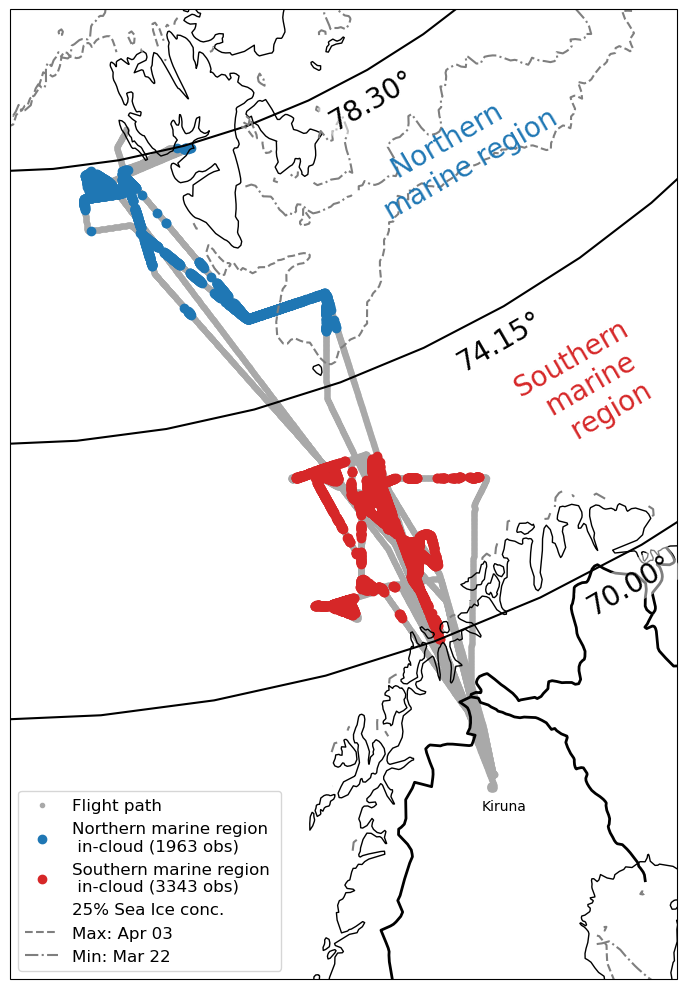

In [14]:
# --- Split for southern marine, northern marine datasets (in cloud)

# --- plotting division areas
# Define latitudes to set as boundaries
lat_min = ds_incloud.lat.values.min() 
lat_max = ds_incloud.lat.values.max()
lat_mid = lat_min + ((lat_max-lat_min)/2) # separation point for the southern marine and northern marine

# set lat-bands to compute between (as an array)
lat_bands = [lat_min, lat_mid, lat_max]

# Get the mask to use to select northern and southern band data
lat_mask_north, lat_mask_south,set_val_count_dict = plots.lat_2band_select(lat_bands, ds_incloud)

# set the value of region based on the two masks
ds_incloud['region'] = xr.where(lat_mask_north, 'north', xr.where(lat_mask_south, 'south', 'none'))

# drop values where region is 'none'
no_region_mask = (ds_incloud['region']=='none').compute()
ds_incloud = ds_incloud.where(~no_region_mask, drop=True)

# plot this variant of latitude bands:
#plot_text = f'In-cloud observations \n (tot. {len(ds_incloud.time)} obs.) per region' #\n \
           # Preselection: {pre_text}\n \
            #in-cloud threshold method: {th_method}, threshold(s): {th}'
savefile = save_path + f'Latitude_bands_regions_{sample_rate}s_{th_method}{preopt}.png'
plot_lat_bands(lat_bands, ds, ds_incloud, sic_max_ds,sic_min_ds,'', savefile= savefile)

print(savefile)


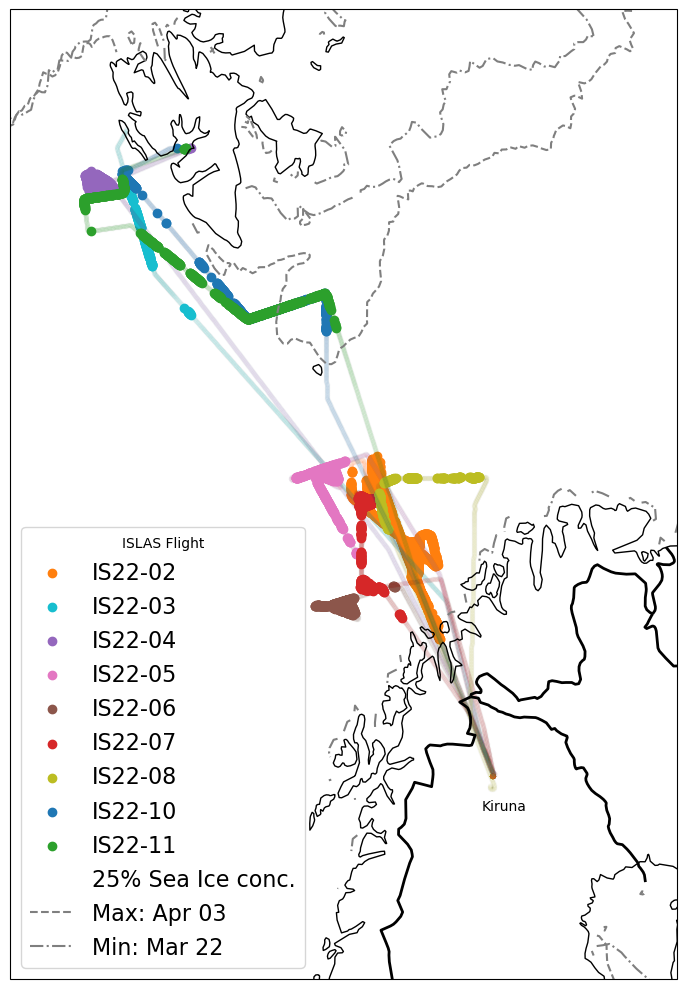

In [15]:
# Plot: incloud observations per flight

#savefile = save_path + f'Incloud_pr_flight_{min_date}.png' # testing different sea ice oconcentration files
savefile = save_path + f'Incloud_pr_flight_{sample_rate}s_{th_method}{preopt}.png'


plot_flight_obs(ds, ds_incloud,sic_max_ds, sic_min_ds, obs=True,savefile=savefile)

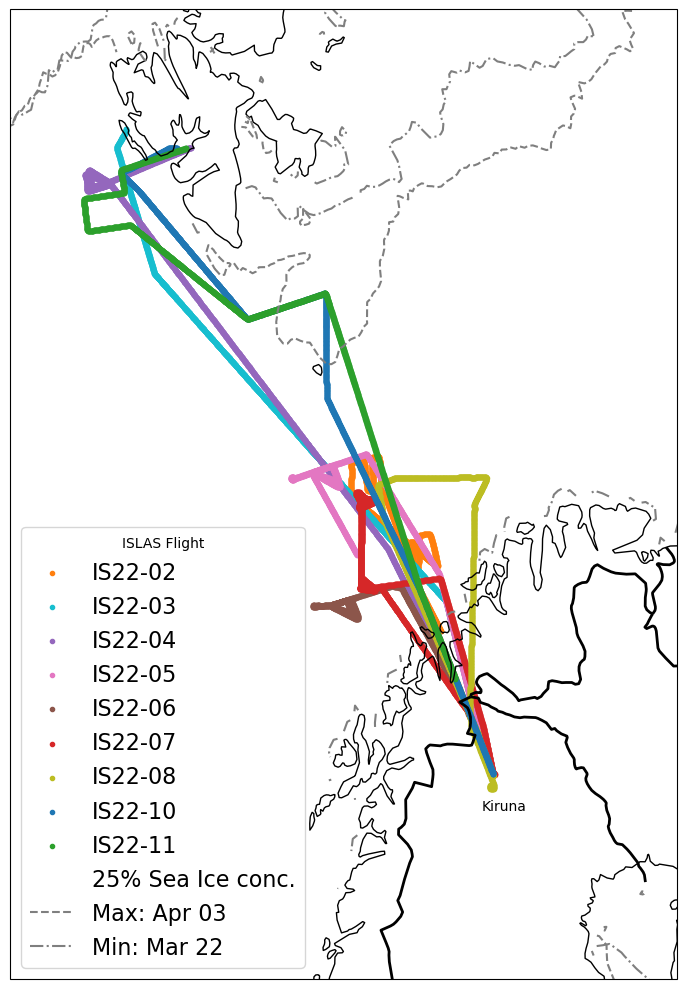

In [16]:
# Plot: flights from ISLAS campaign in use with sea ice concentration
savefile = save_path + f'Islas_flights_{sample_rate}s_{th_method}{preopt}.png'
plot_flight_obs(ds, ds_incloud,sic_max_ds, sic_min_ds, obs=False,savefile=savefile)

In [17]:
# Create dataframe for visualizing available observations with Heatmap
# - number of observations per altitude bin vs. distance bin

def reorg_heatmap_df(data):
     # reorganize data before plotting heatmap
    # - turn into dataframe - unstack to get correct array structure  
    new_df = data.to_dataframe().unstack()
    
    # - transpose to get altitude on y-axis - reset index and drop outer index(base_time)
    new_df = new_df.T.reset_index(level=0, drop = True)
    # -  make sure all possible bins for y-axis is representedented, 
    if 'altitude_bin' in data.coords:
          new_df = new_df.reindex(bin_labels, fill_value=0).iloc[::-1] # fill with 0 - reverse order of altitudes
          new_df = new_df.fillna(0) # set nan to 0 (for easier plot management)
          new_df = new_df.astype(int) # set the count to int
    elif 'temp_bin' in data.coords:
          new_df = new_df.reindex(temp_bins, fill_value=0) # fill with 0
          new_df = new_df.fillna(0) # set nan to 0 (for easier plot management)

    return new_df
   


In [18]:
def create_distribution_df(ds, xbins, ybins, statistic,val, mask = ""):
    # function to prepare the selected data (ds) to create heatmaps with x-axis xbins and y-axis ybins
    # REQUIRES: 
    #   -- pandas
    # INPUT: 
    #   -- ds: selected dataset(xarray)
    #   -- xbins: string indicating coordinate in ds to use for x-axis
    #   -- ybins: string indicating coordinate in ds to use for y-axis
    #   -- statistic: what should be calculated (count, mean, std)
    #   -- val: number of digits to display
    #   -- mask: mask to hide in cloud values
    # RETURNS: 
    #   -- dist_df: dataframe containing the distriburion over the xbin/ybin
    #   -- incloud_mask: mask where no observations

    import pandas as pd

    # Dataset grouped by xbins
    data_groupedx = ds.groupby(xbins)

    if statistic=='count':
        data_groupedxy = data_groupedx.map(lambda group: group.groupby(ybins).count())
    elif statistic=='mean':
        data_groupedxy = data_groupedx.map(lambda group: group.groupby(ybins).mean())
    elif statistic=='std':
        data_groupedxy = data_groupedx.map(lambda group: group.groupby(ybins).std())
    elif statistic =='max':
        data_groupedxy = data_groupedx.map(lambda group: group.groupby(ybins).max())
    else:
        print(f"Statistic {statistic} not available, use 'count','max', 'mean' or 'std'")
        return
    
    #reorganize data
    dist_df = reorg_heatmap_df(data_groupedxy)

    # round to val number of digits
    dist_df.round(decimals=val)

    if statistic=='count':
        incloud_mask = dist_df == 0 # create the in-cloud mask
        return dist_df, incloud_mask
    else:
        if isinstance(mask, pd.DataFrame):
            dist_df = dist_df.mask(mask,np.nan)
            return dist_df
        else:
            print('No masking of incloud values have been made, (mask not available)')
            return dist_df
            
    

In [19]:
# General function to create the heatmaps the heatmap plots
def plot_heatmap_ax(dist_df, labels_dict, ax, mask_na=False, val=0, annot_df = False,counts=False,col='Blue',ncol=6,ss=10,ticks="", v_extend=False):
    # General function to create the heatmaps for article
    # REQUIRES: 
    #   -- matplotlib
    #   -- seaborn
    #   -- pandas
    # INPUT: 
    #   -- dist_df: dataframe to create the heatmap from
    #   -- labels_dict: dictionary containing labels for {xax_lab, yax_lab, cbar_lab}
    #   -- ax: axis to add the plot
    #   -- mask_na(DEFAULT:False): boolean, whether or not the nan values should be masked in the annotation
    #   -- val: number of digits in annotation
    #   -- annot_df (OPTIONAL): df of equal size of dist_df to use for annotating the cells in the heatmap
    #   -- counts (OPTIONAL): set 0 values to white
    #   -- col(OPTIONAL): color to use in plot, either "Blue", "Grey" or custom color palette
    #   -- ncol (OPTIONAL): number of discrete color values (default=6)
    #   -- ss(OPTIONAL): text size of plot (default=10)
    #   -- ticks(OPTIONAL): Array of values to use as ticks on colorbar. if empty ncol and max/min of data is used to set ticks
    #   -- v_extend(OPTIONAL): max value for colorbar

    # required functions
    import seaborn as sns
    import matplotlib.colors as mcolors
    import matplotlib.pyplot as plt
    
    # Set up plot options
    plt.rcParams.update({'font.size':ss}) # set global font size

    xax_lab = labels_dict['xax_lab'] # Get labels from dictionary
    yax_lab = labels_dict['yax_lab']
    cbar_lab = labels_dict['cbar_lab']    
    
    # Set colorpalette based on input
    # default = Blue
    if col=="Grey":
        cmap=sns.cubehelix_palette(ncol, hue=0, dark=.25, as_cmap=True)
    elif col=="Blue":
        cmap=sns.cubehelix_palette(ncol, rot=-.15, dark=.25, as_cmap=True)
    else:
        cmap = col

    # handling of cbar values depending on whether specific ticks are given
    if isinstance(ticks,np.ndarray):
        # if an array is given as ticks, extract max and min from array
        ticks = ticks
        minv=ticks[0]
        maxv=ticks[-1]

    else:
        # ticks are not specificly set
        minv=0
        # get max for colorbar
        if v_extend:
            maxv = v_extend # if vextend exists use vextend as max
        else:
            maxv=np.nanmax(dist_df.values) # else use max of values
        
        col_bins = maxv/ncol # find the size of each colorbin based on max value and number of colors
        ticks = np.arange(minv, maxv + col_bins, col_bins) # get ticks for cbar

    

    
    # Set format of the values
    if abs(np.nanmax(dist_df.values))<1:
        format='%.2f' # if values less than 1, two digits
    else:
        format='%.0f' # else none
    
    # fix parts to make 0 white in some of the plots
    if counts==True:
        minv=1
    

    # set normalization of colorbar
    norm = mcolors.BoundaryNorm(ticks, cmap.N)


    # Plot the heatmap with different settings
    if mask_na:
        # Mask away NA values
        nan_mask = dist_df.isna() # mask nan values for annotation
        
        if v_extend:
            # when the v_extend value should be used as the max
            if v_extend<np.nanmax(dist_df.values):
                pl = sns.heatmap(dist_df, annot=annot_df, fmt=f".{val}f", cmap=cmap,norm=norm, vmin= minv, vmax=v_extend,  mask=nan_mask, ax=ax, 
                    cbar_kws={"location" : "left", 'extend':'max','ticks':ticks, 'format':format, 'label':cbar_lab},
                    linewidths=0.5, annot_kws={'size':ss})
            else:
                pl = sns.heatmap(dist_df, annot=annot_df, fmt=f".{val}f", cmap=cmap, norm=norm,vmin= minv, vmax=v_extend,  mask=nan_mask, ax=ax, 
                    cbar_kws={"location" : "left",'ticks':ticks, 'format':format,'label':cbar_lab},
                    linewidths=0.5, annot_kws={'size':ss})
        else:
            pl = sns.heatmap(dist_df, annot=annot_df, fmt=f".{val}f", cmap=cmap,norm=norm,vmin=minv, mask=nan_mask, ax=ax, 
                cbar_kws={"location" : "left",'ticks':ticks, 'format':format,'label':cbar_lab},
                linewidths=0.5, annot_kws={'size':ss})
    else:
       if v_extend:
            if v_extend<np.nanmax(dist_df.values):
                pl = sns.heatmap(dist_df, annot=annot_df, fmt=f".{val}f", cmap=cmap,norm=norm, vmin= minv, vmax=v_extend, ax=ax, 
                    cbar_kws={"location" : "left", 'extend':'max','ticks':ticks, 'format':format,'label':cbar_lab},
                    linewidths=0.5, annot_kws={'size':ss})
            else:
                pl = sns.heatmap(dist_df, annot=annot_df, fmt=f".{val}f", cmap=cmap,norm=norm, vmin= minv, vmax=v_extend, ax=ax, 
                    cbar_kws={"location" : "left",'ticks':ticks, 'format':format,'label':cbar_lab},
                    linewidths=0.5, annot_kws={'size':ss})
       else:
           pl = sns.heatmap(dist_df, annot=annot_df, fmt=".0f", cmap=cmap,norm=norm,vmin=minv, ax=ax, 
                cbar_kws={"location" : "left",'ticks':ticks, 'format':format,'label':cbar_lab},
                linewidths=0.5, annot_kws={'size':ss})


    pl.set_xlabel(xax_lab, fontsize=ss) # set plot labels
    pl.set_ylabel(yax_lab, fontsize=ss)

    # colorbar options
    cax=pl.figure.axes[-1]
    cax.tick_params(labelsize=ss)  # Change the size of the colorbar ticks

    # tick adjustment
    # Shift the x-ticks to the left edge of each cell
    labels = pl.get_xticklabels()
    labels[0].set_text('-125') # change the first ticklabel to the lowest distance from sea ice distance
    new_x_ticks = np.arange(len(dist_df.columns))  # Get new x-tick positions to align with the left edge of cells
    pl.set_xticks(new_x_ticks)  # Set new ticks at the left side of cells
    pl.set_xticklabels(labels,fontsize=ss)  # Reuse the old labels

    # remove any decimals in the ytick label texts
    new_y_ticks = np.arange(len(dist_df))  # Get new x-tick positions to align with the left edge of cells
    pl.set_yticks(new_y_ticks)  # Set new ticks at the left side of cells

    # Set labels for y-axes based on temp or altitude
    if dist_df.index.name=='altitude_bin':
        y_labels=altitude_bins[1:len(dist_df)+1][::-1].astype(int)
        pl.set_yticklabels(y_labels,fontsize=ss, rotation=0)
    elif dist_df.index.name=='temp_bin':
        y_labels=temp_bins
        pl.set_yticklabels(y_labels,fontsize=ss, rotation=0)

    
    return 

# Number of observations and flights

In [20]:
# calculations for number of observations

# counts per distance-altitude
count_df, incloud_mask = create_distribution_df(ds_incloud['base_time'],'dist_bin','altitude_bin','count',val=0) # count all in cloud observations
count_rel_df, m = create_distribution_df(ds_relevant['base_time'],'dist_bin', 'altitude_bin', 'count',val=0) # count all observations
# Calculating the percentage of total observations per category that is in cloud:
dist_df = ((count_df/count_rel_df)*100)

# counts per distance-temperature (NEED TO UPDATE THE CALCULATION OF RELEVANT TO INKLUDE TEMP_BIN)
count_T_df, incloud_mask_T = create_distribution_df(ds_incloud['base_time'],'dist_bin','temp_bin','count',val=0) # count all in cloud observations
#count_T_rel_df, mT = create_distribution_df(ds_relevant['base_time'],'dist_bin', 'temp_bin', 'count',val=0) # count all observations
# Calculating the percentage of total observations per category that is in cloud:
#dist_T_df = ((count_T_df/count_T_rel_df)*100)

In [21]:
np.nanmin(ds_incloud.distance_from_ice.values)

np.float64(-125.0)

Plot is saved to: /home/ninalar/Documents/MC2/procIslasMicrophy-1/save_images/sample_rate/dist200/Perc_incloud_alt_sic_dist200_sr5.png


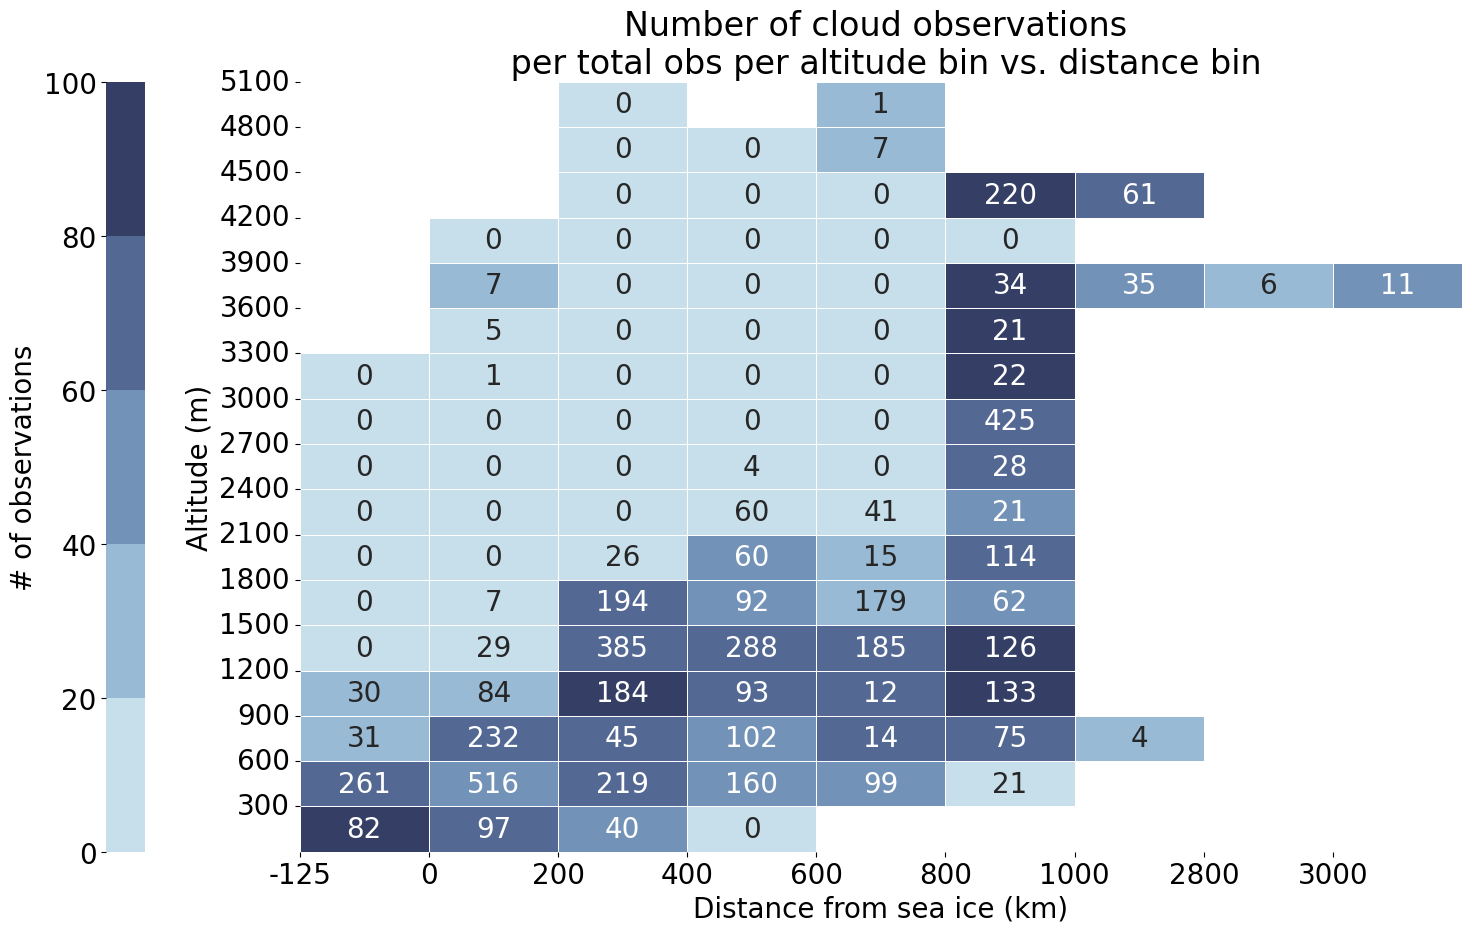

In [22]:
# Heatplot of percentage of observations that where in-cloud
# y-axis: Altitude

labels_dict = {
    'xax_lab':'Distance from sea ice (km)',
    'yax_lab':'Altitude (m)',
    'cbar_lab':'# of observations'
}

savefile = save_path + f'Perc_incloud_alt_sic_{d_text}_sr{sample_rate}.png'


fig,ax = plt.subplots(figsize=(20, 10))

plot_heatmap_ax(dist_df, labels_dict, ax, mask_na= False, val=0, annot_df = count_df, counts=False, ss=20, ncol=5, v_extend=False)

ax.set_title("Number of cloud observations \n per total obs per altitude bin vs. distance bin")

plt.savefig(savefile, bbox_inches='tight')
print(f'Plot is saved to: {savefile}')

plt.show()


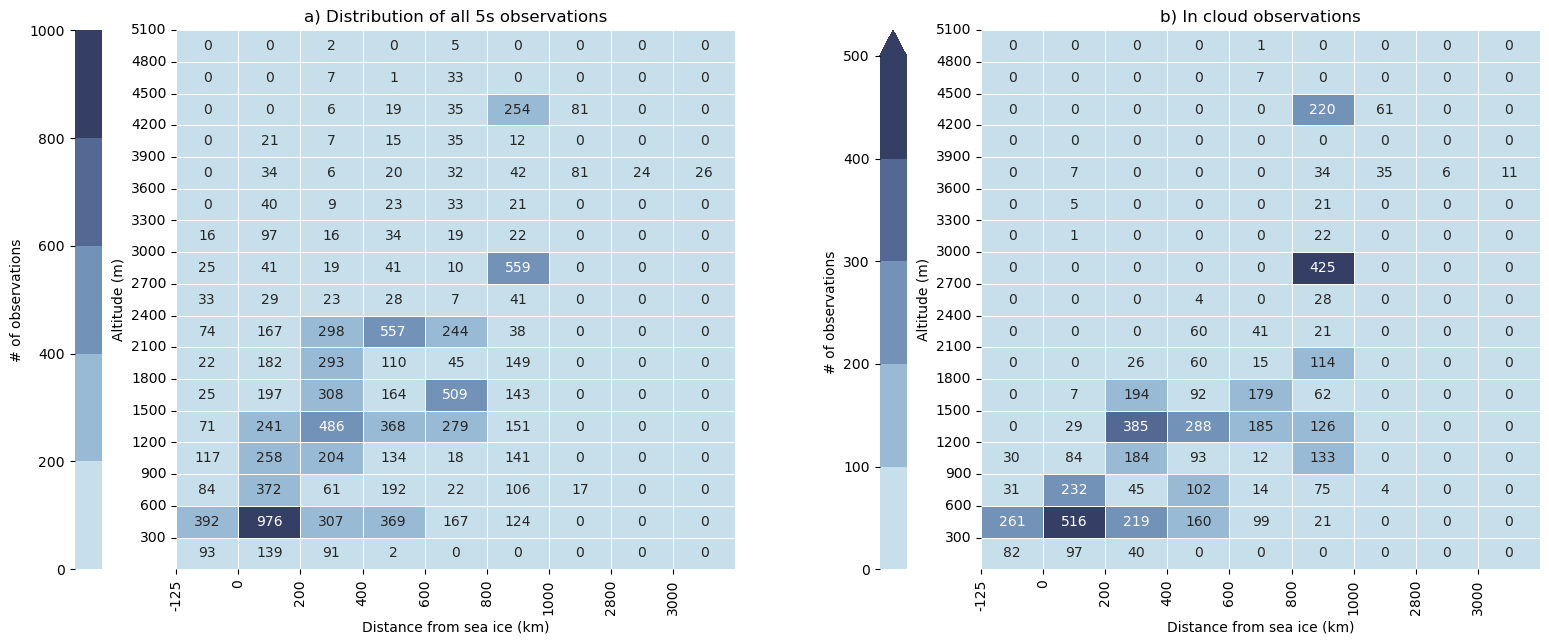

In [23]:
# ---- Get the distributions




# ---- Plot 
fig, ax = plt.subplots(1,2, figsize=(20, 7))
plt.subplots_adjust(wspace=0.08)

# Double plot of the cloud distribution

# Total number of observations (5s)
plot_heatmap_ax(count_rel_df, labels_dict, ax[0], mask_na=False, val=0, annot_df = count_rel_df,counts=False, ncol=5, v_extend=1000)
ax[0].set_title('a) Distribution of all 5s observations')
# CDNC
plot_heatmap_ax(count_df, labels_dict, ax[1], mask_na=True, val=0, annot_df = count_df,counts=True,ncol=5, v_extend=500)
ax[1].set_title('b) In cloud observations')


savefile = save_path + f'obs_count_incloud_count_{d_text}_{sample_rate}s.png'
plt.savefig(savefile, bbox_inches='tight')

In [24]:
# code to remove what we do not want to focus on:

# remove upper level clouds

alt_remove_dict = {
  125: [125,625],
200: [0,200,600],
250: [0,500],
300: [0,600]
}

# Remove first set of upper clouds
mask1 = ((ds_incloud['dist_bin']==alt_remove_dict[dist_bin_size][0])&(ds_incloud['altitude_bin']>3000)).compute()
part1_ds = ds_incloud.where(~mask1, drop=True)

if dist_bin_size==200:
    # Remove second set of upper clouds
    mask2 = ((part1_ds['dist_bin']==alt_remove_dict[dist_bin_size][1]) & (part1_ds['altitude_bin']>3000)).compute()
    part2_ds = part1_ds.where(~mask2, drop=True)
    
    # Remove third set of upper clouds
    mask3 = ((part2_ds['dist_bin']==alt_remove_dict[dist_bin_size][2]) & (part1_ds['altitude_bin']>4500)).compute()
    ds_incloud_lmp = part2_ds.where(~mask3, drop=True)

else:
    # Remove second set of upper clouds
    mask2 = ((part1_ds['dist_bin']==alt_remove_dict[dist_bin_size][1]) & (part1_ds['altitude_bin']>4500)).compute()
    ds_incloud_lmp = part1_ds.where(~mask2, drop=True)



# drop the two furthest distances 

# dictonary for selecting bins to remove.
dist_remove_dict = {
  125: [1000,1125],
200: [1000,1200],
250: [1000,1250],
300: [1200]
}
# select away the distances higher than the lowest distance to remove
maskt = (ds_incloud_lmp['dist_bin']<dist_remove_dict[dist_bin_size][0]).compute()
ds_incloud_lmp = ds_incloud_lmp.where(maskt, drop=True)

# recalculate the masks and dists for the lower level mixed phase clouds
# counts per distance-altitude
count_df, incloud_mask = create_distribution_df(ds_incloud_lmp['base_time'],'dist_bin','altitude_bin','count',val=0) # count all in cloud observations



Plot is saved to: /home/ninalar/Documents/MC2/procIslasMicrophy-1/save_images/sample_rate/dist200/Incloud_LMP_count_dist200_sr5.png


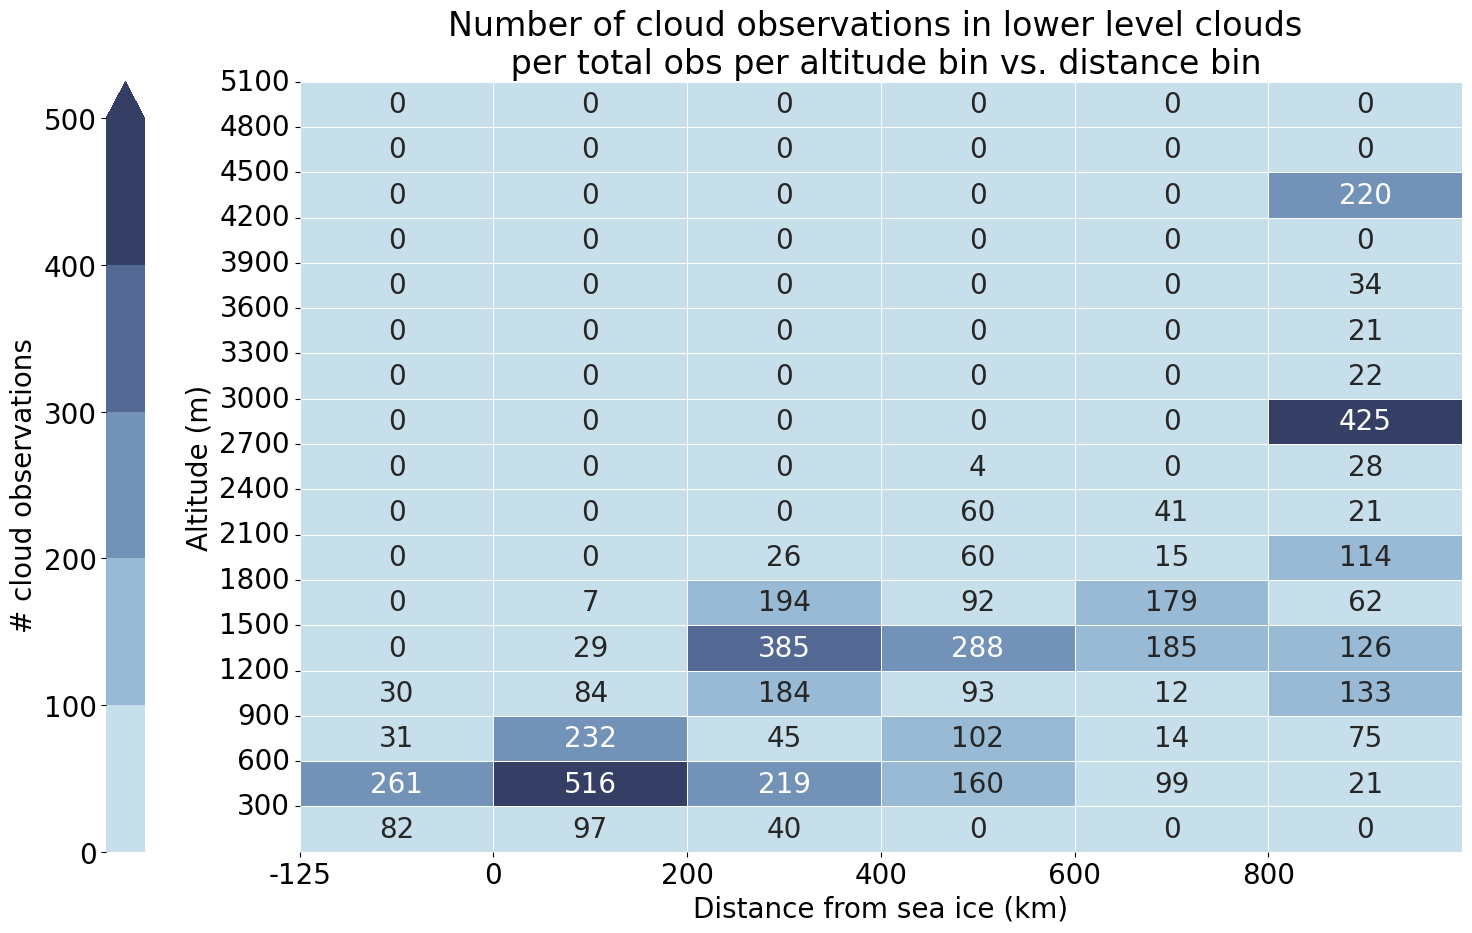

Sum of observations per 200km distance bin: dist_bin
-200     404
 0       965
 200    1093
 400     859
 600     545
 800    1302
dtype: int64


In [25]:
# in lower level mixed phase cloud observations

# Heatplot of percentage of observations that where in-cloud
# y-axis: Altitude

labels_dict = {
    'xax_lab':'Distance from sea ice (km)',
    'yax_lab':'Altitude (m)',
    'cbar_lab':'# cloud observations'
}

savefile = save_path + f'Incloud_LMP_count_{d_text}_sr{sample_rate}.png'

fig,ax = plt.subplots(figsize=(20, 10))

plot_heatmap_ax(count_df, labels_dict, ax, mask_na= False, val=0, annot_df = count_df, counts=False, ss=20,ncol=5, v_extend=500)

ax.set_title("Number of cloud observations in lower level clouds \n per total obs per altitude bin vs. distance bin")

plt.savefig(savefile, bbox_inches='tight')
print(f'Plot is saved to: {savefile}')

plt.show()



# sum each colum to get the number of observations per distance bin
col_sum = count_df.sum()

print(f'Sum of observations per {dist_bin_size}km distance bin: {col_sum}')

Plot is saved to: /home/ninalar/Documents/MC2/procIslasMicrophy-1/save_images/sample_rate/dist200/islasid_alt_dist200_5s.png


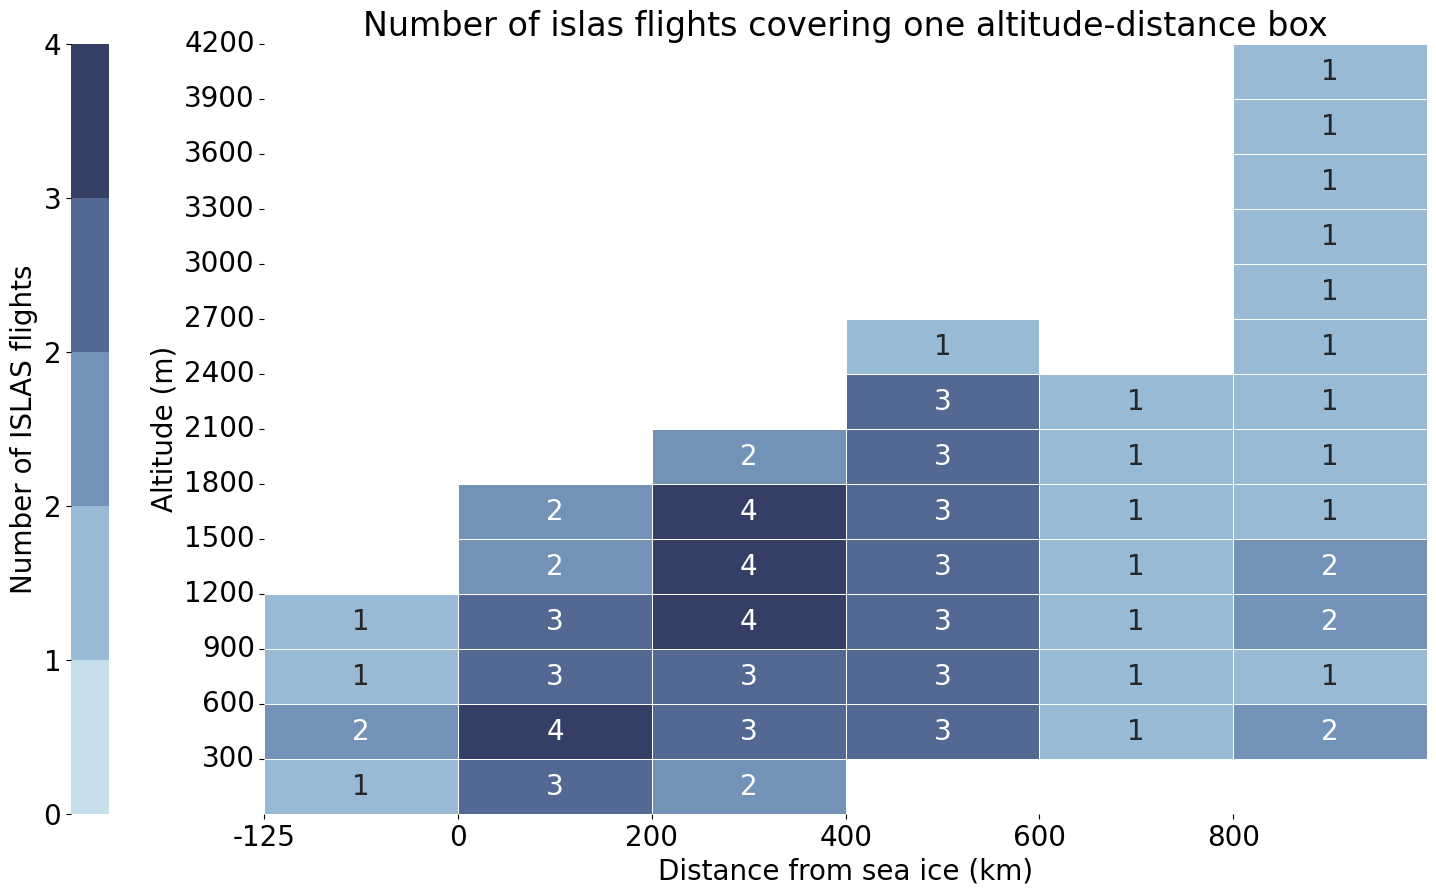

In [26]:
# Heatplot of Number of flights 
# y-axis: altitude
# id_count_df

# count of flights per box
id_df = ds_incloud_lmp['islasid'].to_dataframe()
grouped_df = id_df.groupby('dist_bin')  # Groupby dist_bin
id_count_df = grouped_df.apply(lambda group: group.groupby('altitude_bin')['islasid'].nunique(), include_groups=False).iloc[:,0]

id_count_df = id_count_df.unstack()
# - transpose to get altitude on y-axis - reset index and drop outer index(base_time)
id_count_df = id_count_df.T
# flip axis
id_count_df = id_count_df.iloc[::-1] #

labels_dict = {
    'xax_lab':'Distance from sea ice (km)',
    'yax_lab':'Altitude (m)',
    'cbar_lab':"Number of ISLAS flights"
}

savefile = save_path + f'islasid_alt_{d_text}_{sample_rate}s.png'

fig,ax = plt.subplots(figsize=(20, 10))

plot_heatmap_ax(id_count_df, labels_dict, ax, mask_na= True, val=0, annot_df = id_count_df, counts=False, ss=20,ncol=5)

ax.set_title("Number of islas flights covering one altitude-distance box")

plt.savefig(savefile, bbox_inches='tight')
print(f'Plot is saved to: {savefile}')

plt.show()


# In cloud temperature

In [ ]:
# add temperature to other plots functions

def fmt(x):
    # function to add temp unit
    s = f"{x:.0f}"
    return f"{s} $^\circ$C"

def temp_contour(ax, temp_mean_df):
    # Add temp contour lines for -10 and -20 based on the mean temp values per bin

    # Prepare temperature observations for contour plot
    X,Y = np.meshgrid(temp_mean_df.columns.values, temp_mean_df.index.values)
    Z = temp_mean_df.values


    #label_locations = [(700,2400),(800,600)]
    temp_c = ax.contour(X, Y, Z, levels=[-20,-10], colors='Red')

    ax.set_xlim(-200,1000) # set limits to match the histogram plots
    ax.clabel(temp_c, temp_c.levels,inline=True, fmt=fmt, fontsize=20)

    return

def temp_steps(ax,tb,th20,th10, leg=True):
    # Create step plots indicating where temperature exceeds -20 and -10
    
    ax_t = fig.add_axes(ax.get_position(), frameon=False) # create new axes

    # create step plots for T=-10 and T=-20
    ax_t.step(tb, th20, where='post', color='red', linewidth=4,linestyle='--', label='-20$^\circ$C')
    ax_t.step(tb, th10, where='post', color='red', linewidth=4,linestyle='-.', label='-10$^\circ$C')

    # set limits to match the histogram plots
    ax_t.set_xlim(-200,1000) 
    ax_t.set_ylim(0,5100)

    # set axes invisible
    ax_t.axes.get_xaxis().set_visible(False)
    ax_t.axes.get_yaxis().set_visible(False)

    # define legend
    if leg==True:
        ax_t.legend(loc='upper left')

    return

def T_th_array(df, th):
    # find the heights in a dataframw where the mean T is above a threshold
    # return array of heights

    # find heights with list comprehension
    # add 150 to get top bin edge
    th = np.array([(df[col] > th).idxmax() for col in df.columns]).astype(int)+150
    # duplicate last value to cover complete plot for step plots
    th =np.append(th, th[-1])
    # if values larger than 5000 it hould be 0
    th[th>5000]=0

    return th

Plot is saved to: /home/ninalar/Documents/MC2/procIslasMicrophy-1/save_images/sample_rate/dist200/temp_incloud_alt_dist200_5s.png


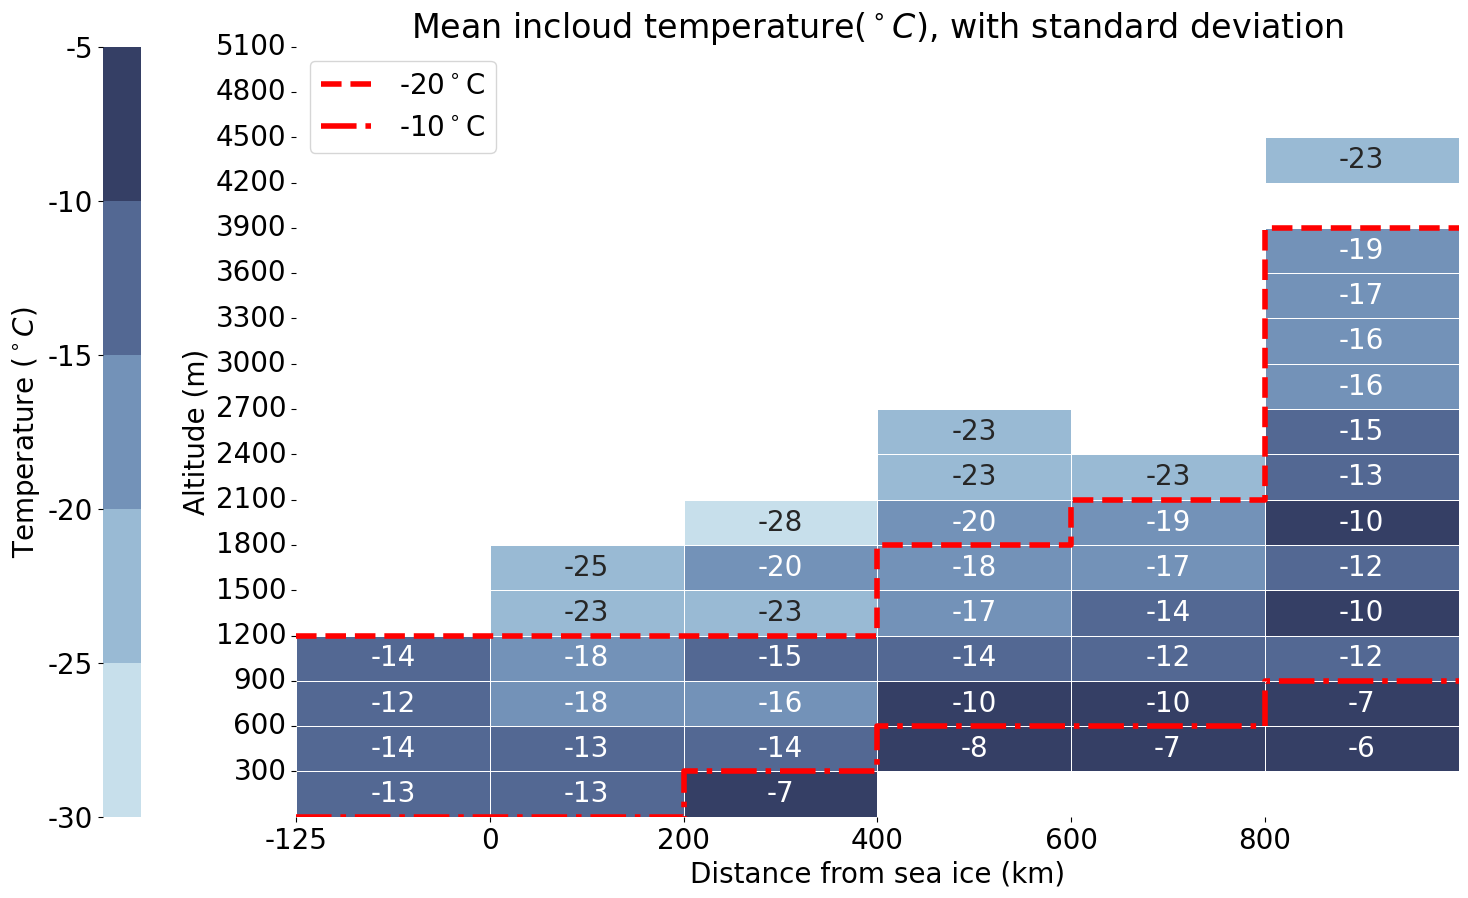

In [ ]:
# Heatplot of mean temperature in-cloud
# y-axis: altitude
# temp_mean_df, temp_std_df,

temp_mean_df = create_distribution_df(ds_incloud_lmp['T'],'dist_bin','altitude_bin','mean',val=0, mask=incloud_mask)
temp_std_df = create_distribution_df(ds_incloud_lmp['T'],'dist_bin','altitude_bin','std',val=0, mask=incloud_mask)

# Get values for plotting -20 and -10 temperature lines with temp_steps:
tb = np.unique(ds_incloud_lmp.dist_bin.values) # get the distance bins
tb = np.append(tb,tb[-1]+dist_bin_size) # for step plot one moe bin must be added to cover complete plot
th10=T_th_array(temp_mean_df,-10)
th20=T_th_array(temp_mean_df,-20)



labels_dict = {
    'xax_lab':'Distance from sea ice (km)',
    'yax_lab':'Altitude (m)',
    'cbar_lab':"Temperature ($^\circ C$)"
}

savefile = save_path + f'temp_incloud_alt_{d_text}_{sample_rate}s.png'

fig,ax = plt.subplots(figsize=(20, 10))

plot_heatmap_ax(temp_mean_df, labels_dict, ax, mask_na= True, val=0, annot_df = temp_mean_df, counts=False, ss=20, ncol=5,ticks = np.arange(-30, 0, 5),v_extend=-5)

# add temperature lines -10 and -20
temp_steps(ax,tb,th20,th10)


ax.set_title("Mean incloud temperature($^\circ C$), with standard deviation")

plt.savefig(savefile, bbox_inches='tight')
print(f'Plot is saved to: {savefile}')

plt.show()

# SLF

In [53]:
slf_mean_df

dist_bin,-200,0,200,400,600,800
altitude_bin,,,,,,
4950.0,NaN,NaN,NaN,NaN,NaN,NaN
4650.0,NaN,NaN,NaN,NaN,NaN,NaN
4350.0,NaN,NaN,NaN,NaN,NaN,7.0
4050.0,NaN,NaN,NaN,NaN,NaN,NaN
3750.0,NaN,NaN,NaN,NaN,NaN,0.0
3450.0,NaN,NaN,NaN,NaN,NaN,0.0
3150.0,NaN,NaN,NaN,NaN,NaN,0.0
2850.0,NaN,NaN,NaN,NaN,NaN,1.0
2550.0,NaN,NaN,NaN,2.0,NaN,0.0


Plot is saved to: /home/ninalar/Documents/MC2/procIslasMicrophy-1/save_images/sample_rate/dist200/slf_incloud_TC_alt_dist200_5s.png


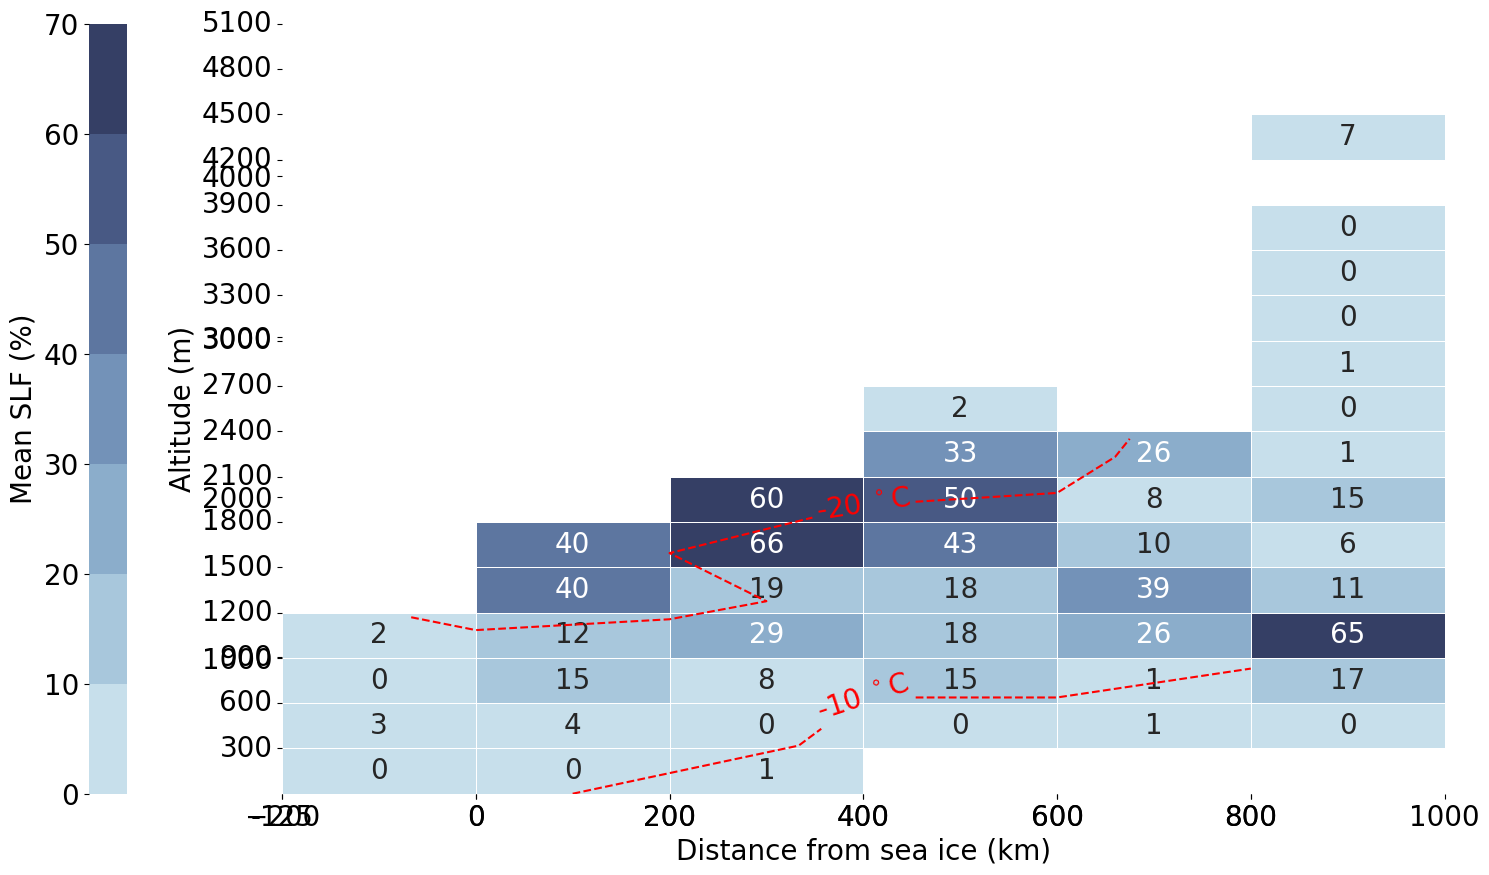

In [54]:

# Heatplot of mean SLF in-cloud
# y-axis: altitude
# slf_mean_df,
ss=22
slf_mean_df = create_distribution_df(ds_incloud_lmp['SLF'],'dist_bin','altitude_bin','mean',val=0, mask=incloud_mask)


labels_dict = {
    'xax_lab':'Distance from sea ice (km)',
    'yax_lab':'Altitude (m)',
    'cbar_lab':"Mean SLF (%)"
}

savefile = save_path + f'slf_incloud_TC_alt_{d_text}_{sample_rate}s.png'

f,ax = plt.subplots(figsize=(20, 10))

plot_heatmap_ax(slf_mean_df, labels_dict, ax, mask_na= True, val=0, annot_df = slf_mean_df, counts=False, ss=20, ncol=7, v_extend=70)


ax_t = f.add_axes(ax.get_position(), frameon=False)
temp_c = temp_contour(ax_t,temp_mean_df)

#ax_t.axes.get_xaxis().set_visible(False)
#ax_t.axes.get_yaxis().set_visible(False)

plt.savefig(savefile, bbox_inches='tight')
print(f'Plot is saved to: {savefile}')

plt.show()


# Need to look further into how to save and show this...

In [70]:
Y

array([[4950., 4950., 4950., 4950., 4950., 4950.],
       [4650., 4650., 4650., 4650., 4650., 4650.],
       [4350., 4350., 4350., 4350., 4350., 4350.],
       [4050., 4050., 4050., 4050., 4050., 4050.],
       [3750., 3750., 3750., 3750., 3750., 3750.],
       [3450., 3450., 3450., 3450., 3450., 3450.],
       [3150., 3150., 3150., 3150., 3150., 3150.],
       [2850., 2850., 2850., 2850., 2850., 2850.],
       [2550., 2550., 2550., 2550., 2550., 2550.],
       [2250., 2250., 2250., 2250., 2250., 2250.],
       [1950., 1950., 1950., 1950., 1950., 1950.],
       [1650., 1650., 1650., 1650., 1650., 1650.],
       [1350., 1350., 1350., 1350., 1350., 1350.],
       [1050., 1050., 1050., 1050., 1050., 1050.],
       [ 750.,  750.,  750.,  750.,  750.,  750.],
       [ 450.,  450.,  450.,  450.,  450.,  450.],
       [ 150.,  150.,  150.,  150.,  150.,  150.]])

ticks not given
Plot is saved to: /home/ninalar/Documents/MC2/procIslasMicrophy-1/save_images/sample_rate/dist200/slf_incloud_temp_dist200_5s.png


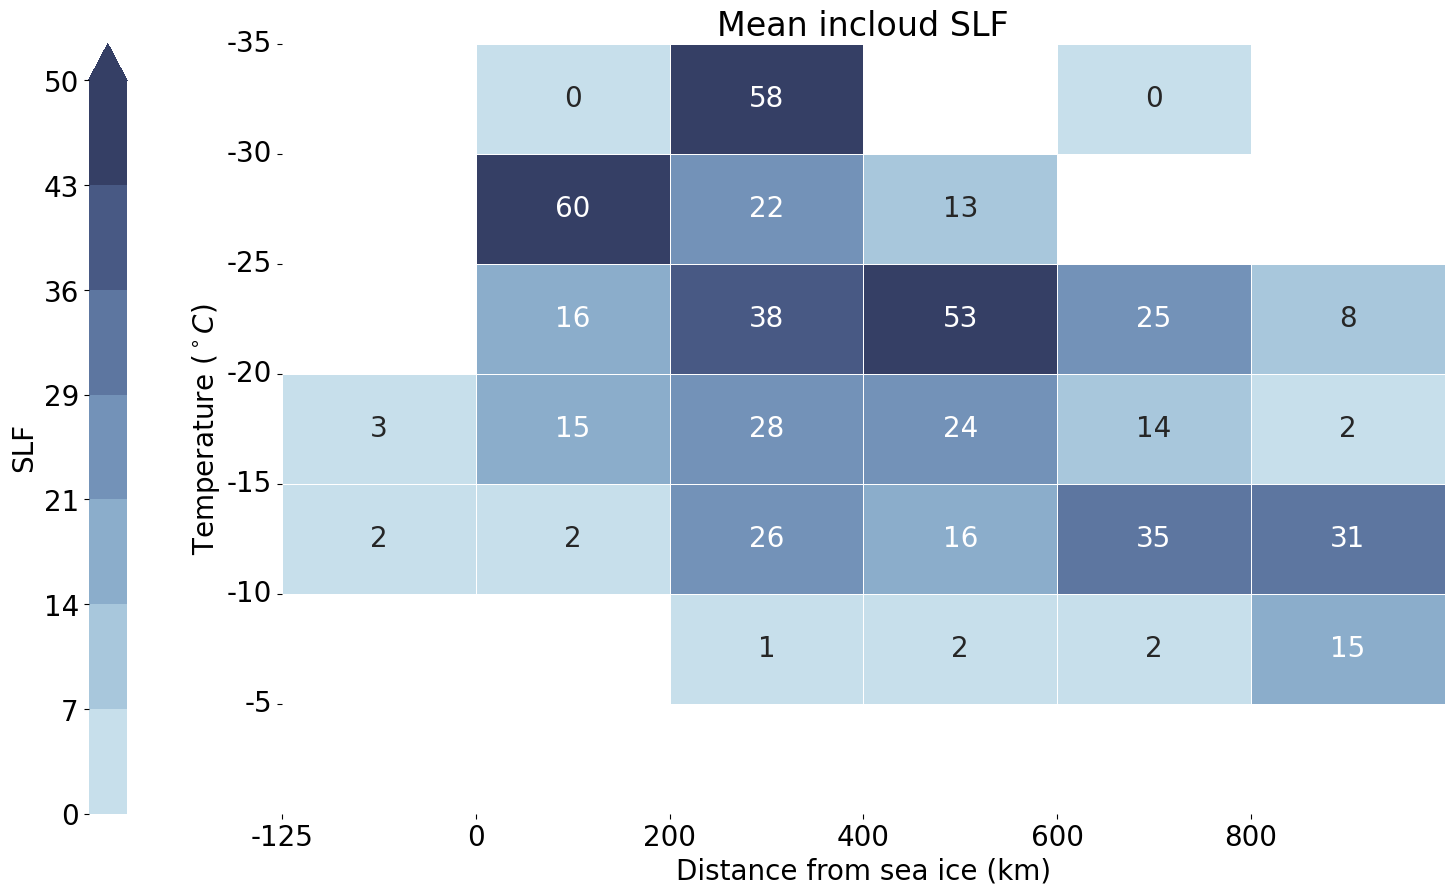

In [71]:
# Heatplot of mean SLF in-cloud
# y-axis: temperature
# slf_mean_df

slf_T_mean_df = create_distribution_df(ds_incloud_lmp['SLF'],'dist_bin','temp_bin','mean',val=0, mask=incloud_mask_T)

labels_dict = {
    'xax_lab':'Distance from sea ice (km)',
    'yax_lab':'Temperature ($^\circ C$)',
    'cbar_lab':"SLF"
}

savefile = save_path + f'slf_incloud_temp_{d_text}_{sample_rate}s.png'

f,ax = plt.subplots(figsize=(20, 10))

plot_heatmap_ax(slf_T_mean_df, labels_dict, ax, mask_na= True, val=0, annot_df = slf_T_mean_df, counts=False, ss=20, ncol=7, v_extend=50)

ax.set_title("Mean incloud SLF")

plt.savefig(savefile, bbox_inches='tight')
print(f'Plot is saved to: {savefile}')

plt.show()

# Particle sizes

In [72]:
def calc_ed(ds):
    # Function to calculate the total Effective diameter from all the timesteps in ds
    # ds: xarray

    # calculate the radius, radius squared and radius cubed
    radius = 0.5*ds['Size'][-1]
    radius_sq = radius**2
    radius_cu = radius**3

    #print(radius.values)
    #print(radius_cu.values)
    #print(radius_sq.values)

    # sum all counts per bin for the selected lines
    sum_count = ds['CDP Bin Particle Count'].sum(dim='time').values
    #print(sum_count)

    # calculate the sum of (sum_count*radius_cu) and (sum_count*radius_sq)
    sum_count_rad_cu = (sum_count*radius_cu).sum().values
    sum_count_rad_sq = (sum_count*radius_sq).sum().values
    #print(sum_count_rad_cu)
    #print(sum_count_rad_sq)


    # Calculate ED:
    ed = 2*(sum_count_rad_cu/sum_count_rad_sq) 
    return ed

In [73]:
# recalculating the Effective diameter for the CDP

# create an empty dataframe and reindex like the slf_mean_df
# to store the calculated ED per dist-alt bin
ed_df = pd.DataFrame().reindex_like(slf_mean_df)

# select only CDP_bins higher than 6 mum
bin_mask = (ds_incloud_lmp.CDP_Bin>6).compute()
ds = ds_incloud_lmp.where(bin_mask, drop=True)


# run through each altitude-distance set
for alt in ed_df.index:
    alt_mask = (ds['altitude_bin']==alt).compute()
    ds_alt = ds.where(alt_mask, drop=True)

    #print(ds_alt.time.values)
    for dist in ed_df.columns:
        #select only the distance
        dist_mask = (ds_alt['dist_bin']==dist).compute()
        ds_dist = ds_alt.where(dist_mask, drop=True)

        # check if there are observations within the alt-dist bin
        # before calculating the ed
        add=len(ds_dist.time)
        if add>0:
            ed = calc_ed(ds_dist)
            ed_df.loc[alt,dist] = calc_ed(ds_dist)

        
ed_df



dist_bin,-200,0,200,400,600,800
altitude_bin,,,,,,
4950.0,NaN,NaN,NaN,NaN,NaN,NaN
4650.0,NaN,NaN,NaN,NaN,NaN,NaN
4350.0,NaN,NaN,NaN,NaN,NaN,21.662710
4050.0,NaN,NaN,NaN,NaN,NaN,NaN
3750.0,NaN,NaN,NaN,NaN,NaN,46.399809
3450.0,NaN,NaN,NaN,NaN,NaN,22.000000
3150.0,NaN,NaN,NaN,NaN,NaN,45.862069
2850.0,NaN,NaN,NaN,NaN,NaN,28.203116
2550.0,NaN,NaN,NaN,13.546626,NaN,22.100358


In [74]:
ed_mean = np.nanmean(ed_df)
ed_meandiff_df = ed_df-ed_mean

ed_mean

np.float64(22.406369275158323)

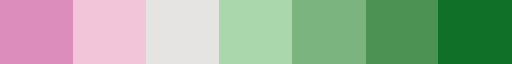

In [115]:
# Color palette 
import matplotlib as mpl

purple_green = ['#93119e','#bc54aa','#dc8dbc','#f2c5d8','#ffffff','#aad7ac','#7bb47e','#4c9253','#117028']# with white
purple_green = ['#93119e','#bc54aa','#dc8dbc','#f2c5d8','#E5E4E2','#aad7ac','#7bb47e','#4c9253','#117028']# with grey

cmap_ed = mpl.colors.ListedColormap(
    name="purple_white_green",
    colors=purple_green[2:]
)
cmap_ed

In [116]:
ts=np.array([-10,-5,-1,1,5,10,15,20])
ts

array([-10,  -5,  -1,   1,   5,  10,  15,  20])

[-10  -5  -1   1   5  10  15  20]
-10
20
Plot is saved to: /home/ninalar/Documents/MC2/procIslasMicrophy-1/save_images/sample_rate/dist200/EDrecalc_meandiff_heatmap_dist200_5s.png


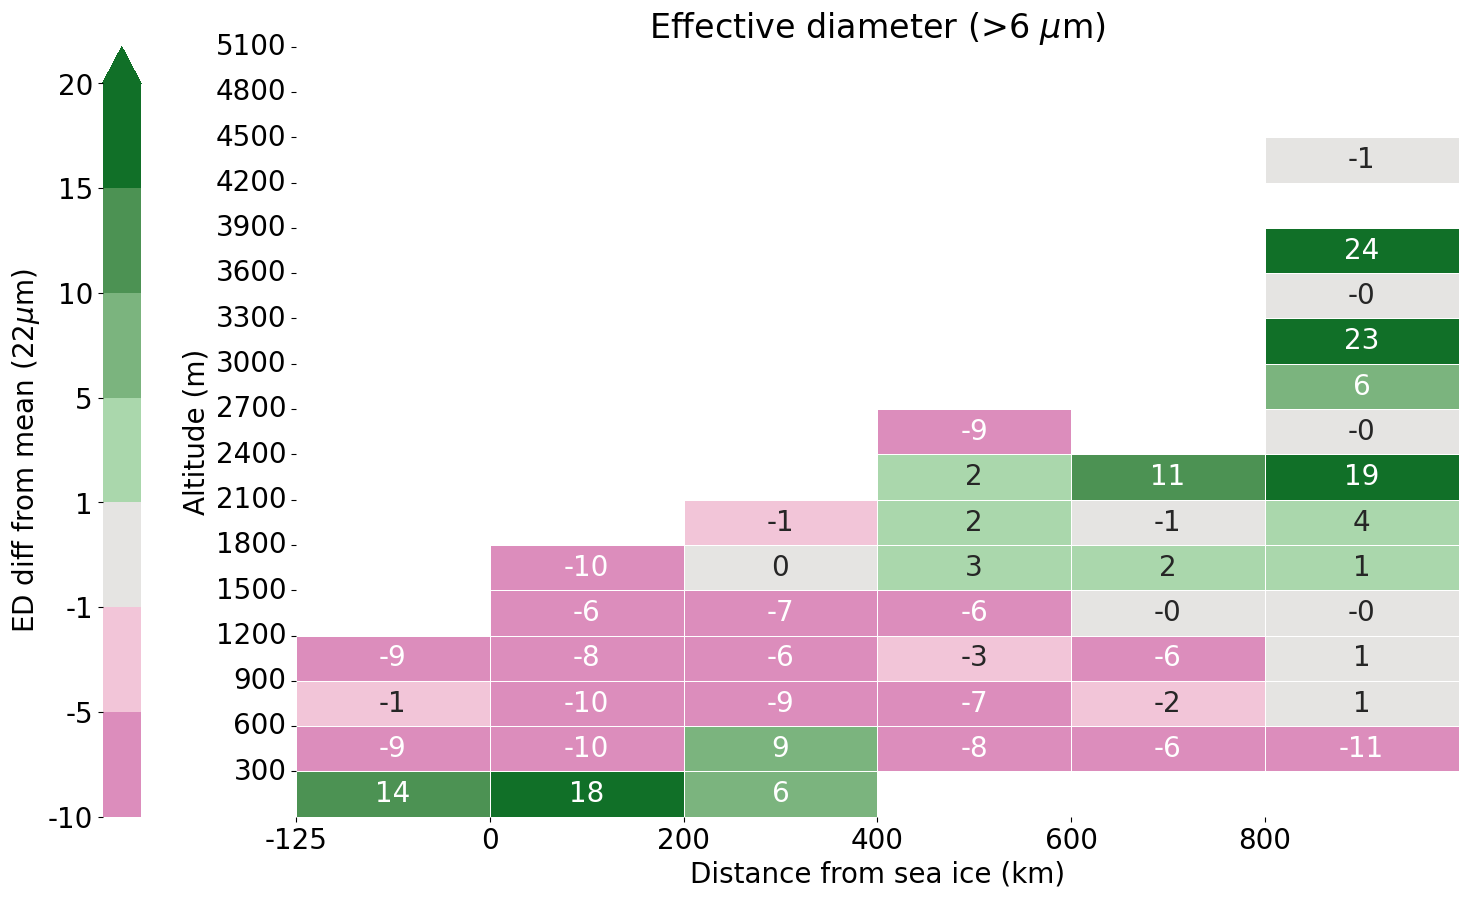

In [117]:
# Heatplot of CDP droplet size (Effective diameter) recalculated for bins larger than 6 mum DIFF FROM MEAN
# y-axis: altitude
# cdp_size_mean_df,cdp_size_std_df


ed_labels_dict = {
    'xax_lab':'Distance from sea ice (km)',
    'yax_lab':'Altitude (m)',
    'cbar_lab':f'ED diff from mean ({round(ed_mean)}$\mu$m)'
}

savefile = save_path + f'EDrecalc_meandiff_heatmap_{d_text}_{sample_rate}s.png'

# Set ticks and colormap to use
t_ed=np.array([-10,-5,-1,1,5,10,15,20])

fig,ax = plt.subplots(figsize=(20, 10))

plot_heatmap_ax(ed_meandiff_df, ed_labels_dict, ax, mask_na= True, val=0, annot_df = ed_meandiff_df, counts=False, ss=20,col=cmap_ed, ticks=t_ed,v_extend=20)

ax.set_title("Effective diameter (>6 $\mu$m)")

plt.savefig(savefile, bbox_inches='tight')
print(f'Plot is saved to: {savefile}')

plt.show()

ticks not given
Plot is saved to: /home/ninalar/Documents/MC2/procIslasMicrophy-1/save_images/sample_rate/dist200/EDrecalc_heatmap_dist200_5s.png


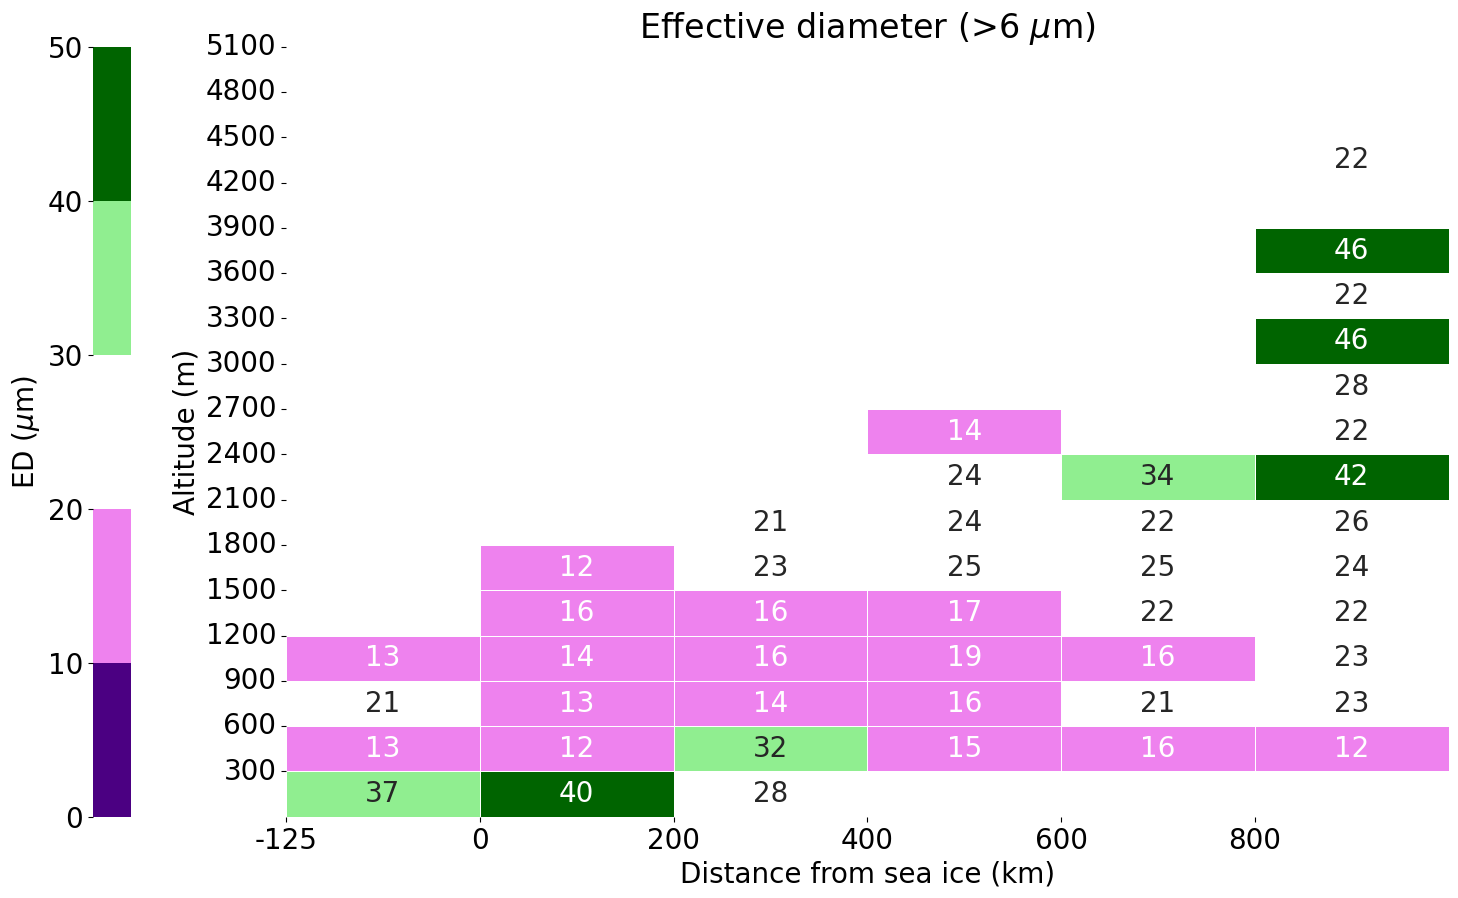

In [118]:
# Heatplot of CDP droplet size (Effective diameter) recalculated for bins larger than 6 mum
# y-axis: altitude
# cdp_size_mean_df,cdp_size_std_df


ed_labels_dict = {
    'xax_lab':'Distance from sea ice (km)',
    'yax_lab':'Altitude (m)',
    'cbar_lab':'ED ($\mu$m)'
}

savefile = save_path + f'EDrecalc_heatmap_{d_text}_{sample_rate}s.png'


fig,ax = plt.subplots(figsize=(20, 10))

plot_heatmap_ax(ed_df, ed_labels_dict, ax, mask_na= True, val=0, annot_df = ed_df, counts=False, ss=20,col='PurpleGreen',ncol=5, v_extend=50)

ax.set_title("Effective diameter (>6 $\mu$m)")

plt.savefig(savefile, bbox_inches='tight')
print(f'Plot is saved to: {savefile}')

plt.show()

ticks not given
Plot is saved to: /home/ninalar/Documents/MC2/procIslasMicrophy-1/save_images/sample_rate/dist200/ED_heatmap_dist200_5s.png


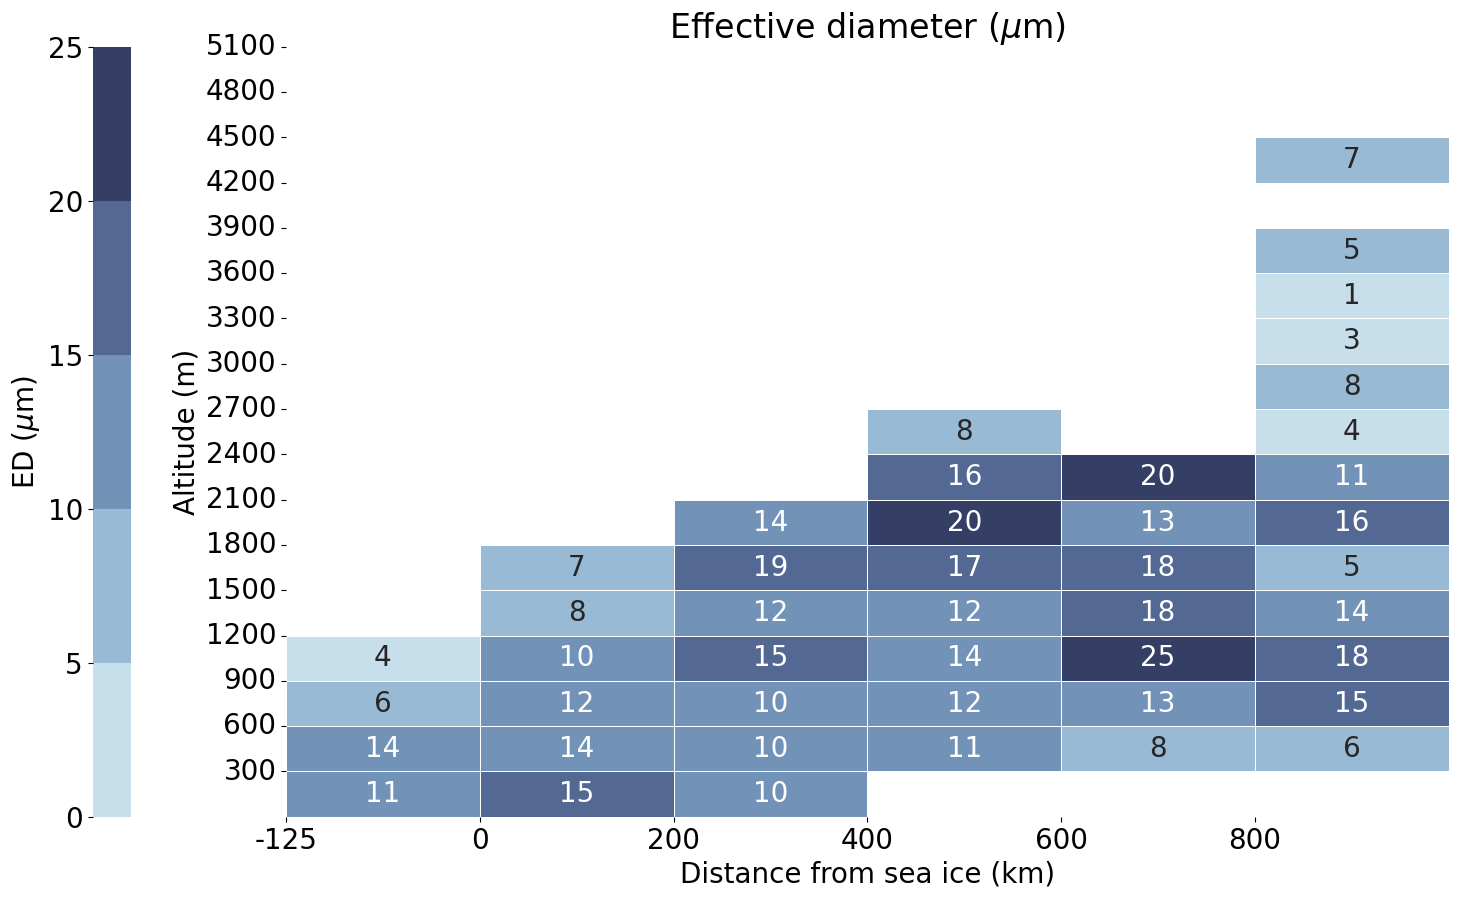

In [119]:
# Heatplot of CDP droplet size (Effective diameter)
# y-axis: altitude
# cdp_size_mean_df,cdp_size_std_df

cdp_size_mean_df = create_distribution_df(ds_incloud_lmp['ED'],'dist_bin','altitude_bin','mean',val=0, mask=incloud_mask)
cdp_size_std_df = create_distribution_df(ds_incloud_lmp['ED'],'dist_bin','altitude_bin','std',val=0, mask=incloud_mask)


ed_labels_dict = {
    'xax_lab':'Distance from sea ice (km)',
    'yax_lab':'Altitude (m)',
    'cbar_lab':'ED ($\mu$m)'
}

savefile = save_path + f'ED_heatmap_{d_text}_{sample_rate}s.png'


fig,ax = plt.subplots(figsize=(20, 10))

plot_heatmap_ax(cdp_size_mean_df, ed_labels_dict, ax, mask_na= True, val=0, annot_df = cdp_size_mean_df, counts=False, ss=20, ncol=5)

ax.set_title("Effective diameter ($\mu$m)")

plt.savefig(savefile, bbox_inches='tight')
print(f'Plot is saved to: {savefile}')

plt.show()

1061
[-700 -500 -300 -100  100  300  500]
-700
500
Plot is saved to: /home/ninalar/Documents/MC2/procIslasMicrophy-1/save_images/sample_rate/dist200/MVD100_heatmap_meandiff_dist200_5s.png


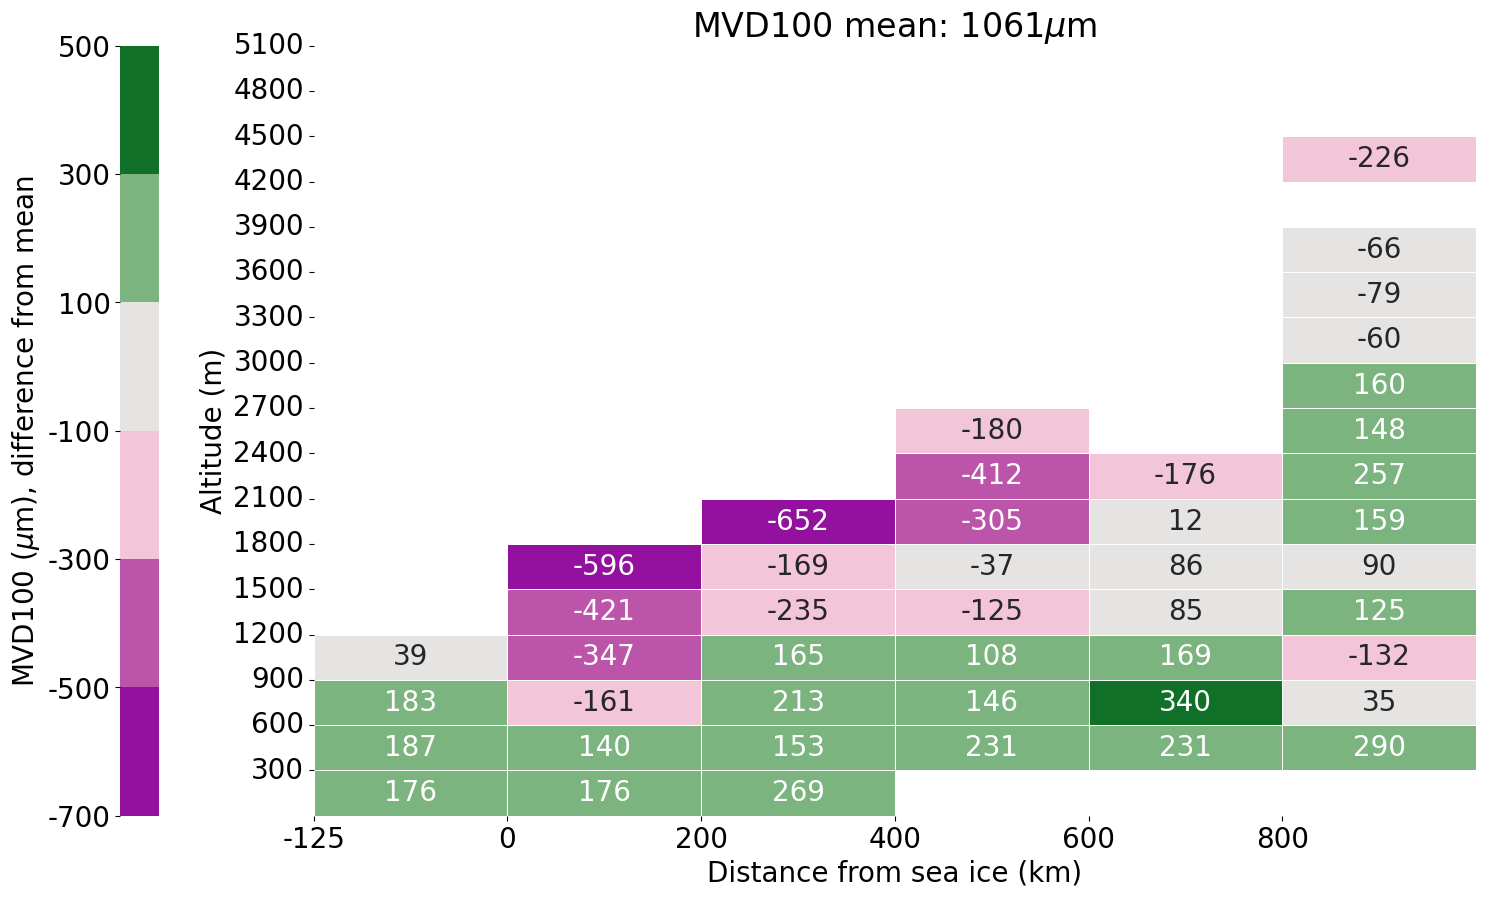

In [120]:
# Heatplot of CIP ice crystal size (MeanVolumeDiameter100) Difference from mean
# y-axis: altitude
# cip_size_mean_df,cip_size_std_df

cip_size_mean_df = create_distribution_df(ds_incloud_lmp['MVD100'],'dist_bin','altitude_bin','mean',val=0, mask=incloud_mask)
cip_size_std_df = create_distribution_df(ds_incloud_lmp['MVD100'],'dist_bin','altitude_bin','std',val=0, mask=incloud_mask)

# calculate difference from mean
mvd_mean = np.nanmean(cip_size_mean_df)
mvd_meandiff_df = cip_size_mean_df-mvd_mean

print(round(mvd_mean))

# Set ticks and colormap to use
t_mvd=np.array([-700,-500,-300,-100,100,300,500])
#col=cmap_discrete, ticks=ts,v_extend=20
#set colorpalette
cmap_mvd = mpl.colors.ListedColormap(
    name="purple_white_green",
    colors=purple_green
)

cip_lab_dict = {
    'xax_lab':'Distance from sea ice (km)',
    'yax_lab':'Altitude (m)',
    'cbar_lab':'MVD100 ($\mu$m), difference from mean'
}

savefile = save_path + f'MVD100_heatmap_meandiff_{d_text}_{sample_rate}s.png'

fig,ax = plt.subplots(figsize=(20, 10))

plot_heatmap_ax(mvd_meandiff_df, cip_lab_dict, ax, mask_na= True, val=0, annot_df = mvd_meandiff_df, counts=False, ss=20,col=cmap_mvd, ticks=t_mvd)

ax.set_title(f"MVD100 mean: {round(mvd_mean)}$\mu$m")

plt.savefig(savefile, bbox_inches='tight')
print(f'Plot is saved to: {savefile}')

plt.show()

ticks not given
Plot is saved to: /home/ninalar/Documents/MC2/procIslasMicrophy-1/save_images/sample_rate/dist200/MVD100_heatmap_dist200_5s.png


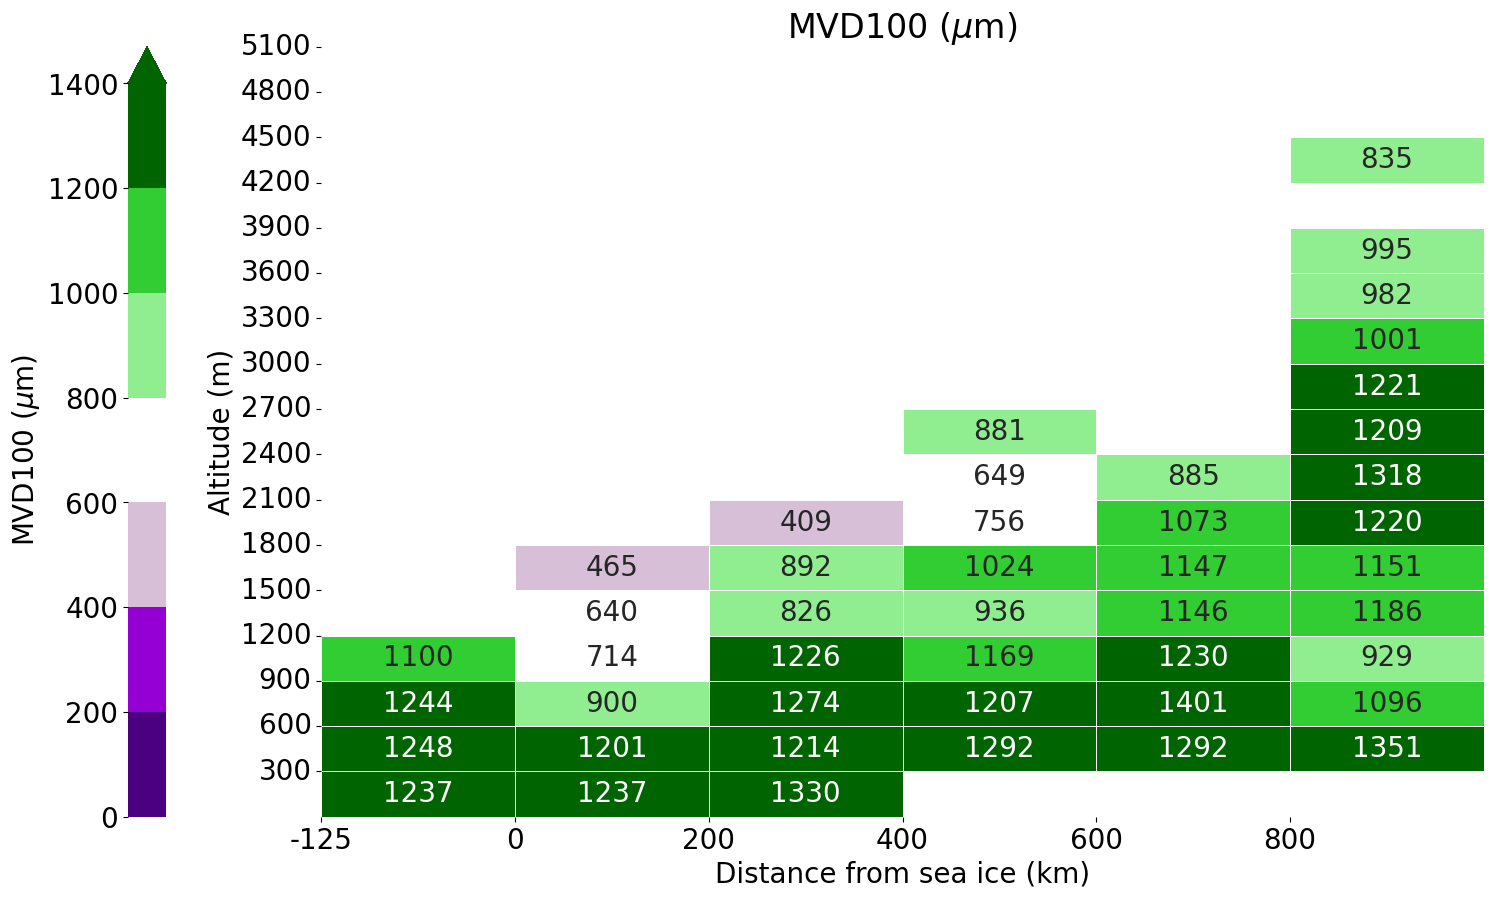

In [121]:
# Heatplot of CIP ice crystal size (MeanVolumeDiameter100)
# y-axis: altitude
# cip_size_mean_df,cip_size_std_df

cip_size_mean_df = create_distribution_df(ds_incloud_lmp['MVD100'],'dist_bin','altitude_bin','mean',val=0, mask=incloud_mask)
cip_size_std_df = create_distribution_df(ds_incloud_lmp['MVD100'],'dist_bin','altitude_bin','std',val=0, mask=incloud_mask)


cip_lab_dict = {
    'xax_lab':'Distance from sea ice (km)',
    'yax_lab':'Altitude (m)',
    'cbar_lab':'MVD100 ($\mu$m)'
}

savefile = save_path + f'MVD100_heatmap_{d_text}_{sample_rate}s.png'

fig,ax = plt.subplots(figsize=(20, 10))

plot_heatmap_ax(cip_size_mean_df, cip_lab_dict, ax, mask_na= True, val=0, annot_df = cip_size_mean_df, v_extend=1400, counts=False, ss=20,ncol=7,col='PurpleGreen')

ax.set_title("MVD100 ($\mu$m)")

plt.savefig(savefile, bbox_inches='tight')
print(f'Plot is saved to: {savefile}')

plt.show()

# Number concentration plots 

ticks not given
Plot is saved to: /home/ninalar/Documents/MC2/procIslasMicrophy-1/save_images/sample_rate/dist200/NT100_incloud_alt_dist200_5s.png


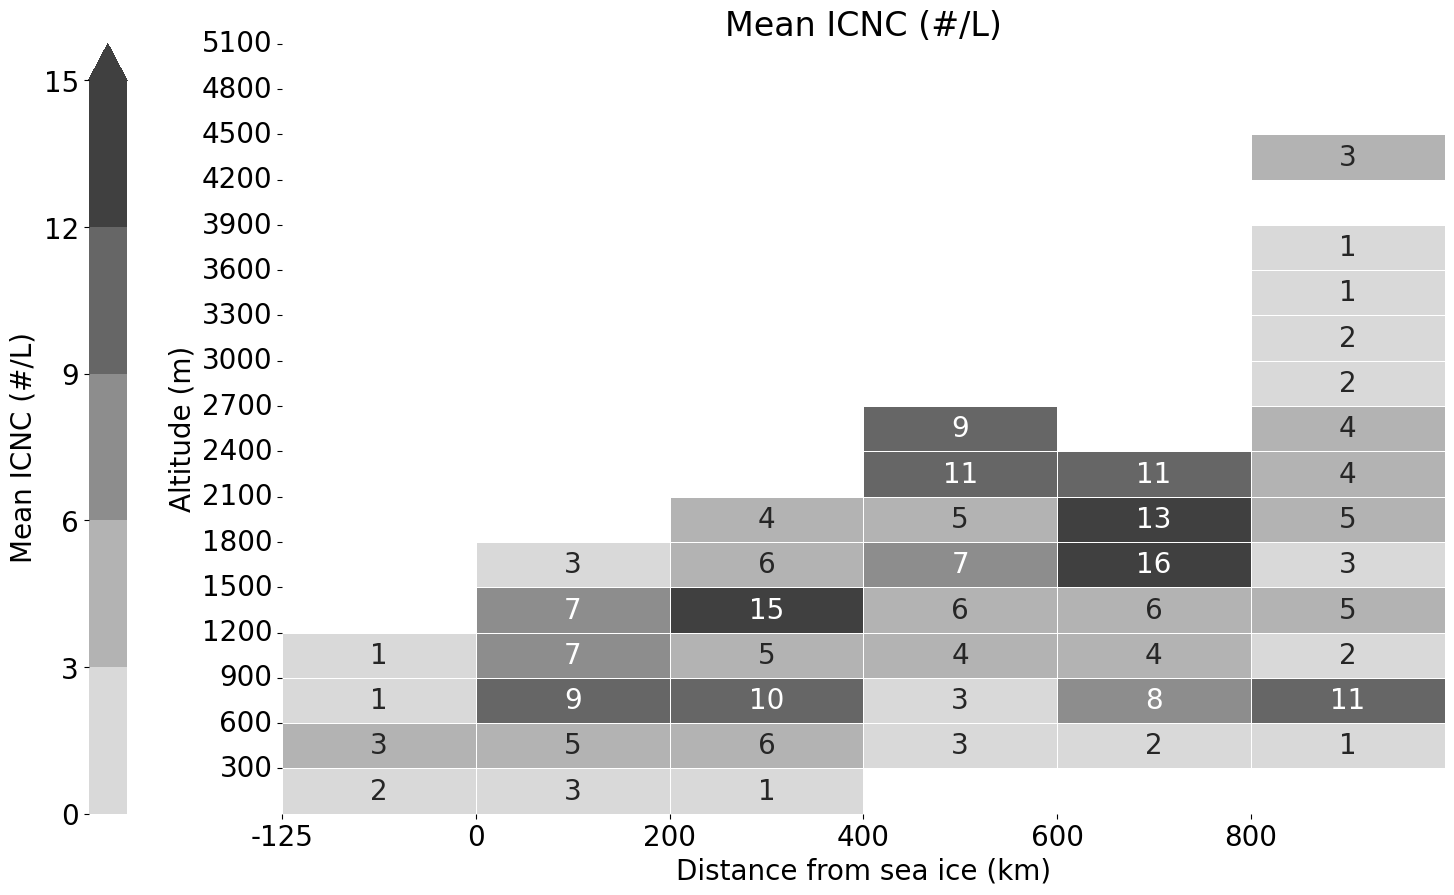

In [122]:
# Heatplot of ICNC (Ice crystal number concentration)
# y-axis: altitude

icnc_mean_df = create_distribution_df(ds_incloud_lmp['NT100'],'dist_bin','altitude_bin','mean',val=0, mask=incloud_mask)
icnc_std_df = create_distribution_df(ds_incloud_lmp['NT100'],'dist_bin','altitude_bin','std',val=0, mask=incloud_mask)
# recalculate to #/L
icnc_mean_df = icnc_mean_df/1000
icnc_std_df = icnc_std_df/1000


icnc_lab_dict = {
    'xax_lab':'Distance from sea ice (km)',
    'yax_lab':'Altitude (m)',
    'cbar_lab':'Mean ICNC (#/L)'
}

savefile = save_path + f'NT100_incloud_alt_{d_text}_{sample_rate}s.png'

fig,ax = plt.subplots(figsize=(20, 10))

plot_heatmap_ax(icnc_mean_df, icnc_lab_dict, ax, mask_na= True, val=0, annot_df = icnc_mean_df, counts=False, ss=20, col='Grey',ncol=5, v_extend=15)

ax.set_title("Mean ICNC (#/L)")

plt.savefig(savefile, bbox_inches='tight')
print(f'Plot is saved to: {savefile}')

plt.show()

ticks not given
Plot is saved to: /home/ninalar/Documents/MC2/procIslasMicrophy-1/save_images/sample_rate/dist200/cdnc_incloud_alt_dist200_5s.png


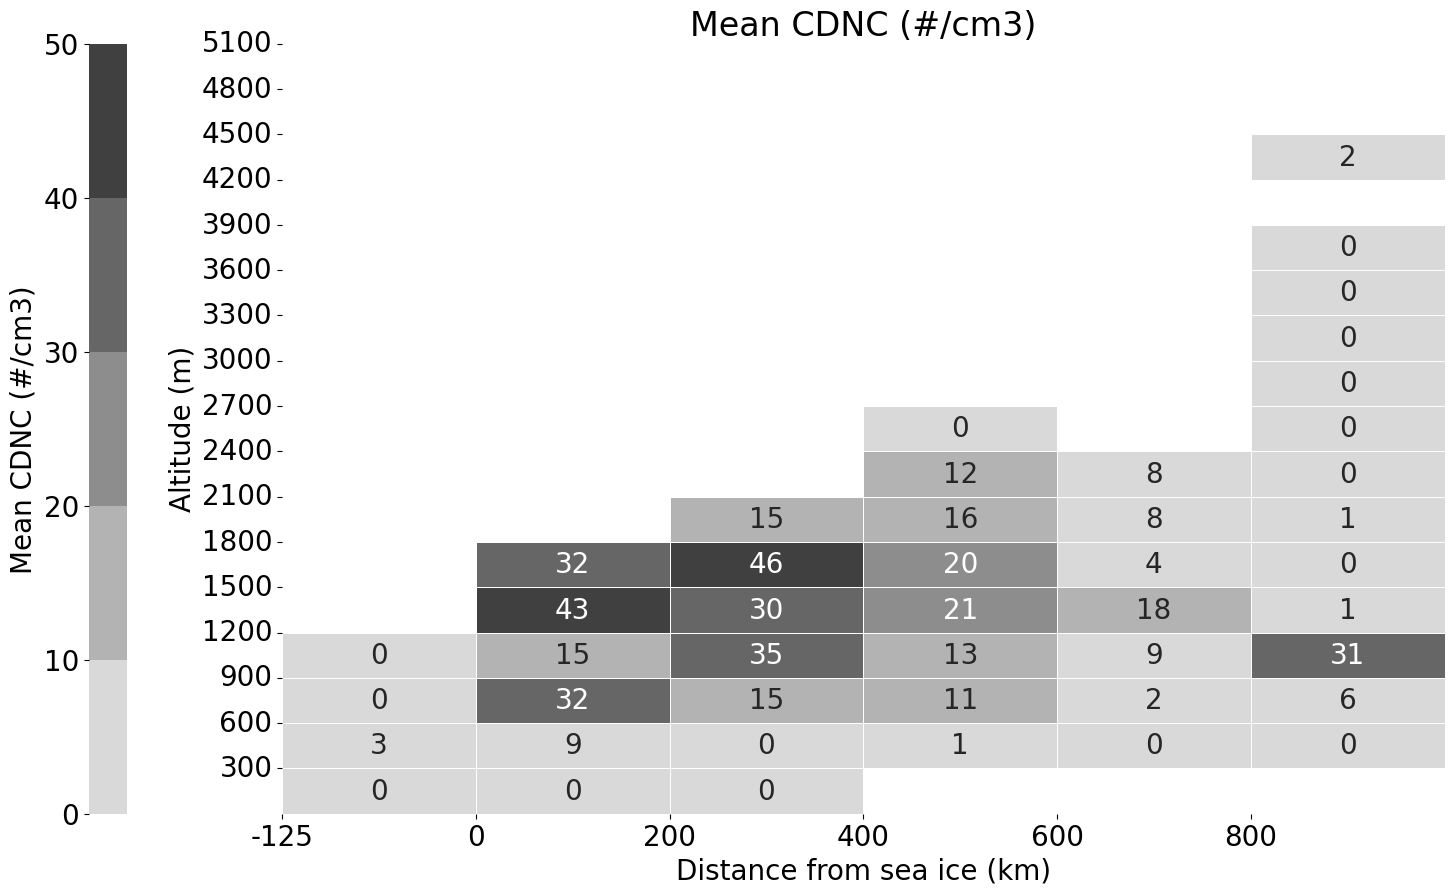

In [123]:
# Heatplot of ICNC (Ice crystal number concentration)
# y-axis: altitude
# changed to using calc instead of corr
cdnc_mean_df = create_distribution_df(ds_incloud_lmp['Number Conc calc'],'dist_bin','altitude_bin','mean',val=0, mask=incloud_mask)
cdnc_std_df = create_distribution_df(ds_incloud_lmp['Number Conc calc'],'dist_bin','altitude_bin','std',val=0, mask=incloud_mask)

cdnc_lab_dict = {
    'xax_lab':'Distance from sea ice (km)',
    'yax_lab':'Altitude (m)',
    'cbar_lab':'Mean CDNC (#/cm3)'
}

savefile = save_path + f'cdnc_incloud_alt_{d_text}_{sample_rate}s.png'

fig,ax = plt.subplots(figsize=(20, 10))

plot_heatmap_ax(cdnc_mean_df, cdnc_lab_dict, ax, mask_na= True, val=0, annot_df = cdnc_mean_df, counts=False, ss=20,col='Grey', ncol=5, v_extend=50)

ax.set_title("Mean CDNC (#/cm3)")

plt.savefig(savefile, bbox_inches='tight')
print(f'Plot is saved to: {savefile}')

plt.show()

# Water content plots

In [124]:
# Grouping and means for LWC, IWC and TWC

# LWC
data_groupedx = ds_incloud_lmp['LWC calc'].groupby('dist_bin')
data_groupedxy = data_groupedx.map(lambda group: group.groupby('altitude_bin').mean())
lwc_mean_df = data_groupedxy.to_dataframe().unstack() 
lwc_mean_df = lwc_mean_df.T.reset_index(level=0, drop = True) # - transpose to get altitude on y-axis - reset index and drop outer index(base_time)
lwc_mean_df = lwc_mean_df.reindex(bin_labels, fill_value=np.nan).iloc[::-1] # fill with 0 - reverse order of altitudes

# IWC
data_groupedx = ds_incloud_lmp['IWC100'].groupby('dist_bin')
data_groupedxy = data_groupedx.map(lambda group: group.groupby('altitude_bin').mean())
iwc_mean_df = data_groupedxy.to_dataframe().unstack() 
iwc_mean_df = iwc_mean_df.T.reset_index(level=0, drop = True) # - transpose to get altitude on y-axis - reset index and drop outer index(base_time)
iwc_mean_df = iwc_mean_df.reindex(bin_labels, fill_value=np.nan).iloc[::-1] # fill with 0 - reverse order of altitudes

# TWC
data_groupedx = ds_incloud_lmp['TWC'].groupby('dist_bin')
data_groupedxy = data_groupedx.map(lambda group: group.groupby('altitude_bin').mean())
twc_mean_df = data_groupedxy.to_dataframe().unstack() 
twc_mean_df = twc_mean_df.T.reset_index(level=0, drop = True) # - transpose to get altitude on y-axis - reset index and drop outer index(base_time)
twc_mean_df = twc_mean_df.reindex(bin_labels, fill_value=np.nan).iloc[::-1] # fill with 0 - reverse order of altitudes


ticks not given
Plot is saved to: /home/ninalar/Documents/MC2/procIslasMicrophy-1/save_images/sample_rate/dist200/IWC_heatmap_dist200_5s.png


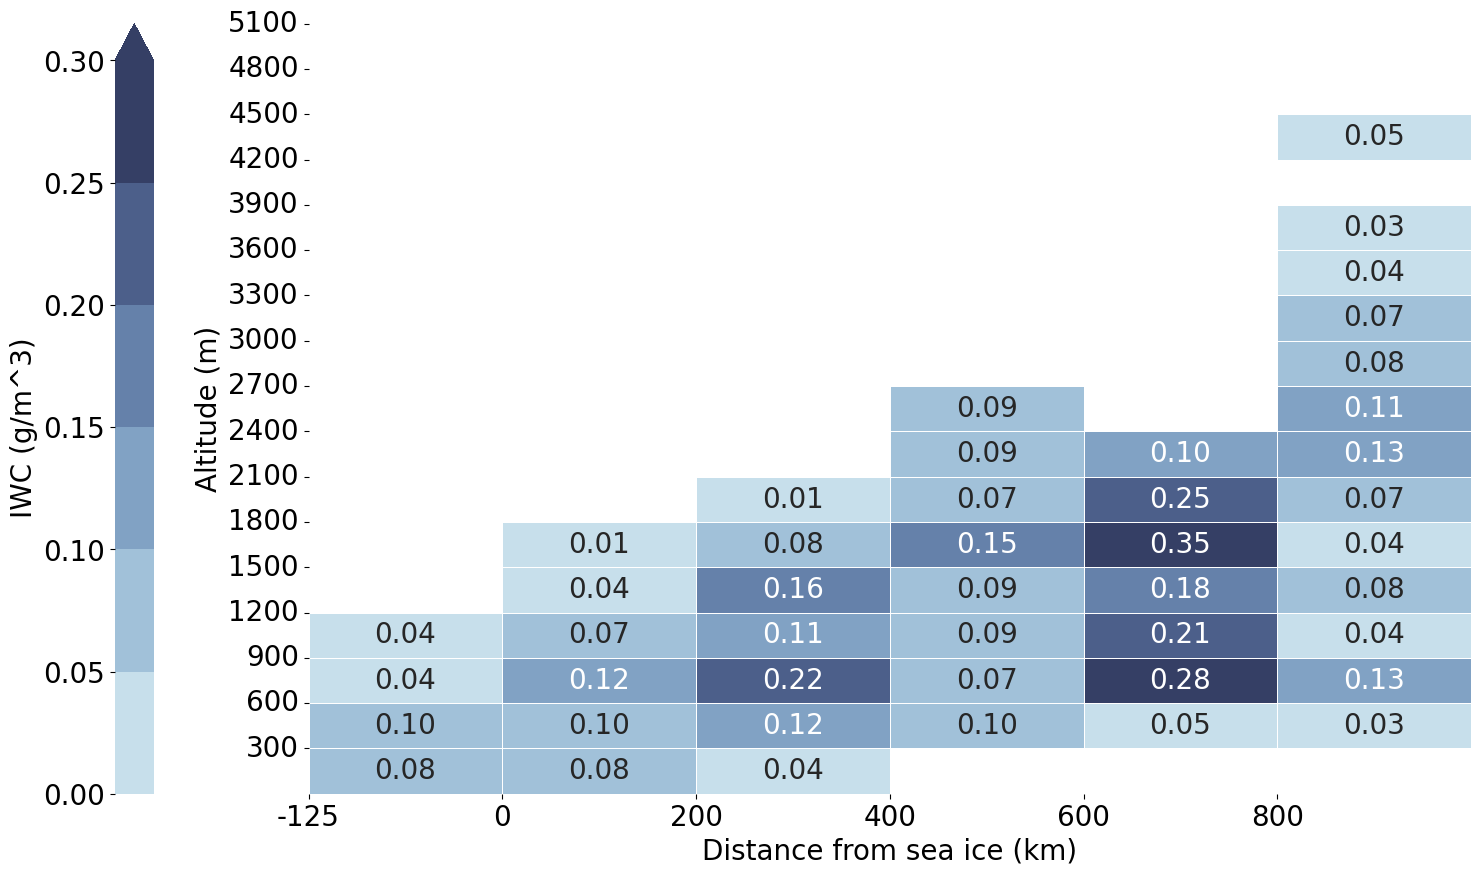

In [125]:
# Heatplot of IWC100 
# y-axis: altitude

iwc_lab_dict = {
    'xax_lab':'Distance from sea ice (km)',
    'yax_lab':'Altitude (m)',
    'cbar_lab':'IWC (g/m^3)'
}

savefile = save_path + f'IWC_heatmap_{d_text}_{sample_rate}s.png'


fig,ax = plt.subplots(figsize=(20, 10))

plot_heatmap_ax(iwc_mean_df, iwc_lab_dict, ax, mask_na= True, val=2, annot_df = iwc_mean_df, counts=False, ss=20, ncol=6, v_extend=0.3)

plt.savefig(savefile, bbox_inches='tight')
print(f'Plot is saved to: {savefile}')

plt.show()

ticks not given
Plot is saved to: /home/ninalar/Documents/MC2/procIslasMicrophy-1/save_images/sample_rate/dist200/LWC_heatmap_dist200_5s.png


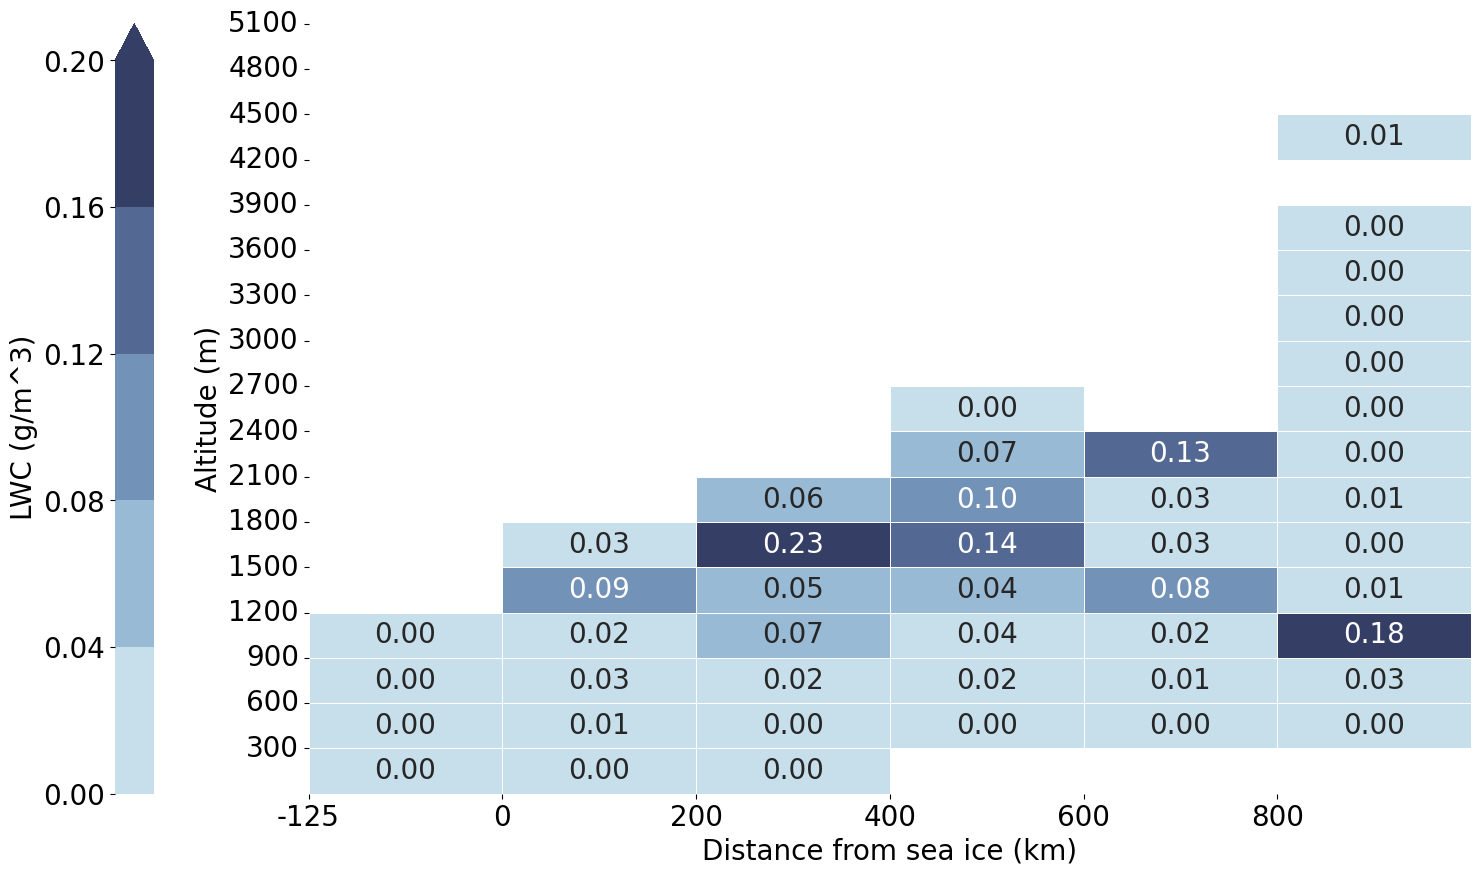

In [126]:
# Heatplot of LWC (LWC)
# y-axis: altitude
# cip_size_mean_df,cip_size_std_df

lwc_lab_dict = {
    'xax_lab':'Distance from sea ice (km)',
    'yax_lab':'Altitude (m)',
    'cbar_lab':'LWC (g/m^3)'
}

savefile = save_path + f'LWC_heatmap_{d_text}_{sample_rate}s.png'


fig,ax = plt.subplots(figsize=(20, 10))

plot_heatmap_ax(lwc_mean_df, lwc_lab_dict, ax, mask_na= True, val=2, annot_df = lwc_mean_df, counts=False, ss=20,ncol=5, v_extend=0.2)


plt.savefig(savefile, bbox_inches='tight')
print(f'Plot is saved to: {savefile}')

plt.show()

ticks not given
Plot is saved to: /home/ninalar/Documents/MC2/procIslasMicrophy-1/save_images/sample_rate/dist200/TWC_heatmap_dist200_5s.png


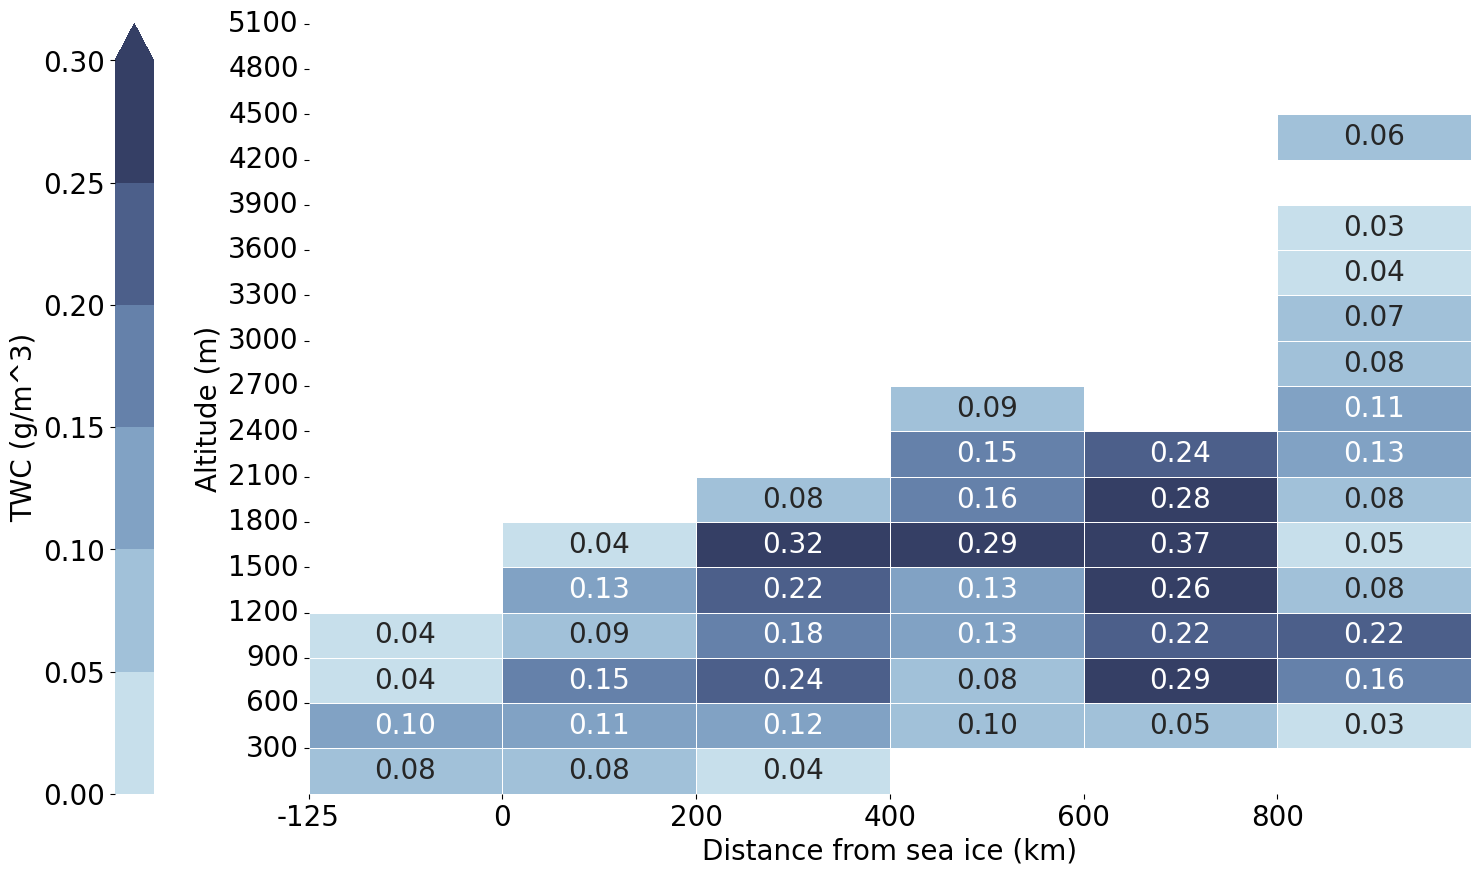

In [127]:
# Heatplot of TWC (IWC100 + LWC)
# y-axis: altitude
# cip_size_mean_df,cip_size_std_df

twc_lab_dict = {
    'xax_lab':'Distance from sea ice (km)',
    'yax_lab':'Altitude (m)',
    'cbar_lab':'TWC (g/m^3)'
}

savefile = save_path + f'TWC_heatmap_{d_text}_{sample_rate}s.png'

fig,ax = plt.subplots(figsize=(20, 10))

plot_heatmap_ax(twc_mean_df, twc_lab_dict, ax, mask_na= True, val=2, annot_df = twc_mean_df, counts=False, ss=20,ncol=6, v_extend=0.3)


plt.savefig(savefile, bbox_inches='tight')
print(f'Plot is saved to: {savefile}')

plt.show()

# Joint ice/water plots

ticks not given
[-10  -5  -1   1   5  10  15  20]
-10
20
ticks not given
ticks not given
[-700 -500 -300 -100  100  300  500]
-700
500
ticks not given


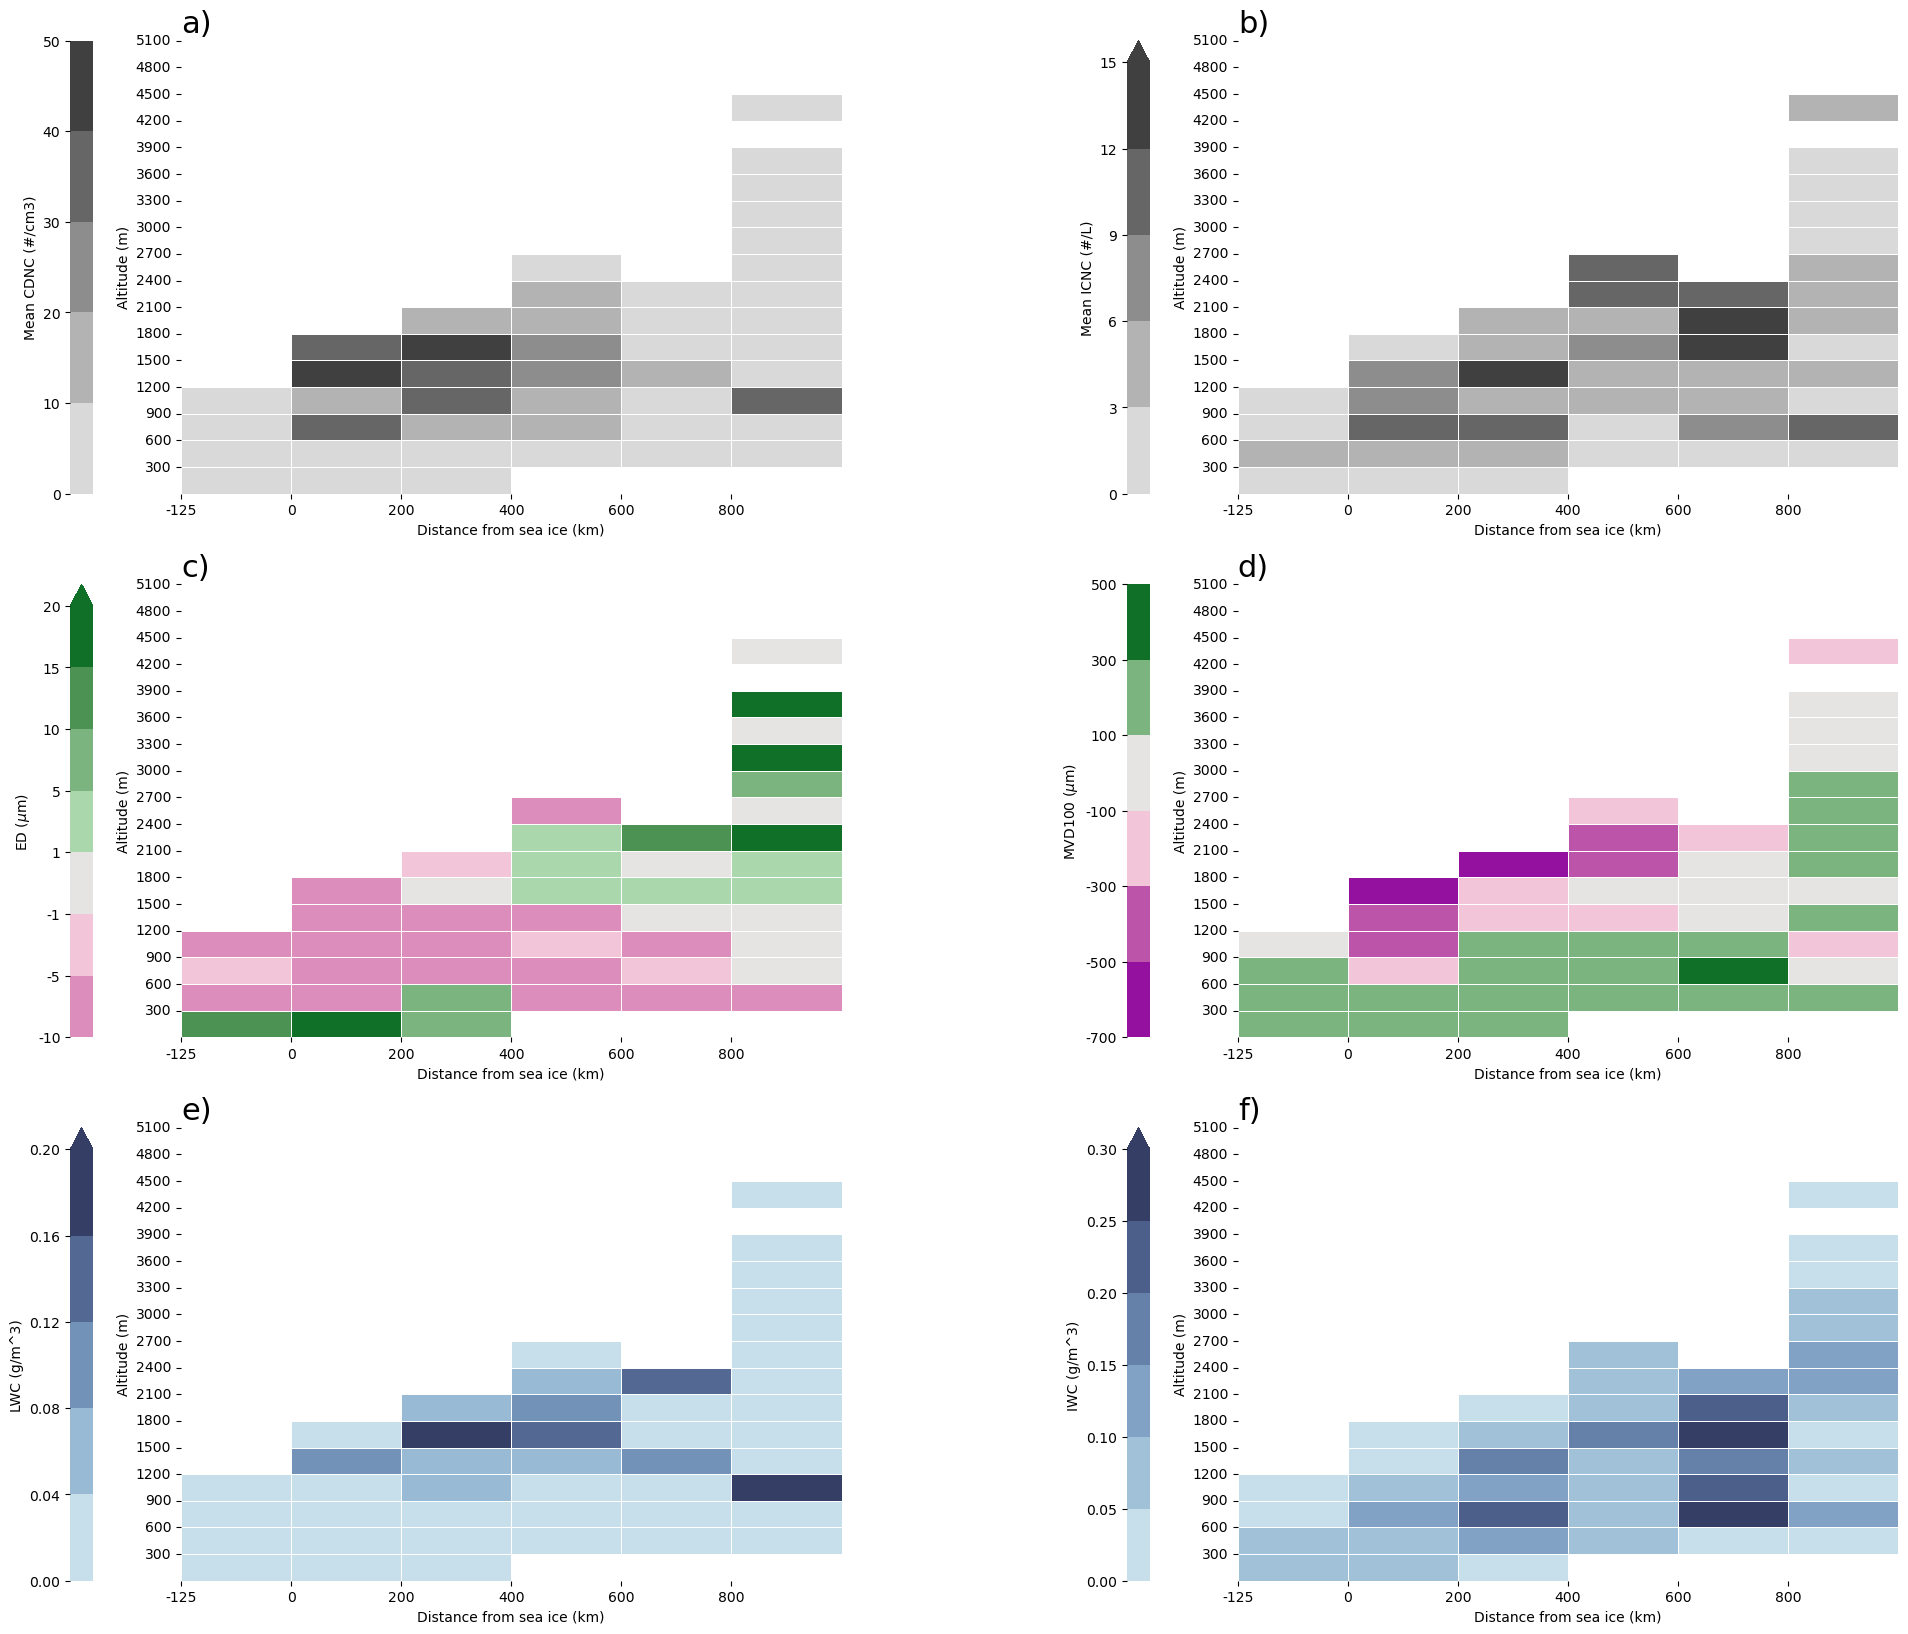

In [129]:
fig, ax = plt.subplots(3,2, figsize=(25, 20))

# --- The water plots
# CDNC
plot_heatmap_ax(cdnc_mean_df, cdnc_lab_dict, ax[0,0], mask_na=True, col='Grey', ncol=5, v_extend=50)
ax[0,0].set_title('a)', loc='left',fontdict={'fontsize': ss})

# ED
#plot_heatmap_ax(ed_df, ed_labels_dict, ax[1,0], mask_na=True,col='PurpleGreen',ncol=5,v_extend=50)
plot_heatmap_ax(ed_meandiff_df, ed_labels_dict, ax[1,0], mask_na= True, col=cmap_ed, ticks=t_ed,v_extend=20)
ax[1,0].set_title('c)', loc='left',fontdict={'fontsize': ss})

# LWC
plot_heatmap_ax(lwc_mean_df, lwc_lab_dict, ax[2,0], mask_na=True, val=2, ncol=5, v_extend=0.2)
ax[2,0].set_title('e)', loc='left',fontdict={'fontsize': ss})


# --- The ice plots
# ICNC
plot_heatmap_ax(icnc_mean_df, icnc_lab_dict, ax[0,1], mask_na=True,col='Grey',ncol=5, v_extend=15)
ax[0,1].set_title('b)', loc='left',fontdict={'fontsize': ss})

# MVD
#plot_heatmap_ax(cip_size_mean_df, cip_lab_dict, ax[1,1], mask_na=True,col='PurpleGreen',ncol=7, v_extend=1400)
plot_heatmap_ax(mvd_meandiff_df, cip_lab_dict, ax[1,1], mask_na= True, col=cmap_mvd, ticks=t_mvd)
ax[1,1].set_title('d)', loc='left',fontdict={'fontsize': ss})

# IWC
plot_heatmap_ax(iwc_mean_df, iwc_lab_dict, ax[2,1], mask_na=True, val=2, ncol=6,v_extend=0.3)
ax[2,1].set_title('f)', loc='left',fontdict={'fontsize': ss})


savefile = save_path + f'ice_liquid_joined_heatmap_{d_text}_{sample_rate}s.png'
plt.savefig(savefile, bbox_inches='tight')

In [ ]:
mask = (ds_incloud_lmp['T']<-33).compute()

test= ds_incloud_lmp.where(mask, drop=True)

test


# SLF per flight and separating different "regions"

In [ ]:
#all flights
flights = np.unique(ds_incloud_lmp['islasid'].values)
ss=20
count = len(flights)

# get x tick-labels from distance bin values
dists = np.unique(ds_incloud_lmp['dist_bin'].values)
dists[0]=-125 # first one should be the lowest distance value



# --- Set up figure
fig, ax = plt.subplots(1,1, figsize=(20, 10))

# set the spans covering the region
# over ice is the same for all dist_bin_sizes
plt.axvspan(-125,0,facecolor='blue', alpha=0.05)
plt.text(-120,4500,'Over ice', fontsize=ss)

# how many bins the second region should cover
if dist_bin_size==125:
    sep=3
elif dist_bin_size==200:
    sep=2
elif dist_bin_size==250:
    sep=2
elif dist_bin_size==300:
    sep=2

plt.axvspan(0,dist_bin_size*sep, facecolor='green',  alpha=0.05)
plt.text(5,4500,'Stratiform off ice', fontsize=ss)
plt.axvspan(dist_bin_size*sep,dists[-1], facecolor='red', alpha=0.05)
plt.text(dist_bin_size*sep+5,4500,'Stratiform deepening into convective', fontsize=ss)


# the mature convective is the same for all dist_bin sizes
plt.axvspan(dists[-1],dists[-1]+dist_bin_size, facecolor='lightslategrey', alpha=0.05)
plt.text(dists[-1]+5,4500,'Convective', fontsize=ss)

for i, flight in enumerate(flights):
    mask = (ds_incloud_lmp['islasid']==flight).compute()
    flight_ds=ds_incloud_lmp.where(mask, drop=True)

    color = c_flights[flight]
    size = flight_ds['SLF']*5

    # WC plots
    ax.scatter(flight_ds['distance_from_ice'], flight_ds['alt'],marker='o',alpha=0.4, s=size, color=color, label=flight)


ax.set_ylabel(f'Altitude ({ds_incloud_lmp['alt'].attrs['units']})', size=ss)
ax.set_xlabel(f'Distance from sea ice ({ds_incloud_lmp['distance_from_ice'].attrs['units']})', size=ss)
ax.set_xticks(dists)
ax.set_xlim(dists[0], dists[-1]+dist_bin_size)
ax.set_yticks(np.arange(0,5000,300))
ax.set_ylim(0)
ax.tick_params(axis='both', labelsize=ss)


leg = ax.legend(loc='upper right',bbox_to_anchor=(1.15,1), fontsize=ss)

# create legend for SLF
size_max = np.nanmax(ds_incloud_lmp['SLF'].values)*0.16 # 100%
size_min = np.nanmin(ds_incloud_lmp['SLF'].values) # 0%
size_min = 1*0.16 # 0%

first_element = Line2D([0], [0], color='k', label='Color: Flight')

legend_elements = [Line2D([0], [0], color='k', label='Size: SLF value'),
                    Line2D([0], [0], marker='o', color='k', label='SLF=100%',
                          markerfacecolor='k', markersize=size_max, linestyle='None'),
                   Line2D([0], [0], marker='o', color='k', label='SLF=1%',
                          markerfacecolor='k', markersize=size_min, linestyle='None'),
                    Line2D([0], [0], color='k', label='Opacity: # obs'),
                    Line2D([0], [0], marker='o', color='k', label='Many obs.',
                          markerfacecolor='k', markersize=size_max, alpha=1,linestyle='None'),
                    Line2D([0], [0], marker='o', color='k', label='Few obs.',
                          markerfacecolor='k', markersize=size_max, alpha=0.2,linestyle='None')      ]

# Add new elements and their labels to the existing legend
handles, labels = ax.get_legend_handles_labels()  # Get existing handles and labels
#first add the first element
handles = [first_element] + handles
labels = [first_element.get_label()] + labels
#then add the different elements
handles += legend_elements  # Append new legend elements
labels += [element.get_label() for element in legend_elements]  # Append labels for the new elements

# Set the updated legend with the new handles and labels
leg = ax.legend(handles=handles, labels=labels, loc='upper right', bbox_to_anchor=(1.22, 1), fontsize=ss)


ax.grid(True)
#fig.suptitle('SLF divided by flight', size=ss)


savefile = save_path + f'SLF_pr_flight_{sample_rate}s.png'
plt.savefig(savefile, bbox_inches='tight')

In [ ]:
size_min

In [ ]:
# Cloud regions without the flight SLF (for 200 km dist bin!)

# --- Set up figure
fig, ax = plt.subplots(1,1, figsize=(20, 10))

# set the spans covering the region
# (same as in plot above)
plt.axvspan(-200,0,facecolor='blue', alpha=0.05)
plt.text(-195,4500,'Over ice', fontsize=ss)
plt.axvspan(0,400, facecolor='green',  alpha=0.05)
plt.text(5,4500,'Stratiform off ice', fontsize=ss)
plt.axvspan(400,800, facecolor='red', alpha=0.05)
plt.text(405,4350,'Stratiform deepening \n into convective', fontsize=ss)
plt.axvspan(800,1000, facecolor='lightslategrey', alpha=0.05)
plt.text(805,4500,'Convective', fontsize=ss)

   
ax.set_ylabel(f'Altitude ({flight_ds['alt'].attrs['units']})', size=ss)
ax.set_xlabel(f'Distance from sea ice ({flight_ds['distance_from_ice'].attrs['units']})', size=ss)
ax.set_xticks([0,200,400,600,800,1000])
ax.set_xlim(-200,1000)
ax.set_yticks(np.arange(0,5000,300))
ax.set_ylim(0)
ax.tick_params(axis='both', labelsize=ss)
ax.grid(True)

savefile = save_path + f'cloud_areas.png'
plt.savefig(savefile, bbox_inches='tight')

In [ ]:
# Over ice

# --- Set up figure
fig, ax = plt.subplots(1,1, figsize=(9.3, 16))

plt.axvspan(-125,0,facecolor='blue', alpha=0.05)
plt.text(-120,4500,'Over ice', fontsize=ss)

ax.set_ylabel(f'Altitude ({flight_ds['alt'].attrs['units']})', size=ss)
ax.set_xlabel(f'Distance from sea ice ({flight_ds['distance_from_ice'].attrs['units']})', size=ss)
ax.set_xticks(dists)
ax.set_xlim(dists[0], dists[1])
ax.set_yticks(np.arange(0,5000,300))
ax.set_ylim(0)
ax.tick_params(axis='both', labelsize=ss)
ax.grid(True)

savefile = save_path + f'images_over_sea_ice.png'
plt.savefig(savefile, bbox_inches='tight')

In [ ]:
# Stratiform off ice

# --- Set up figure
fig, ax = plt.subplots(1,1, figsize=(19, 16))

plt.axvspan(0,dist_bin_size*sep, facecolor='green',  alpha=0.05)
plt.text(5,4500,'Stratiform off ice', fontsize=ss)
   
ax.set_ylabel(f'Altitude ({flight_ds['alt'].attrs['units']})', size=ss)
ax.set_xlabel(f'Distance from sea ice ({flight_ds['distance_from_ice'].attrs['units']})', size=ss)
ax.set_xticks(dists)
ax.set_xlim(dists[1], dist_bin_size*sep)
ax.set_yticks(np.arange(0,5000,300))
ax.set_ylim(0)
ax.tick_params(axis='both', labelsize=ss)
ax.grid(True)

savefile = save_path + f'images_stratiform_off_ice.png'
plt.savefig(savefile, dpi=100)


In [ ]:
# Stratiform deepening into convenctive

# --- Set up figure
fig, ax = plt.subplots(1,1, figsize=(28.5, 16))

plt.axvspan(dist_bin_size*sep,dists[-1], facecolor='red', alpha=0.05)
plt.text(dist_bin_size*sep+5,4500,'Stratiform deepening into convective', fontsize=ss)
   
ax.set_ylabel(f'Altitude ({flight_ds['alt'].attrs['units']})', size=ss)
ax.set_xlabel(f'Distance from sea ice ({flight_ds['distance_from_ice'].attrs['units']})', size=ss)
ax.set_xticks(dists)
ax.set_xlim(dist_bin_size*sep,dists[-1])
ax.set_yticks(np.arange(0,5000,300))
ax.set_ylim(0)
ax.tick_params(axis='both', labelsize=ss)
ax.grid(True)

savefile = save_path + f'images_stratiform_deepening.png'
plt.savefig(savefile, bbox_inches='tight',dpi=100)

In [ ]:
# Mature convective

# --- Set up figure
fig, ax = plt.subplots(1,1, figsize=(28.5, 16))

plt.axvspan(dists[-1],dists[-1]+dist_bin_size, facecolor='lightslategrey', alpha=0.05)
plt.text(dists[-1]+5,4500,'Convective', fontsize=ss)

ax.set_ylabel(f'Altitude ({flight_ds['alt'].attrs['units']})', size=ss)
ax.set_xlabel(f'Distance from sea ice ({flight_ds['distance_from_ice'].attrs['units']})', size=ss)
ax.set_xticks(dists)
ax.set_xlim(dists[-1],dists[-1]+dist_bin_size)
ax.set_yticks(np.arange(0,5000,300))
ax.set_ylim(0)
ax.tick_params(axis='both', labelsize=ss)
ax.grid(True)

savefile = save_path + f'images_convective.png'
plt.savefig(savefile, bbox_inches='tight')

### Times for extracting CIP images


REMEMBER THAT YOU HAVE NOT FIXED THE CONNECTION TO DISTANCE BIN SIZE SELECTION BELOW THIS SUBHEADER

In [ ]:
np.unique(ds_incloud_lmp['dist_bin'].values)

In [ ]:

mask_dist = (ds_incloud['dist_bin']==250).compute()
test_ds = ds_incloud.where(mask_dist, drop=True)

In [ ]:
# plot the Liquid water content for thebox with the high amount

mask_dist = (ds_incloud['dist_bin']==250).compute()
test_ds = ds_incloud.where(mask_dist, drop=True)
mask_alt = (test_ds['altitude_bin']== 1650).compute()
test_ds = test_ds.where(mask_alt,drop=True)

# --- Set up figure
fig, ax = plt.subplots(1,1, sharex=True,figsize=(15,5))

ax.scatter(ds_incloud['time'], ds_incloud['LWC calc'], c ='r', label='CDP LWC') #changed form LWC calc
ax.set_ylabel(f'LWC ({ds_incloud['LWC calc'].attrs['unit']})') #changed from LWC calc
ax.legend()
ax.grid(True)

plt.show

In [ ]:
# at what times are we at what distances from sea ice? (Set up for 200 km distance bins)
# distances
#mask = (ds_incloud_lmp['dist_bin']==-200).compute() 
#mask = (ds_incloud['dist_bin']==0).compute() 
mask = (ds_incloud['dist_bin']==200).compute() 
#mask = (ds_incloud['dist_bin']==400).compute() 
#mask = (ds_incloud['dist_bin']==600).compute() 
#mask = (ds_incloud['dist_bin']==800).compute() 

test = ds_incloud_lmp.where(mask, drop=True)

# altitudes
altmask1 = (test['altitude_bin']==150).compute()
alt150 = test.where(altmask1,drop=True)

altmask2 = (test['altitude_bin']==450).compute()
alt450 = test.where(altmask2,drop=True)

altmask3 = (test['altitude_bin']==750).compute()
alt750 = test.where(altmask3,drop=True)

altmask4 = (test['altitude_bin']==1050).compute()
alt1050 = test.where(altmask4,drop=True)

altmask5 = (test['altitude_bin']==1350).compute()
alt1350 = test.where(altmask5,drop=True)

altmask6 = (test['altitude_bin']==1650).compute()
alt1650 = test.where(altmask6,drop=True)

altmask7 = (test['altitude_bin']==1950).compute()
alt1950 = test.where(altmask7,drop=True)

altmask8 = (test['altitude_bin']==2250).compute()
alt2250 = test.where(altmask8,drop=True)

altmask9 = (test['altitude_bin']==2550).compute()
alt2550 = test.where(altmask9,drop=True)

altmask10 = (test['altitude_bin']==2850).compute()
alt2850 = test.where(altmask10,drop=True)

altmask11 = (test['altitude_bin']==3150).compute()
alt3150 = test.where(altmask11,drop=True)

altmask12 = (test['altitude_bin']==3450).compute()
alt3450 = test.where(altmask12,drop=True)

altmask13 = (test['altitude_bin']==3750).compute()
alt3750 = test.where(altmask13,drop=True)

altmask14 = (test['altitude_bin']==4050).compute()
alt4050 = test.where(altmask14,drop=True)

altmask15 = (test['altitude_bin']==4350).compute()
alt4350 = test.where(altmask15,drop=True)

altmask16 = (test['altitude_bin']==4650).compute()
alt4650 = test.where(altmask16,drop=True)

altmask17 = (test['altitude_bin']==4950).compute()
alt4950 = test.where(altmask17,drop=True)



In [ ]:
#alt150['time'].values
#alt450['time'].values
#alt750['time'].values
alt1050['time'].values
#alt1350['time'].values
#alt1650['time'].values
#alt1950['time'].values
#alt2250['time'].values
#alt2550['time'].values
#alt2850['time'].values
#alt3150['time'].values
#alt3450['time'].values
#alt3750['time'].values
#alt4050['time'].values
#alt4350['time'].values
#alt4650['time'].values
#alt4950['time'].values

# Size distributions

In [ ]:
def cdp_norm_Nt(ds):
    """ Log-normalized particle number per bin for CDP observations

    Parameters
    ----------
    ds
        A xarray.DataSet containing the parameters: 
        -'CDP Bin Particle Count': 
        -'SV': Sample volume
        -'Size': Upper size edge of bin
        -'Bin min': Lower size edge of bin
        This value is already normalized by bin width, but not log-normalized. 
    
    Returns
    -------
    cdp_part_norm
        A xarray.DataArray that contains the log-normalized values of the CIP number concentration

    """
    import numpy as np
    
    # adjust the raw particle count by sample volume
    # log normalize the cdp particle counts to width (Size = upper limit of bin, Bin_min = lower limit of bin)
    # bin units are in micrometers and must be adjusted to m
    ds['CDP count log norm'] = (ds['CDP Bin Particle Count']/ds['SV'])/(np.log(ds['Size'][0]*1.e-6)-np.log(ds['Bin_min'][0]*1.e-6))
    
    return ds


In [ ]:
# Testing dataselections

region_dict = {'over_ice':[-125],
               'strat_off':[0,125,250],
               'strat_off': [375,500,625],
               'convective': [750,875]}


dist_mask = (ds_incloud['dist_bin'].isin(region_dict['over_ice'])).compute()
dist_ds = ds_incloud.where(dist_mask, drop=True)

dist_ds = cdp_norm_Nt(dist_ds)
dist_sum = dist_ds['CDP count log norm'].sum('time') # the sum of particle counts per bin

#np.unique(dist_ds['dist_bin'].values)  # testing which distance bins is chosen

def alt_perc(dist_ds):
    # selecting alt
    # get the data as multiple datasets: separate by altitude bin
    alt_list = np.unique(dist_ds['altitude_bin'].values)

    alt_ds_list = []

    for alt in alt_list:
        #print(alt)
        alt_mask = (dist_ds['altitude_bin']==alt).compute()
        alt_ds = dist_ds.where(alt_mask, drop=True)

        sum_c_perc = alt_ds['CDP count log norm'].sum('time').values/dist_sum.values # the sum of particle counts per bin
        alt_ds_list.append(sum_c_perc)

    # get the percentage of total number of observations per altitude as dataframe
    cdp_alt_perc_df = pd.DataFrame(data=alt_ds_list, index = alt_list, columns=np.unique(dist_ds['Size'].values))

    return cdp_alt_perc_df



In [ ]:
# -- Number concentration hist plot: 
# select one of the distance regions
region_dict = {'over_ice':[-125],
               'strat_off':[0,125,250],
               'strat_deep': [375,500,625],
               'convective': [750,875]}


def plot_NTdist(dist_ds, category, ax, layers=False):
    dist_ds = cdp_norm_Nt(dist_ds)
    # Get the normalized values for plotting (from functions in numb_conc)
    cip_part_norm, cip_median = numb_conc.cip_mean_norm_Nt(dist_ds)
   
    cdp_part_norm_mean=dist_ds['CDP count log norm'].mean('time') 
    cdp_counts, cdp_bins, cdp_patches = ax.hist(dist_ds['Size'][0].values, weights = cdp_part_norm_mean.values, bins=30, label = "CDP", histtype='bar')
    
    
    ax.hist(dist_ds['MIDBINS'][0].values[2:], weights = cip_part_norm.values[2:], bins=61, label = "CIP", color='orange',histtype='bar')
    cip_counts, cip_bins, cip_patches =ax.hist(dist_ds['MIDBINS'][0].values[:3], weights = cip_part_norm.values[:3], bins=3, label = "CIP below 100 $\mu$m", histtype='bar',hatch='x',alpha=0.3,edgecolor='orange', fill=False)
   
    
    if layers == False:
        ax.set_title(f'{category}')
        ax.legend()

        ax.set_ylabel('dN/dlogDp (#/$m^4$)')
        ax.set_xlabel('Size ($\mu$m)')
    
    return cdp_counts, cdp_bins, cdp_patches, cip_counts, cip_bins, cip_patches

fig, ax = plt.subplots(2,4,figsize = (15,10), sharex=True, sharey=True)

# ALL Altitudes
# over sea ice
dist_mask = (ds_incloud['dist_bin'].isin(region_dict['over_ice'])).compute()
dist_si_ds = ds_incloud.where(dist_mask, drop=True)
si_cdp_counts, si_cdp_bins, si_cdp_patches, si_cip_counts, si_cip_bins, si_cip_patches = plot_NTdist(dist_si_ds,'a) Over sea ice', ax[0,0])
cdp_alt_perc_df = alt_perc(dist_ds)

# over stratiform off ice
dist_mask = (ds_incloud['dist_bin'].isin(region_dict['strat_off'])).compute()
dist_st_ds = ds_incloud.where(dist_mask, drop=True)
plot_NTdist(dist_st_ds,'b) Stratiform off ice', ax[0,1])

# over stratiform deepening
dist_mask = (ds_incloud['dist_bin'].isin(region_dict['strat_deep'])).compute()
dist_ic_ds = ds_incloud.where(dist_mask, drop=True)
plot_NTdist(dist_ic_ds,'c) Stratiform deepening', ax[0,2])

# over convective
dist_mask = (ds_incloud['dist_bin'].isin(region_dict['convective'])).compute()
dist_dc_ds = ds_incloud.where(dist_mask, drop=True)
plot_NTdist(dist_dc_ds,'d) Convective', ax[0,3])

# selected altitudes

# stratiform off ice altitudes: 1050-1950
alt_mask = (dist_st_ds['altitude_bin'].isin([1050, 1350, 1650, 1950])).compute()
st_top_ds = dist_st_ds.where(alt_mask, drop=True)
plot_NTdist(st_top_ds,'f) top layers stratiform off ice',ax[1,1])

plt.yscale('log')
plt.xscale('log')
plt.xlim(0,1600)



plt.show()

In [ ]:
alt_mask = (dist_si_ds['altitude_bin']==1350).compute()
alt_si_ds= dist_si_ds.where(alt_mask, drop=True)
alt_si_ds.time.size

In [ ]:

altitudes = np.unique(ds_incloud['altitude_bin'].values)
count=len(altitudes)

fig, ax = plt.subplots(count,1,figsize = (10,15), sharex=True, sharey=True)
fig.subplots_adjust(bottom=0.06,hspace=0)

# over sea ice
dist_mask = (ds_incloud['dist_bin'].isin(region_dict['over_ice'])).compute()
dist_si_ds = ds_incloud.where(dist_mask, drop=True)


#per altitude
#altitudes = [150,  450,  750, 1050]

for i, alt in enumerate(altitudes):
    #print(count-1-i)
    #print(alt)
    
    # select only the data from one altitude
    alt_mask = (dist_si_ds['altitude_bin']==alt).compute()
    alt_si_ds= dist_si_ds.where(alt_mask, drop=True)

    if alt_si_ds.time.size:
        plot_NTdist(alt_si_ds, 'alt', ax[count-1-i], layers=True)

    ax[count-1-i].set_title(f'Alt. {alt-150}-{alt+150}', loc='right',y=0.5)


fig.supylabel('dN/dlogDp (#/$m^4$)')
fig.supxlabel('Size ($\mu$m)')
fig.suptitle('Over sea ice: -125 km to 0 km',y=0.9)

plt.yscale('log')
plt.xscale('log')
plt.xlim(2.9,1600)



plt.show()

In [ ]:
# over statiform
region_dict = {'over_ice':[-125],
               'strat_off':[0,125,250],
               'strat_deep': [375,500,625],
               'convective': [750,875]}

#dist_mask = (ds_incloud['dist_bin'].isin(region_dict['strat_off'])).compute() # select the stratiform data
#dist_st_ds = ds_incloud.where(dist_mask, drop=True)

dist_mask = (ds_incloud['dist_bin']<1000).compute() #drop the two furthest distance bins
dist_use_ds = ds_incloud.where(dist_mask, drop=True)

# get distance bins for subplot settings
#dists = np.unique(dist_st_ds['dist_bin'].values)
dists = np.unique(dist_use_ds['dist_bin'].values)
cols=len(dists)

fig, ax = plt.subplots(count,cols,figsize = (20,15), sharex=True, sharey=True)
fig.subplots_adjust(bottom=0.06,hspace=0,wspace=0)

#per distance
for j, dist in enumerate(dists):
    #per altitude
    # select only the data from one distance
    #d_mask = (dist_st_ds['dist_bin']==dist).compute()
    #dist_ds= dist_st_ds.where(d_mask, drop=True)
    d_mask = (dist_use_ds['dist_bin']==dist).compute()
    dist_ds= dist_use_ds.where(d_mask, drop=True)


    for i, alt in enumerate(altitudes):
        #print(count-1-i)
        #print(alt)
        
        # select only the data from one altitude
        alt_mask = (dist_ds['altitude_bin']==alt).compute()
        alt_ds= dist_ds.where(alt_mask, drop=True)

        if alt_ds.time.size:
            plot_NTdist(alt_ds, 'alt', ax[count-1-i,j], layers=True)

        if 0<len(alt_ds['time'])<20:
            ax[count-1-i,j].text(0.95,0.95,f'#obs: {len(alt_ds['time'])}',transform=ax[count-1-i,j].transAxes,
            horizontalalignment='right',
            verticalalignment='top')



fig.supylabel('dN/dlogDp (#/$m^4$)',x=0.1)
fig.supxlabel('Size ($\mu$m)')
fig.suptitle('Size distributions per altitude/distance bin')

plt.yscale('log')
plt.xscale('log')
plt.xlim(2.9,1600)



plt.show()

In [ ]:
# stacked barplot

import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data for multiple distributions
np.random.seed(42) # for reproducibility
data1 = np.random.normal(loc=50, scale=10, size=1000)
data2 = np.random.normal(loc=60, scale=15, size=1000)
data3 = np.random.normal(loc=45, scale=8, size=1000)

# Combine the data into a list for the hist function
all_data = [data1, data2, data3]

# Define bin edges
n_bins = 30

# Plot the stacked histogram
plt.hist(all_data, n_bins, histtype='bar', stacked=True, label=['Dataset 1', 'Dataset 2', 'Dataset 3'])

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Stacked Histogram of Multiple Datasets')
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.75)

plt.show()

In [ ]:
# histogram for stacked number concentration

# select one of the distance bins
dist_mask = (ds_incloud['dist_bin']==-125).compute() # distance -125
dist_ds = ds_incloud.where(dist_mask, drop=True)


# get the data as multiple datasets: separate by altitude bin
alt_list = np.unique(dist_ds['altitude_bin'].values)

hist_cdp_list=[]
hist_cip_list=[]
nbins_cdp_list=[]
nbins_cip_list=[]

for alt in alt_list:
    print(alt)

    alt_mask = (dist_ds['altitude_bin']==alt).compute()
    alt_ds = dist_ds.where(alt_mask, drop=True)

    # Get the normalized values for plotting (from functions in numb_conc)
    cip_part_norm_mean,cip_part_norm_median = numb_conc.cip_mean_norm_Nt(alt_ds)
    alt_ds = cdp_norm_Nt(alt_ds)
    cdp_part_norm_mean = alt_ds['CDP count log norm'].mean(dim='time')

    # combine the data into a list
    hist_cip_list.append(cip_part_norm_mean.values)
    hist_cdp_list.append(cdp_part_norm_mean.values)

    #get bins for the two
    n_bins_cip = alt_ds['MIDBINS'].values
    n_bins_cdp = alt_ds['Size'].values
    nbins_cip_list.append(n_bins_cip)
    nbins_cdp_list.append(n_bins_cdp)

# first step: make a boxplot based on the new data for the cdp
fig, ax = plt.subplots(figsize = (15,15))

# plot as stacked histogram
#ax.hist(n_bins_cip, weights = hist_cip_list, bins=n_bins_cip, label = alt_list, histtype='bar', stacked=True)
ax.hist(n_bins_cdp, weights = hist_cdp_list, bins=n_bins_cdp, label = alt_list, histtype='bar',stacked=True)

In [ ]:
cip_part_norm_mean

# Aspect ratio plots

In [ ]:
# THe aspect ratio should be nan when there are no particles in the bin
# create mask for the aspect ratio from the counts
# create a mask where the counts are bigger than zero
count_mask = (ds_incloud['COUNTS']>0).compute()

ds_incloud['AR_corrected'] = ds_incloud['MEAN_ASPECTRATIO'].where(count_mask, other=np.nan)

print(ds_incloud['AR_corrected'].values)
ds_incloud['mean_ar_total'] = ds_incloud['AR_corrected'].mean(dim='Vector64', skipna=True, keep_attrs=True)

# Grouping and means for aspect ratop

data_groupedx = ds_incloud['mean_ar_total'].groupby('dist_bin')
data_groupedxy = data_groupedx.map(lambda group: group.groupby('altitude_bin').mean())
ar_mean_df = data_groupedxy.to_dataframe().unstack() 
ar_mean_df = ar_mean_df.T.reset_index(level=0, drop = True) # - transpose to get altitude on y-axis - reset index and drop outer index(base_time)
ar_mean_df = ar_mean_df.reindex(bin_labels, fill_value=np.nan).iloc[::-1] # fill with 0 - reverse order of altitudes
# drop columns 1000 and 1125 due to too few layers
ar_mean_df = ar_mean_df.drop([1000,1125], axis=1)

In [ ]:
# heatmap of aspect ratio
labels_dict = {
    'xax_lab':'Distance from sea ice (km)',
    'yax_lab':'Altitude (m)',
    'cbar_lab':'Mean aspect ratio'
}

savefile = save_path + f'AR_heatmap_{sample_rate}s.png'

fig,ax = plt.subplots(figsize=(20, 10))

plot_heatmap_ax(ar_mean_df, labels_dict, ax, mask_na= True, val=3, annot_df = ar_mean_df, counts=False)


plt.savefig(savefile, bbox_inches='tight')
print(f'Plot is saved to: {savefile}')



In [ ]:

# Aspect ratio scatterplot

# select the data from one of the bins
dbin = 0
# select only one distance bin
bin_mask = (ds_incloud['dist_bin']==dbin).compute()
ds_bin = ds_incloud.where(bin_mask, drop = True)

# get the values to use in scatterplot
AR = ds_bin['MEAN_ASPECTRATIO'].values
sizes = ds_bin['MEAN_ASPECTRATIO'].attrs['Bin_endpoints'][1:]-12.5 # sizes needs to be middle point and not endpoint, and exclude startpoint [0]
# AR corrected to remove zeroes where no particles where found
#AR = ds_bin['AR_corrected'].values
#sizes = ds_bin['AR_corrected'].attrs['Bin_endpoints'][1:]-12.5 # sizes needs to be middle point and not endpoint, and exclude startpoint [0]

alt_bins = ds_bin['altitude_bin'].values


# create a dataframe of AR transposed
df=pd.DataFrame(AR.T)
df.columns = sizes.astype(int) # use sizes as column headers (as int)
df['alt_bin'] = alt_bins

# turn df to long version
df_long = pd.melt(df,
                  id_vars=['alt_bin'],
                  value_vars=sizes.astype(int),
                  var_name='Bin_size',
                  value_name='aspect_ratio')



# plot I want: scatter plot with aspect ratio on y-axis, bin size on x-axis and color by altitude bin
f, ax = plt.subplots(figsize=(20, 10))

#plot text size options
#hs=25
ss=20

ar_plot = ax.scatter(df_long['Bin_size'], df_long['aspect_ratio'], c=df_long['alt_bin'],cmap='tab10', alpha = 0.5)

plt.colorbar(ar_plot, label='altitude bin')
plt.title(f'Sphericity/Aspect ratio in distance bin: {dbin}km', fontsize=ss)
plt.xlabel('Size bin ($\mu$m)')
plt.ylabel('Aspect ratio')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility

plt.tight_layout()  # Adjust layout to make room for x labels 

plt.savefig(save_path + f'testAR_uncorr_{dbin}s.png', bbox_inches='tight')


In [ ]:
#add image to plot
from PIL import Image


# Open an image from a computer 
def open_image_local(path_to_image):
    image = Image.open(path_to_image) # Open the image
    image_array = np.array(image) # Convert to a numpy array
    return image_array # Output

# Open the image from my computer
image = open_image_local('/home/ninalar/Documents/MC2/Figures/images_at_dist_alt/dist500_alt1050_03302022_152434_CIP.png')

image = plt.imread('/home/ninalar/Documents/MC2/Figures/images_at_dist_alt/dist500_alt1050_03302022_152434_CIP.png')

# Humidity plots

In [ ]:
# humidity plot:
# Relevant variables
print(f'{ds['RH1'].attrs['long_name']}:{ds['RH1'].attrs['units']}')
print(f'{ds['HABS1'].attrs['long_name']}:{ds['HABS1'].attrs['units']}')


# Grouping and mean of humidity
data_groupedx = ds_incloud['RH1'].groupby('dist_bin')
data_groupedxy = data_groupedx.map(lambda group: group.groupby('altitude_bin').mean())
rh_mean_df = data_groupedxy.to_dataframe().unstack() 
rh_mean_df = rh_mean_df.T.reset_index(level=0, drop = True) # - transpose to get altitude on y-axis - reset index and drop outer index(base_time)
rh_mean_df = rh_mean_df.reindex(bin_labels, fill_value=np.nan).iloc[::-1] # fill with 0 - reverse order of altitudes

'''
# --- Set up figure
fig, ax = plt.subplots(1,1, figsize=(20, 10))

ax.contour(reorg_heatmap_df)

   
ax.set_ylabel(f'Altitude ({flight_ds['alt'].attrs['units']})', size=ss)
ax.set_xlabel(f'Distance from sea ice ({flight_ds['distance_from_ice'].attrs['units']})', size=ss)
ax.set_xticks(np.arange(-125, 1000, 125))
ax.set_yticks(np.arange(0,5000,300))
ax.tick_params(axis='both', labelsize=ss)
ax.legend(fontsize=ss)
ax.grid(True)
fig.suptitle('SLF divided by flight', size=ss)


savefile = save_path + f'SLF_pr_flight_{sample_rate}s.png'
plt.savefig(savefile, bbox_inches='tight')
'''
rh_mean_df

In [ ]:
# heatmaps per distance bin

# - make 1 plot per distance bin. for 250 km distance bins that is 6 plots
# - each heatmap should be slf vs temperature (so the "count_df"s needs to be calculated over ds_incloud filtered by distance bin)

# get the list of distance bins
dists = np.unique(ds_incloud['dist_bin'].values)

# filter ds_incloud on first dists
i=5
dist_mask = (ds_incloud['dist_bin']==dists[i]).compute()
ds_dist = ds_incloud.where(dist_mask, drop = True)

# Group by SLF: 5% and temperature 4 degrees and create df for heatmap
grouped_slf_data = ds_dist['base_time'].groupby('slf_bin')
count_slf_data = grouped_slf_data.map(lambda group: group.groupby('temp_bin').count())
# reorganize data before plotting heatmap
# - turn into dataframe 
count_slf_df = pd.DataFrame(count_slf_data.values) # get only the values (to avoid base_time)
row_n = count_slf_data.slf_bin.values # get slfbin values for index
count_slf_df = count_slf_df.set_axis(row_n,axis=0)
column_n = count_slf_data.temp_bin.values # get temp bin values for columns
count_slf_df = count_slf_df.set_axis(column_n,axis=1)


count_slf_df = count_slf_df.iloc[::-1] # flip y-axis
#print(count_slf_df)


f, ax = plt.subplots(figsize=(20, 10))

#plot text size options
hs=25
ss=20

pl = sns.heatmap(count_slf_df, annot=True, fmt=".0f", cmap='Blues', ax=ax, 
            cbar_kws={"label": "SLF", "location" : "left"},
            linewidths=0.5, annot_kws={'size':ss}, vmin=0)


pl.set_xlabel('5 $^\circ$C Temperature bins', fontsize=ss) # when using distance
pl.set_ylabel('SLF (5% bins)', fontsize=ss)


# colorbar options
cbar = pl.collections[0].colorbar  # Get the colorbar from the heatmap
cbar.ax.tick_params(labelsize=ss)  # Change the size of the colorbar ticks
cbar.set_label('Number of observations', fontsize=ss)  # Change colorbar label size


# ticklabel adjustments
xlab = pl.get_xticklabels() 
pl.set_xticklabels(labels = xlab, size=ss)
ylab = pl.get_yticklabels()
#for label in ylab:
#    label.set_text(label.get_text().replace('.0', '')) # remove all '.0'
pl.set_yticklabels(labels = ylab, size = ss, rotation=0)

plt.title(f'Distance from sea-ice: {dists[i]}km', fontsize=20)
plt.savefig(save_path + f'slf_incloud_temp_distcat{dists[i]}_{sample_rate}s.png', bbox_inches='tight')


## Single flight plots

In [ ]:
# single flight overview plot
# the flight path, the distribution of observations and the temperature viw altitude plot on top
# the altitude/observations on bottom

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# --- Dataselection

islasid = 'IS22-08'

proj= ccrs.NorthPolarStereo()

#filter the three main dataframes on the flight
ds_incloud_flight = ds_incloud.where(ds_incloud['islasid']==islasid, drop = True)
ds_relevant_flight = ds_relevant.where(ds_relevant['islasid']==islasid, drop = True)
ds_all_flight = ds.where(ds['islasid']== islasid, drop = True)

full_extent = [ds.lon.values.min()-5, ds.lon.values.max()+1, ds.lat.values.min()-3, ds.lat.values.max()+3]
   
# create dataframe with the data to visualize in the separate plots:
# lat_bins is the same as for the full dataset
    
count_df = create_counts(ds_incloud_flight, 'lat',lat_bins) # counts for incloud selection
#set 0 to nan
count_df = count_df.replace(0,np.nan)
   
count_rel_df = create_counts(ds_relevant_flight, 'lat',lat_bins) # counts for all observations
# Calculating the percentage of total observations per category that is in cloud:
dist_df = ((count_df/count_rel_df)*100)



In [ ]:
# sea ice for flight
date = pd.to_datetime(ds_incloud_flight.time[0].values) # get the date and format it correctly
date = date.strftime('%Y%m%d')

sic_ds = xr.open_dataset(sic_path  + date + sic_file_struct)
sic_ds.close()

# rename data variable and update attributes
sic_ds['sic'] = sic_ds['__xarray_dataarray_variable__'].assign_attrs(units="Percent", description="Sea Ice Concentration")
sic_ds = sic_ds.drop_vars(['__xarray_dataarray_variable__'])

# add some attributes
sic_ds.attrs['date'] = date
sic_ds.attrs['file'] = f'asi-n6250-{date}-5.4_regridded.nc'

In [ ]:
# get sic distances
sic_select = sic_ds.where(sic_ds.sic>25, drop=True)

sic_select

In [ ]:


# --- Set up the figure with Gridspec
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(2, 5, wspace=0.1)  # 2 rows, 5 columns

# -- Row 1: 3 plots

# - Left plot: map
ax_map = fig.add_subplot(gs[0,0:1], projection=ccrs.NorthPolarStereo())
col_flight = plot_flight_obs_single(full_extent, ds_all_flight, ds_incloud_flight, sic_ds, ax_map)
# add north arrow
#north_arrow(ax=ax_map, location="upper right", rotation={"crs": ccrs.NorthPolarStereo(), "reference":"center"})

#windrose axis
wrax = inset_axes(ax_map, width='25%', height='25%',
                  loc="upper right",
                  axes_class = WindroseAxes)

ws = ds_incloud_flight.WS.values
wd = ds_incloud_flight.WD.values

wrax.bar(wd, ws, normed=True)

wrax.tick_params(labelleft=False) #, labelbottom=False)

# - Middle plot: heatplot of where the observations are
# Create the heatmap on the left (2/3 of the width)
ax_heatmap = fig.add_subplot(gs[0,1:4])

#plot text size options
hs=15
ss=10

pl = sns.heatmap(count_df, annot=True, fmt=".0f", cmap='Blues', ax=ax_heatmap, 
                cbar_kws={"label": "# cloud observations","location":"left"},
                linewidths=0.5, annot_kws={'size':ss}, vmax=400)
    
ax_heatmap.set_title(f'{islasid}: # observations per latitude/altitude box ({len(ds_incloud_flight.time)} incloud obs. total)')
    
pl.set_xlabel('Latitude ($^\circ$N)',fontsize=ss)
pl.set_ylabel('Altitude (m)', fontsize=ss)
pl.get_yaxis().set_visible(False) # only show x-axis, the other plot shows the y-axis

# add overlines
# Create overlay plot
ax_lines = fig.add_axes(ax_heatmap.get_position(), frameon=False)
ax_lines.set_xlim(79,70)
ax_lines.set_ylim(0,4500)
yticks = np.linspace (0,4500,300)
ax_lines.set_yticks(altitude_bins)
ax_lines.axes.get_xaxis().set_visible(False) # only show the y-axis, the other plot shows the xaxis (this shows the altitudes better.)
ax_lines.set_ylabel('Altitude (m)', fontsize=ss)
ax_lines.tick_params(labelsize=ss)

# Plot the limit between the two regions
ax_lines.axvline(lat_bands[1], ls='--', c='k', lw=2)
ax_lines.text(lat_bands[1] + 1, altitude_bins[-2], f"{lat_bands[1]:.2f}°",c='k', fontsize=ss)

# temperature plot
ax_temp = fig.add_subplot(gs[0,4])

# Temperature southern and northern marine
# -- southern marine: mean and std
# Select variables to plot
sel_vars = ['altitude_bin', 'T']

df_incloud_flight = ds_incloud_flight[sel_vars].to_dataframe().reset_index()
t_mean = df_incloud_flight.groupby('altitude_bin')['T'].mean()
t_std = df_incloud_flight.groupby('altitude_bin')['T'].std()

#expand the t_mean and the t_std
new_index = pd.Index((altitude_bins+150).astype(int))
t_mean_expanded = t_mean.reindex(new_index)
t_std_expanded = t_std.reindex(new_index)

# the comma is to get the first element of the list returned
mn, = ax_temp.plot(t_mean_expanded, t_mean_expanded.index, label = 'Mean', lw=2,color = 'green')
std = ax_temp.fill_betweenx(t_mean_expanded.index, t_mean_expanded+t_std_expanded, t_mean_expanded-t_std_expanded, facecolor='green', alpha=0.2, label='Std')
ax_temp.grid()
ax_temp.legend()
ax_temp.tick_params(axis='both', which='major', labelsize=ss)
ax_temp.set_ylabel('Altitude (m)', fontsize = ss)
ax_temp.yaxis.set_label_position("right")
ax_temp.set_xlabel('In-cloud temperature ($^\circ$C)', fontsize = ss)

#get and set limits
t_max = t_mean.max()+1
t_min = t_mean.min()-1
ax_temp.set_xlim([t_min, t_max])

ax_temp.yaxis.tick_right()
ax_temp.set_yticks(altitude_bins)
ax_temp.set_ylim((0,5100))

# Row 2: 2 plots
ax_altobs = fig.add_subplot(gs[1,0:5])
ax_altobs.plot(ds_all_flight['time'], ds_all_flight['alt'], c='k', alpha = 0.5, label = 'Altitude')
ax_altobs.scatter(ds_incloud_flight['time'],ds_incloud_flight['alt'], c=col_flight, label = 'Incloud observation')

ax_altobs.xaxis.set_major_formatter(formatter) # only show time on x-axis
ax_altobs.set_ylabel('Altitude (meter)', color = 'k')
ax_altobs.tick_params(axis='y', labelcolor='k')
ax_altobs.legend(title=f'Flight: {islasid}')
ax_altobs.grid(True)

axt=ax_altobs.twinx() # second axses for temperature
axt.set_ylabel('Temperature ($^\circ$C)', color='g')
axt.plot(ds_all_flight['time'], ds_all_flight['T'], c ='g', label='Temperature')
axt.yaxis.set_inverted(True) # temperature axis inverted for readability
axt.tick_params(axis='y', labelcolor='g')

fig.savefig(save_path+f'FlightOverview_{islasid}.png') # Save to

# Satellite, ice age and windrose plot

In [ ]:
# Modis information
modis_dictionary = {'IS22-02':'MOD021KM.A2022081.1125.nc',   # closest full coverage (obs from 11:39:01 to 14:29:56)
                    'IS22-03':'MOD021KM.A2022083.1115.nc',   # closest full coverage (obs from 10:28:59 to 11:10:49)
                    'IS22-04':'MOD021KM.A2022083.1430.nc',   # closest full incloud coverage (obs from 13:09:34 to 14:33:59)
                    'IS22-05':'MOD021KM.A2022085.1100.nc',   # closest full coverage (obs from 09:48:50 to 11:35:35)
                    'IS22-06':'MOD021KM.A2022085.1100.nc',   # closest full coverage (obs from 14:51:19 to 16:53:29)
                    'IS22-07':'MOD021KM.A2022088.1130.nc',   # closest full coverage (obs from 10:02:56 to 11:43:31)
                    'IS22-08':'MOD021KM.A2022089.1035.nc',   # closest full coverage (obs from 15:05:34 to 15:50:54)
                    'IS22-10':'MOD021KM.A2022093.1150.nc',   # closest full coverage (obs from 09:07:47 to 10:56:17)
                    'IS22-11':'MOD021KM.A2022093.1150.nc'    # closest full coverage (obs from 12:38:49 to 14:56:39)
                    } # dictionary over satellite images to use

folder = "/home/ninalar/Documents/MC2/procIslasMicrophy/sea_ice_satellite/" # Modis-files folder

In [ ]:
for islasid in np.unique(ds_incloud['islasid'].values):
#for islasid in ['IS22-08']:
    #print(islasid)
    ds_incloud_flight = ds_incloud.where(ds_incloud['islasid']==islasid, drop = True)
    ds_all_flight = ds.where(ds['islasid']== islasid, drop = True)
    date = ds_incloud_flight['time'][0].values
    dato = date.astype('datetime64[D]')
    day_of_year = (date.astype('datetime64[D]') - np.datetime64(str(date.astype('datetime64[Y]')))).astype('timedelta64[D]').astype(int) + 1

    # testing for times and day of year for selecting closest MODIS image
    #print(f'Day of year: {day_of_year}')

    min_t = pd.Timestamp(ds_incloud_flight.time.min().values)
    max_t = pd.Timestamp(ds_incloud_flight.time.max().values)
    
    min_time = f'{min_t.hour:02d}:{min_t.minute:02d}'
    max_time = f'{max_t.hour:02d}:{max_t.minute:02d}'
    

    #--- get satellite information for the flight
    filename = modis_dictionary[islasid] # get filename of closest modis from dictionary
    #print(filename)

    ds_modis = xr.open_dataset(folder + filename)
    ds_modis_i = ds_modis.isel(time=0) # Choose the first time 

    # get the time information
    modis_t = pd.Timestamp(ds_modis_i.time.values)
    modis_time = f'{modis_t.hour:02d}:{modis_t.minute:02d}'

    #--- get sea ice information
    # sea ice for flight
    date = pd.to_datetime(ds_incloud_flight.time[0].values) # get the date and format it correctly
    date = date.strftime('%Y%m%d')

    sic_ds = xr.open_dataset(sic_path  + date + sic_file_struct)
    sic_ds.close()

    # rename data variable and update attributes
    sic_ds['sic'] = sic_ds['__xarray_dataarray_variable__'].assign_attrs(units="Percent", description="Sea Ice Concentration")
    sic_ds = sic_ds.drop_vars(['__xarray_dataarray_variable__'])

    # add some [attributes
    sic_ds.attrs['date'] = date
    sic_ds.attrs['file'] = f'asi-n6250-{date}-5.4_regridded.nc'
    # get sic distances
    sic_select = sic_ds.where(sic_ds.sic>25, drop=True)

    #-- plot together
    fig = plt.figure(figsize=(20, 15))
    ax_map = fig.add_subplot(projection=ccrs.NorthPolarStereo(central_longitude=20))

    # plot satellite image 
    cb = ax_map.pcolormesh(ds_modis_i.lon, ds_modis_i.lat, ds_modis_i.radiance.isel(band=0), transform=ccrs.PlateCarree(), cmap="gray", vmax=150,zorder=0)

    # plot the Flight path and the sea-ice edge border for the given flight

    col_flight, handles, labels = plot_flight_obs_single(full_extent, ds_all_flight, ds_incloud_flight, sic_ds, ax_map)

    # Plot the windrose
    wrax = inset_axes(ax_map, width='25%', height='25%',
                    loc="upper right",
                    axes_class = WindroseAxes)

    ws = ds_incloud_flight.WS.values
    wd = ds_incloud_flight.WD.values

    wrax.bar(wd, ws, normed=True)
    wrax.tick_params(labelleft=False)
    wrax.tick_params(axis='x', colors='red')
    for tick in wrax.get_xticklabels():
        tick.set_fontsize(16)
        tick.set_fontweight('bold')


    # Create custom legend handles for the two titles
    title1 = Line2D([0], [0], color='none', label=f'{islasid} - {dato}\nincloud times: {min_time} - {max_time} \nMODIS image time: {modis_time}', lw=0)  # Empty handle for title

    # Combine the handles and labels
    comb_handles = [title1] + handles
    comb_labels = [title1.get_label()] + labels
    # Add legend to the plot
    l = ax_map.legend(handles=comb_handles, labels=comb_labels, loc='lower left',framealpha=1, fontsize=16)
  
  
    fig.savefig(save_path+f'FlightModisIce_{islasid}.png', dpi=100, bbox_inches='tight')


In [ ]:
# Get only the figure with the map and the wind-rose

fig = plt.figure(figsize=(15, 10))
ax_map = fig.add_subplot(projection=ccrs.NorthPolarStereo())

if len(file)==1: # only plot satellite image if it exists 
    cb = ax_map.pcolormesh(ds_modis_i.lon, ds_modis_i.lat, ds_modis_i.radiance.isel(band=0), transform=ccrs.PlateCarree(), cmap="gray", vmax=150,zorder=0)

# plot the Flight path and the sea-ice edge border for the given flight
col_flight = plot_flight_obs_single(full_extent, ds_all_flight, ds_incloud_flight, sic_ds, ax_map)

# Plot the windrose
wrax = inset_axes(ax_map, width='25%', height='25%',
                  loc="upper right",
                  axes_class = WindroseAxes)

ws = ds_incloud_flight.WS.values
wd = ds_incloud_flight.WD.values

wrax.bar(wd, ws, normed=True)
wrax.tick_params(labelleft=False)


#fig.savefig(save_path+f'FlightModisIce_{islasid}.png')


In [ ]:
# Plot with satellite image, map and wind direction for the flight

# --- Set up the figure with Gridspec
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(1, 3, wspace=0.1)  # 1 rows, 3 columns

# -- Satellite plot
ax_sat = fig.add_subplot(gs[0], projection=ccrs.NorthPolarStereo())

if len(file)==1: # only plot satellite image if it exists 
    cb = ax_sat.pcolormesh(ds_modis_i.lon, ds_modis_i.lat, ds_modis_i.radiance.isel(band=0), transform=ccrs.PlateCarree(), cmap="gray", vmax=150)

fl = ax_sat.plot(ds_all_flight.lon, ds_all_flight.lat, transform = ccrs.PlateCarree(), c=col_flight, lw=4, label=islasid)

#plt.colorbar(cb, label="band 1 [W m-2 micron-1 sr-1]")
ax_sat.set_extent(full_extent, crs=ccrs.PlateCarree())  # limit area
ax_sat.gridlines()
ax_sat.add_feature(cfeature.COASTLINE)
ax_sat.add_feature(cfeature.BORDERS, linewidth=2)
ax_sat.legend(loc='lower left', fontsize= 11)

# -- Map plot
ax_map = fig.add_subplot(gs[1], projection=ccrs.NorthPolarStereo())
col_flight = plot_flight_obs_single(full_extent, ds_all_flight, ds_incloud_flight, sic_ds, ax_map)
# add north arrow
north_arrow(ax=ax_map, location="upper right", rotation={"crs": ccrs.NorthPolarStereo(), "reference":"center"})

# -- Windrose plot
ax_wind=fig.add_subplot(gs[2], axes_class=WindroseAxes)

ws = ds_incloud_flight.WS.values
wd = ds_incloud_flight.WD.values

ax_wind.bar(wd, ws, normed=True)
ax_wind.set_title("Wind Rose in-cloud observations")
ax_wind.tick_params(labelleft=False) #, labelbottom=False)
ax_wind.legend(title="Wind Speed (m/s)", fontsize=10,loc='best', bbox_to_anchor=(0.5,-0.5,0.5,0.5))

#stuff to remove whitespace
#plt.tight_layout(pad=0.1)

#fig.savefig(save_path+f'Flight_Modis_Wind{islasid}.png') # Save to
plt.show()

In [ ]:
# single versions of the plots above

# --- Plot with satellite image
fig = plt.figure(figsize=(20, 10))
gs = GridSpec(1, 2, figure=fig)
ax = fig.add_subplot(gs[0,0], projection=ccrs.NorthPolarStereo())

if len(file)==1: # only plot satellite image if it exists 
    cb = ax.pcolormesh(ds_modis_i.lon, ds_modis_i.lat, ds_modis_i.radiance.isel(band=0), transform=ccrs.PlateCarree(), cmap="gray", vmax=150)

fl = ax.plot(ds_all_flight.lon, ds_all_flight.lat, transform = ccrs.PlateCarree(), c=col_flight, lw=4, label=islasid)

#plt.colorbar(cb, label="band 1 [W m-2 micron-1 sr-1]")
ax.set_extent(full_extent, crs=ccrs.PlateCarree())  # limit area
ax.gridlines()
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=2)
ax.legend(loc='lower left', fontsize= 11)

plt.tight_layout()

if len(file)==1: # only save if satellite image exists 
    fig.savefig(save_path+f'Flight_Modis_{islasid}.png',bbox_inches='tight', pad_inches=0, dpi=100)

plt.show()

# ---Plot with just map
fig = plt.figure(figsize=(20, 10))
gs = GridSpec(1, 2, figure=fig)
ax = fig.add_subplot(gs[0,0], projection=ccrs.NorthPolarStereo())

col_flight = plot_flight_obs_single(full_extent, ds_all_flight, ds_incloud_flight, sic_ds, ax)
# add north arrow
north_arrow(ax=ax, location="upper right", rotation={"crs": ccrs.NorthPolarStereo(), "reference":"center"})

plt.tight_layout(pad=0.1)

fig.savefig(save_path+f'Flight_path{islasid}.png',bbox_inches='tight', pad_inches=0)
plt.show()

# ---Plot withwind direction for the flight

fig = plt.figure(figsize=(20, 10))
gs = GridSpec(1, 2, figure=fig)
ax = fig.add_subplot(gs[0,0], axes_class=WindroseAxes)

ws = ds_incloud_flight.WS.values
wd = ds_incloud_flight.WD.values

ax.bar(wd, ws, normed=True)
ax.set_title("Wind Rose in-cloud observations")
ax.tick_params(labelleft=False) #, labelbottom=False)
ax.legend(title="Wind Speed (m/s)", fontsize=10,loc='best', bbox_to_anchor=(0.5,-0.5,0.5,0.5))

plt.tight_layout(pad=0.1)

fig.savefig(save_path+f'Flight_Wind{islasid}.png',bbox_inches='tight', pad_inches=0) # Save to
plt.show()

In [ ]:
# plot with observation overview
# --- Set up the figure with Gridspec
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(1, 5, wspace=0)  # 1 rows, 5 columns


# - Middle plot: heatplot of where the observations are
# Create the heatmap on the left (2/3 of the width)
ax_heatmap = fig.add_subplot(gs[0:3])

#plot text size options
hs=15
ss=10

pl = sns.heatmap(dist_df, annot=count_df, fmt=".0f", cmap='Blues', ax=ax_heatmap, 
                cbar_kws={"label": "% cloud observations","location":"left"},
                linewidths=0.5, annot_kws={'size':ss}, vmax=100)
    
ax_heatmap.set_title(f'{islasid}: # observations per latitude/altitude box ({len(ds_incloud_flight.time)} incloud obs. total)')


pl.set_xlabel('Latitude ($^\circ$N)',fontsize=ss)
pl.set_ylabel('Altitude (m)', fontsize=ss)
pl.get_yaxis().set_visible(False)

# add overlines
# Create overlay plot
ax_lines = fig.add_axes(ax_heatmap.get_position(), frameon=False)
ax_lines.set_xlim(79,70)
ax_lines.set_ylim(0,4500)
yticks = np.linspace (0,4500,300)
ax_lines.set_yticks(altitude_bins)
ax_lines.axes.get_xaxis().set_visible(False) # only show the y-axis, the other plot shows the xaxis (this shows the altitudes better.)
ax_lines.set_ylabel('Altitude (m)', fontsize=ss)
ax_lines.tick_params(labelsize=ss)

# Plot the limit between the two regions
ax_lines.axvline(lat_bands[1], ls='--', c='k', lw=2)
ax_lines.text(lat_bands[1] + 1, altitude_bins[-2], f"{lat_bands[1]:.2f}°",c='k', fontsize=ss)

# temperature plot
ax_temp = fig.add_subplot(gs[4])

# Temperature southern and northern marine
# -- southern marine: mean and std
# Select variables to plot
sel_vars = ['altitude_bin', 'T']

df_incloud_flight = ds_incloud_flight[sel_vars].to_dataframe().reset_index()
t_mean = df_incloud_flight.groupby('altitude_bin')['T'].mean()
t_std = df_incloud_flight.groupby('altitude_bin')['T'].std()

#expand the t_mean and the t_std
new_index = pd.Index((altitude_bins+150).astype(int))
t_mean_expanded = t_mean.reindex(new_index)
t_std_expanded = t_std.reindex(new_index)

# the comma is to get the first element of the list returned
mn, = ax_temp.plot(t_mean_expanded, t_mean_expanded.index, label = 'Mean', lw=2,color = 'green')
std = ax_temp.fill_betweenx(t_mean_expanded.index, t_mean_expanded+t_std_expanded, t_mean_expanded-t_std_expanded, facecolor='green', alpha=0.2, label='Std')
ax_temp.grid()
ax_temp.legend(title=islasid)
ax_temp.tick_params(axis='both', which='major', labelsize=ss)
ax_temp.set_ylabel('Altitude (m)', fontsize = ss)
ax_temp.yaxis.set_label_position("right")
ax_temp.set_xlabel('In-cloud temperature ($^\circ$C)', fontsize = ss)

#get and set limits
t_max = t_mean.max()+1
t_min = t_mean.min()-1
ax_temp.set_xlim([t_min, t_max])

ax_temp.yaxis.tick_right()
ax_temp.set_yticks(altitude_bins)
ax_temp.set_ylim((0,5100))


fig.savefig(save_path+f'Flight_obs_loc_{islasid}.png', bbox_inches='tight') # Save

In [ ]:
# plot size distribution with height for CDP and CIP (similar til the temperature plots) with the total particle count per instrument

# get the data for the plots
sel_vars = ['altitude_bin', 'MVD','ED', 'NT100', 'Number Conc calc' ]
df_sizes = ds_incloud_flight[sel_vars].to_dataframe().reset_index()
cip_mvd_units = ds_incloud_flight.MVD.attrs['units']
cdp_ed_units = ds_incloud_flight.ED.attrs['unit']

# calculate the mean and std per altitude
cip_mvd_mean = df_sizes.groupby('altitude_bin')['MVD'].mean()
cip_mvd_std = df_sizes.groupby('altitude_bin')['MVD'].std()
cip_mvd_05 = df_sizes.groupby('altitude_bin')['MVD'].quantile(.05)
cip_mvd_95 = df_sizes.groupby('altitude_bin')['MVD'].quantile(.95)
cip_nt_mean = df_sizes.groupby('altitude_bin')['NT100'].mean()
cdp_ed_mean = df_sizes.groupby('altitude_bin')['ED'].mean()
cdp_ed_std = df_sizes.groupby('altitude_bin')['MVD'].std()
cdp_ed_05 = df_sizes.groupby('altitude_bin')['ED'].quantile(.05)
cdp_ed_95 = df_sizes.groupby('altitude_bin')['ED'].quantile(.95)
cdp_nc_mean = df_sizes.groupby('altitude_bin')['Number Conc calc'].mean()


# Set up the figure with Gridspec
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(1, 2, wspace=0.1)  # 1 row, 2 columns

# Create one plot for cip and one plot for cdp
ax_cdp = fig.add_subplot(gs[:, 0])
ax_cip = fig.add_subplot(gs[:,1])

# the comma is to get the first element of the list returned
cip_mn, = ax_cip.plot(cip_mvd_mean, cip_mvd_mean.index, label = 'CIP MVD mean', lw=2,color = 'green')
cip_std = ax_cip.fill_betweenx(cip_mvd_mean.index, cip_mvd_95, cip_mvd_05, facecolor='green', alpha=0.2, label='CIP MVD 5-95 percentile')
cdp_mn, = ax_cdp.plot(cdp_ed_mean, cdp_ed_mean.index, label = 'CDP ED mean', lw=2,color = 'blue')
cdp_std = ax_cdp.fill_betweenx(cdp_ed_mean.index, cdp_ed_95, cdp_ed_05, facecolor='blue', alpha=0.2, label='CDP ED 5-95 percentile')

ax_cdp2 = ax_cdp.twiny()
ax_cip2 = ax_cip.twiny()

cdp_nc, = ax_cdp2.plot(cdp_nc_mean, cdp_nc_mean.index, label = 'CDP Number conc. mean', lw=2,color = 'grey')
cip_nt, = ax_cip2.plot(cip_nt_mean, cip_nt_mean.index, label = 'CIP tot. Number conc. mean', lw=2,color = 'grey')

ax_cdp.grid()
ax_cip.grid()

ax_cip.legend()
ax_cdp.legend()

ax.tick_params(axis='both', which='major', labelsize=ss)
ax.set_ylabel('Altitude (m)', fontsize = ss)
#ax.yaxis.set_label_position("right")
ax.set_xlabel(f'Particle size ({cip_mvd_units})', fontsize = ss)
#get and set limits
#t_max = t_mean.max()+1
#t_min = t_mean.min()-1
#ax.set_xlim([t_min, t_max])
#plt.xscale('log')

#ax.yaxis.tick_right()
#ax.set_yticks(altitude_bins)
#ax.set_ylim((0,5100))


In [ ]:
# Create dataframe for visualizing available observations with Heatmap
# - number of observations per altitude bin vs SLF bin

def create_counts_slf(df, bin_labels, vert_param, Tbin = 2, norm=True):
    # Function to create counts array of the slf-data against either temperature or altitude
    # To use when making heatmaps. Keeps control of normalizations etc.
    # Input: 
    # --- df: dataframe with all data
    # --- bins_labels: total altitude bins (calculated earlier, not needed if temperature is used)
    # --- Vert_param: the vertical parameter to do he calculations on. either 'alt' or'T'
    # --- Tbin: degrees to bin temperature in
    # --- norm = True: if normalization per vertical layer should be done.
    # output:
    # --- count_df: df of number of observations per SLF bin and altitude bin/temperature bin for the given dataset
    
    # Calculate SLF bins:
    #slf_bins = np.arange(0,105, 5) # slf_bins: create a set of 20 bins from 0 to 100% 
    slf_bins = np.arange(0,110, 10) # slf_bins: create a set of 10 bins from 0 to 100% 
    df['SLF_bins'] = pd.cut(df['SLF'], bins=slf_bins, right=True, include_lowest=False) # bin the SLF data

    # calculate grouped data for the given vert_param
    if vert_param =='alt':
        grouped_data = df.groupby(['SLF_bins', 'altitude_bin'], observed = True).size() # group by both binning variables
        # Adjustments
        count_df = grouped_data.reset_index(name='counts') # convert to dataframe
        count_df = count_df.pivot(index='altitude_bin', columns='SLF_bins', values='counts')#.fillna(0) #pivot to get SLF on corrext axis
        count_df = count_df.reindex(bin_labels) # reindex to make sure all altitude_bins are included
        count_df = count_df.iloc[::-1] # reverse altitude order
    elif vert_param =='T':
        T_bins = np.arange(-35,-5,Tbin) # T_bins: from -35 to -5 in degre bins given (default 2)
        df['T_bins'] = pd.cut(df['T'], bins=T_bins, right=True, include_lowest=False) # bin the T data
        grouped_data = df.groupby(['SLF_bins', 'T_bins'], observed = True).size() # group by both binning variables
        # Adjustments
        count_df = grouped_data.reset_index(name='counts') # convert to dataframe
        count_df = count_df.pivot(index='T_bins', columns='SLF_bins', values='counts')#.fillna(0) #pivot to get SLF on corrext axis
        count_df = count_df.reindex(T_bins) # reindex to make sure all altitude_bins are included
   
    return count_df
    

def norm_count(df):
    sum_alt = df.sum(axis=1)
    normalized_count_df = df.div(sum_alt, axis=0)*100
    
    return normalized_count_df

ncount_df = create_counts_slf(north_df, bin_labels, 'alt')
nnormcount_df = norm_count(ncount_df)
scount_df = create_counts_slf(south_df, bin_labels, 'alt')
snormcount_df = norm_count(scount_df)


In [ ]:
# function

def merge_edge_rows(orig_df, sum_limit=20):
    """ Merge top or bottom rows of dataframes down to the row below/above if the sum of the row is less than a given limit

    Parameters
    ----------
    orig_df
        A pandas dataframe consisting of counts per SLF_bins/T-bins combination
    sum_limit
        The sum of counts for a row to lead it to be merged with the row below
        Default: 15 
    
    Returns
    -------
    df
        A new pandas dataframe where the top row is the first row that exceeds the limit and that includes the counts for the rows above,
        and equally for the bottom row.
    top_overshoot
        sum of counts that is added to the top row, but belonged to higher rows
    base_overshoot
        sum of counts that is added to the base row, but belonged to the lower rows

    """
    df = orig_df.copy() # copy of the df to not disrupt the original dataframe
    # default overshoot values
    top_overshoot = None
    base_overshoot = None

    # merge top rows
    while True:

        # get the current top row and check if larger than limit or also last row
        current_row_sum = df.iloc[0].sum()
        if current_row_sum > sum_limit or df.shape[0] <= 1:
            break
        
        # Merge the the column values from the current row with the next row
        current_sum= df.iloc[0].sum()
        new_row = df.iloc[1].add(df.iloc[0], fill_value=0)  # Sum up to lowest level, fill with zeroes where nan

        # create "counter" for values added to next row (to display in figure)
        # only do this if it does not exceed the limit
        if current_sum<sum_limit:
            top_overshoot = current_sum

        # Replace the second row with the new summed row (to keep the lowest index) 
        # and drop the first row (merged into the second)
        df.iloc[1] = new_row
        df = df.drop(index=df.index[0])

    # merge base rows
    while True:

        # get the current top row and check if larger than limit or also last row
         current_row_sum = df.iloc[-1].sum()
         print(current_row_sum)
         if current_row_sum > sum_limit or df.shape[0] <= 1:
               break
        
        # Merge the the column values from the current row with the next row
         current_sum= df.iloc[-1].sum()
         new_row = df.iloc[-2].add(df.iloc[-1], fill_value=0)  # Sum up to lowest level, fill with zeroes where nan

        # create "counter" for values added to next row (to display in figure)
        # only do this if it does not exceed the limit
         if current_sum<sum_limit:
            base_overshoot = current_sum

        # Replace the second row with the new summed row (to keep the lowest index) 
        # and drop the first row (merged into the second)
         df.iloc[-2] = new_row
         df = df.drop(index=df.index[-1])

    
    return df, top_overshoot, base_overshoot


In [ ]:
## SINGLE MARGPLOT ALTITUDE Code that works

def slf_marg_plot_alt(df, title, altitude_bins,bin_labels, x_bins=20, y_bins=None, x_range=[0, 100]):
    import matplotlib.gridspec as gridspec
    from matplotlib.colors import LogNorm
    import numpy as np

    #plot text size options
    hs=25
    ss=20
    
    if y_bins is None:
        y_bins = len(altitude_bins) - 1  # number of bins, altitude bins contains edges
    
    # Prepare altitude bin edges based on altitude_bins
    if len(altitude_bins) < 2:
        raise ValueError("altitude_bins must contain at least two edges.")

    # preparing for histogram and 2d histogram
    # create a count_df for heatmap plot
    count_df = create_counts_slf(df, bin_labels, 'alt')
    norm_count_df=norm_count(count_df)
  
    vert_df = count_df.sum(axis=1)
   
    fig = plt.figure(figsize=(25,15))
    
    gs = gridspec.GridSpec(3, 4, wspace = 0, hspace = 0)
    ax_main = plt.subplot(gs[1:3, 0:3])
    ax_xDist = plt.subplot(gs[0, 1:3])#,sharex=ax_main)
    ax_yDist = plt.subplot(gs[1:3, 3])#,sharey=ax_main)
    ax_text = plt.subplot(gs[0,3])
    ax_text.axis('off')
    plots.letter_annotation(ax_text, 0.3, 0.3, f'tot. # of obs.: \n{len(df)}', size=ss)

    # pad norm_count_df with nan to gwt limits right
    

    hh = sns.heatmap(norm_count_df, cmap='Blues', ax=ax_main, annot=True, fmt=".0f", annot_kws={"fontsize":ss},
            cbar_kws={"label": "% of Observations","location":"left","pad":0.18}, vmin=0, vmax=100,
            linewidths=0.5, norm=LogNorm())
    
    ax_main.set_ylabel('Altitude (m)', fontsize = hs)
    ax_main.set_xlabel('SLF %', fontsize = hs)
    xlabel = [interval.right for interval in norm_count_df.sum(axis=0).index] # get the highest number from the interval
    xlabel = [int(num) for num in xlabel] # turn into int
    ax_main.set_xticklabels(xlabel)
    ax_main.tick_params('x',rotation=0)

    #colorbar adjustments:
    cbar = ax_main.collections[0].colorbar
    cbar.ax.tick_params(labelsize=ss) #change label textsize
    cbar.set_label(label = "% of Observations \n per 300 m altitude", fontsize=ss)

    # Marginal histograms
    # set the horizontal histogram
    horiz = norm_count_df.sum(axis=0)
    bin_edges = [interval.left for interval in horiz.index] + [horiz.index[-1].right]
    # normalize the horiz values
    horiz_sum = horiz.sum()
    norm_horiz = horiz/horiz_sum
    heights = norm_horiz.values.tolist()  # Get the values as a list

    ax_xDist.hist(bin_edges[:-1],bins = bin_edges, weights= heights)
    ax_xDist.set_ylabel('Norm. count', fontsize = ss)
    ax_xDist.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax_xDist.set_xlim(0,100)
    ax_xDist.set_ylim(0,0.8)
    ax_xDist.set_xticks([0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
    ax_xDist.set_yticks([tick for tick in ax_xDist.get_yticks() if tick != 0])
    ax_xDist.tick_params(axis='both', which='major', labelsize=ss)
    ax_xDist.tick_params(axis='both', which='minor', labelsize=ss)

    # set the vertical histogram
    vert = count_df.sum(axis=1)
    vert.sort_index(inplace=True)
    bin_edges = [0] + vert.index.tolist()
    heights = vert.values.tolist()  # Get the values as a list
    
    ax_yDist.hist(bin_edges[:-1],bins = bin_edges, weights= heights, orientation='horizontal')
    ax_yDist.set_xlabel('# obs \n pr 300 m', fontsize = ss)
    ax_yDist.yaxis.tick_right()
    ax_yDist.set_ylim(-150,4350) # if alt
    #ax_yDist.set_ylim(-5,-35) # if T
    ax_yDist.set_yticks(bin_edges[1:])
    ax_yDist.tick_params(axis='both', which='major', labelsize=ss)
    ax_yDist.tick_params(axis='both', which='minor', labelsize=ss)
    ax_yDist.set_xticks([tick for tick in ax_yDist.get_xticks() if tick != 0])

    # ticklabel adjustments
    xlab = ax_main.get_xticklabels() 
    ax_main.set_xticklabels(labels = xlab, size=ss)
    ylab = ax_main.get_yticklabels()
    for label in ylab:
        label.set_text(label.get_text().replace('.0', '')) # remove all '.0'
    ax_main.set_yticklabels(labels = ylab, size = ss, rotation=0)
    
    plt.suptitle(title, fontsize = 30)
    
    return(fig)


s_plot = slf_marg_plot_alt(south_df, f'b) Southern marine region (sample rate:{sample_rate}s)', altitude_bins, bin_labels)
s_plot.savefig(save_path+f'SLF_alt_South_{sample_rate}s_{th_method}{preopt}.png') # Save to
n_plot = slf_marg_plot_alt(north_df, f'a) Northern marine region(sample rate:{sample_rate}s)', altitude_bins, bin_labels)
n_plot.savefig(save_path+f'SLF_alt_North_{sample_rate}s_{th_method}{preopt}.png') # Save to

In [ ]:
## SINGLE MARGPLOT Temperature testing

def slf_marg_plot_temp(norm_count_df, count_df,df, title, altitude_bins, max_obs, top_os, base_os, y_bins=None, x_range=[0, 100]):
    import matplotlib.gridspec as gridspec
    from matplotlib.colors import LogNorm
    import numpy as np

    #plot text size options
    hs=25
    ss=20
    
    if y_bins is None:
        y_bins = len(altitude_bins) - 1  # number of bins, altitude bins contains edges
    
    # Prepare altitude bin edges based on altitude_bins
    if len(altitude_bins) < 2:
        raise ValueError("altitude_bins must contain at least two edges.")
  
   
    fig = plt.figure(figsize=(25,15))
    
    gs = gridspec.GridSpec(3, 4, wspace = 0, hspace = 0)
    ax_main = plt.subplot(gs[1:3, 0:3])
    ax_xDist = plt.subplot(gs[0, 1:3])#,sharex=ax_main)
    ax_yDist = plt.subplot(gs[1:3, 3])#,sharey=ax_main)
    ax_text = plt.subplot(gs[0,3])
    ax_text.axis('off')

    if top_os:
        plots.letter_annotation(ax_main, 0.1, 0.9, f'# obs above highest layer(merged down): \n{top_os}', size=ss)

    if base_os:
        plots.letter_annotation(ax_main, 0.1, 0, f'# obs below lowest layer(merged up): \n{base_os}', size=ss)


    # pad norm_count to cover alt T in plot
    t_range = list(range(-35,-3,4)) 
    new_index = pd.Index(t_range)
    norm_count_df_expanded = norm_count_df.reindex(new_index)

    hh = sns.heatmap(norm_count_df_expanded, cmap='Blues', ax=ax_main, annot=True, fmt=".0f", annot_kws={"fontsize":ss},
            cbar_kws={"label": "% of Observations","location":"left","pad":0.18}, vmin=0,
            linewidths=0.5, norm=LogNorm())
    
    ax_main.set_ylabel('Temperature ($^\circ$C)', fontsize = hs)
    ax_main.set_xlabel('SLF %', fontsize = hs)
    # Comment out this to get the intervals as xaxis
    xlabel = [interval.right for interval in norm_count_df.sum(axis=0).index] # get the highest number from the interval
    xlabel = [int(num) for num in xlabel] # turn into int
    ax_main.set_xticklabels(xlabel)
    ax_main.tick_params('x',rotation=0)

    #colorbar adjustments:
    cbar = ax_main.collections[0].colorbar
    cbar.ax.tick_params(labelsize=ss) #change label textsize
    cbar.set_label(label = f'% of Observations per {tbin}$^\circ$C', fontsize=ss)

    # Marginal histograms
    # set the horizontal histogram
    horiz = norm_count_df.sum(axis=0)
    bin_edges = [interval.left for interval in horiz.index] + [horiz.index[-1].right]
    # normalize the horiz values
    def norm_horiz(horiz):
        horiz_sum = horiz.sum()
        norm_horiz = horiz/horiz_sum
        heights = norm_horiz.values.tolist()  # Get the values as a list
        return heights
    
    heights = norm_horiz(horiz)
    # get top and base layer and normaize
    t_heights = norm_horiz(norm_count_df.iloc[0])
    b_heights = norm_horiz(norm_count_df.iloc[-1])
    
    ax_xDist.hist(bin_edges[:-1],bins = bin_edges, weights= heights, alpha=0.3, label='All')
    ax_xDist.hist(bin_edges[:-1],bins = bin_edges, weights= t_heights,histtype='step',label='top',linewidth=4, linestyle='dotted')
    ax_xDist.hist(bin_edges[:-1],bins = bin_edges, weights= b_heights,histtype='step',label='base',linewidth=4, linestyle = 'dashed')
    ax_xDist.set_ylabel('Norm. count', fontsize = ss)
    ax_xDist.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax_xDist.set_xlim(0,100)
    ax_xDist.set_ylim(0,1)
    ax_xDist.set_xticks([0,10,20,30,40,50,60,70,80,90,100])
    ax_xDist.set_yticks([tick for tick in ax_xDist.get_yticks() if tick != 0])
    ax_xDist.tick_params(axis='both', which='major', labelsize=ss)
    ax_xDist.tick_params(axis='both', which='minor', labelsize=ss)
    ax_xDist.legend(title='Layer(s)',fontsize = ss, title_fontsize=ss)
    
    # set the vertical histogram
    # pad count_df to cover alt T in plot
    t_range = list(range(-35,-3,4)) 
    new_index = pd.Index(t_range)
    count_df_expanded = count_df.reindex(new_index)
    vert = count_df_expanded.sum(axis=1) # number of observations per vertical bin (temp/alt)
    vert.sort_index(inplace=True)
    bin_edges = vert.index.tolist()
    heights = vert.values.tolist()  # Get the values as a list
     
    ax_yDist.barh(vert.index, vert.values, height=4, alpha=0.7)
    ax_yDist.set_xlabel(f'# obs per {tbin}$^\circ$C', fontsize = ss)
    ax_yDist.yaxis.tick_right()
    ax_yDist.yaxis.set_inverted(True)
    #ax_yDist.set_ylim(-150,4350) # if alt
    ax_yDist.set_ylim(-5,-37) # if T
    ax_yDist.set_xlim(0,max_obs)
    ax_yDist.set_yticks(bin_edges[1:])
    ax_yDist.tick_params(axis='both', which='major', labelsize=ss)
    ax_yDist.tick_params(axis='both', which='minor', labelsize=ss)
    ax_yDist.set_xticks([tick for tick in ax_yDist.get_xticks() if tick != 0])
    ax_yDist.axes.get_yaxis().set_visible(False) # do not show yaxis for this plot
    ax_yDist.grid()

    # obs per 1 degree temperature line
    df['T1_bins'] = np.floor(df['T']) # create new 1 degree binning
    T1_count = df.groupby('T1_bins')['T'].count() # get counts per 1 degree
    # create full index and reindex T_count
    t_range = list(range(-35,0)) 
    new_index = pd.Index(t_range)
    T1_count=T1_count.reindex(new_index)

    # create overlaying plot of the 1 degree line
    ax_singledeg = ax_yDist.twinx()
    ax_singledeg.plot(T1_count.values, T1_count.index, label='# obs per 1$^\circ$C', lw=4)
    ax_singledeg.legend(fontsize = ss)
    ax_singledeg.set_ylim(-8,-39)
    yticks = np.arange(-39,-7)
    ax_singledeg.set_yticks(yticks)
    #ax_singledeg.axes.get_xaxis().set_visible(False) # only show the y-axis, the other plot shows the xaxis (this shows the altitudes better.)
    ax_singledeg.set_ylabel('Temperature ($^\circ$C)', fontsize = hs)
    ax_singledeg.tick_params(labelsize=ss)
    ax_singledeg.grid()

    
    # ticklabel adjustments
    xlab = ax_main.get_xticklabels() 
    ax_main.set_xticklabels(labels = xlab, size=ss)
    ylab = ax_main.get_yticklabels()
    for label in ylab:
        label.set_text(label.get_text().replace('.0', '')) # remove all '.0'
    ax_main.set_yticklabels(labels = ylab, size = ss, rotation=0)
    
    plt.suptitle(title + f', {len(df)} obs.', fontsize = 36)
    
    return fig

# preparing for histogram and 2d histogram
# create a count_df for heatmap plot
tbin = 4 # temperature bin size
    
#Make counts for both regions:
s_count_df = create_counts_slf(south_df, bin_labels, 'T', Tbin=tbin) 
n_count_df = create_counts_slf(north_df, bin_labels, 'T', Tbin=tbin)

# normalize orig count for both regions
n_norm_count_df = norm_count(n_count_df)
s_norm_count_df = norm_count(s_count_df)

# merge small values to other layers
n_count_merg_df, n_top_os, n_base_os = merge_edge_rows(n_count_df)
s_count_merg_df, s_top_os, s_base_os = merge_edge_rows(s_count_df)

# normalize merged df
n_norm_count_merg_df = norm_count(n_count_merg_df)
s_norm_count_merg_df = norm_count(s_count_merg_df)

#find highest number of observations per temperaturebin for the two regions (to use as xlim)
max_obs = round(max([s_count_df.sum(1).max(),s_count_df.sum(1).max()]),-3)


s_plot = slf_marg_plot_temp(s_norm_count_merg_df, s_count_merg_df, south_df, f'b) Southern marine region (sample rate:{sample_rate}s)', altitude_bins,max_obs,s_top_os,s_base_os)
#s_plot.savefig(save_path+f'SLF_T_South_{sample_rate}s_{th_method}{preopt}.png') # Save to
s_plot.savefig(save_path+f'SLF_T_South_new2.png') # Save to
n_plot = slf_marg_plot_temp(n_norm_count_merg_df, n_count_merg_df, north_df, f'a) Northern marine region (sample rate:{sample_rate}s)', altitude_bins,max_obs,n_top_os,n_base_os)
#n_plot.savefig(save_path+f'SLF_T_North_{sample_rate}s_{th_method}{preopt}.png') # Save to
n_plot.savefig(save_path+f'SLF_T_North_new2.png') # Save to



In [ ]:
# -- BOXPLOT: Water content, original

# Define the dataframes and columns
row_titles = ['North marine','South marine']
dfs = [north_df, south_df]
var = ['TWC', 'IWC100','LWC calc']

# Get list of all available altitude categories in the full dataset
alt_cats = np.unique(ds_incloud['altitude_bin'].values)

# subplotsize
n_rows = len(var)

fig, ax = plt.subplots(2, n_rows, figsize=(15, 12))


# Plot the data and add the count of observations
for col, df in enumerate(dfs):
    alt_bins = df['altitude_bin'].unique()
    positions = [np.where(alt_cats == alt)[0][0] + 1 for alt in alt_bins]
    for row, v in enumerate(var):
        df.boxplot(column= v, by='altitude_bin', ax=ax[col, row], positions=positions, vert=False, showfliers=False)
        ax[col, row].set_yticks(range(1, len(alt_cats) + 1))
        ax[col, row].set_yticklabels(alt_cats)

        if col == len(var) - 1:
            # Add counts only to the last plot
            counts = df['altitude_bin'].value_counts() #get the number of observations per altitude bin
            for group, count in counts.items():
                # for each item in the counts per altitude bin:
                # 1: find out where it is located in the array of sorted altitude bins
                # 2: plot the count as text by the boxplot located at this location.
                index_of_group = np.where(alt_cats==group)[0] +1  # change from 0 base to 1 base
                ax[row,0].text(1, index_of_group, f'n={count}', verticalalignment='center', fontsize=8, color='blue')
           

# Set titles for each row
for i, title in enumerate(row_titles):
    ax[i, 0].text(-0.1, 1.05, title, transform=ax[i, 0].transAxes, fontsize=14, fontweight='bold', va='center', ha='right')

# Adjust layout
plt.setp(ax, xlim=(0, 1.2))
#plt.setp(ax, xlim=(0, 3.5)) # lims for showfliers = True


# --- Figure 
plt.suptitle(f'{', '.join(str(e) for e in var)} per latitude region \n \
            Preselection: {pre_text}\n \
            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
plt.savefig(save_path+f'{th_method}/LWC_IWC_TWC_per_lat_region_{th_method}{preopt}.png') # Save to
plt.show()


In [ ]:
# -- BOXPLOT: Total water content and SLF


import seaborn as sns

sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(1,2, figsize=(20, 15))

twc_p = sns.boxplot(data= ds_incloud, y ='altitude_bin', x='TWC', hue='region', whis=(0,99), gap=.2,
            palette=dict(north='b', south='r'), 
            width=0.8, orient = 'h', ax=ax[0],
           showfliers=False)
slf_p = sns.boxplot(data= ds_incloud, y ='altitude_bin', x='SLF_all', hue='region', whis=(0,99), gap=.2, 
            palette=dict(north='b', south='r'), 
            width=0.8, orient = 'h', ax=ax[1],
           showfliers=False)

for a in ax:
    a.set_ylim(reversed(a.get_ylim()))  # Reversing the y-axis for each subplot

twc_p.set(xlabel=f"Total Water Content ({ds_incloud['TWC'].attrs['unit']})", ylabel="Altitude bins (pr 300 m)")
slf_p.set(xlabel=f"Supercooled Liquid Fraction, LWC/TWC (%)", ylabel="Altitude bins (pr 300 m)")
#plt.setp(ax, xlim=(-0.01, 3.5))  

# --- Figure 
plt.suptitle(f'Vertical distributions of TWC and SLF divided by latitude region \n \
            Preselection: {pre_text}\n \
            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
plt.savefig(save_path+f'{th_method}/WITHOUT_OUTLIERS_seaborn_WC_per_Latitude_region_{th_method}{preopt}.png') # Save to
plt.show()

In [ ]:
# -- BOXPLOT: Total water content
import seaborn as sns

sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(figsize=(10, 15))

twc_p = sns.boxplot(data = ds_incloud, y ='altitude_bin', x='TWC', hue='region', whis=(0,95), gap=.2,
            palette=dict(north='b', south='r'), 
            width=0.8, orient = 'h', ax=ax,
           showfliers=False)

ax.set_ylim(reversed(twc_p.get_ylim()))  # Reversing the y-axis for each subplot

# titles and adjust fontzises
twc_p.axes.set_title(f'Vertical distributions of TWC per region',fontsize=20)
twc_p.set_xlabel(f"Total Water Content ({ds_incloud['TWC'].attrs['unit']})",fontsize=20)
twc_p.set_ylabel("Altitude (m)",fontsize=20)
twc_p.tick_params(labelsize=14)
plt.setp(twc_p.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(twc_p.get_legend().get_title(), fontsize='20')

# --- Figure 
#plt.suptitle(f'Vertical distributions of TWC pr region and 300 m altitude bin \n \
#            Preselection: {pre_text}\n \
#            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
plt.savefig(save_path+f'{th_method}/WITHOUT_OUTLIERSEGU_seaborn_TWC_per_Latitude_region_{th_method}{preopt}.png') # Save to
plt.show()

In [ ]:
# -- BOXPLOT: Water contents, southern and northern in same plot (OLD)

import seaborn as sns

sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(3,1, figsize=(8, 20))

sns.boxplot(data= ds_incloud, y ='altitude_bin', x='TWC', hue='region',  
            palette=dict(north='b', south='r'), 
            width=0.8, orient = 'h', ax=ax[0],
           showfliers=True)
sns.boxplot(data= ds_incloud, y ='altitude_bin', x='LWC calc', hue='region',  
            palette=dict(north='b', south='r'), 
            width=0.8, orient = 'h', ax=ax[1],
           showfliers=True)
sns.boxplot(data= ds_incloud, y ='altitude_bin', x='IWC100', hue='region',  
            palette=dict(north='b', south='r'), 
            width=0.8, orient = 'h', ax=ax[2],
           showfliers=True)

for a in ax:
    a.set_ylim(reversed(a.get_ylim()))  # Reversing the y-axis for each subplot

plt.setp(ax, xlim=(0, 3.5))  

# --- Figure 
plt.suptitle(f'{', '.join(str(e) for e in var)} per latitude region \n \
            Preselection: {pre_text}\n \
            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
plt.savefig(save_path+f'{th_method}/seaborn_WC_per_Latitude_region_{th_method}{preopt}.png') # Save to
plt.show()

In [ ]:
# -- southern marine
# get the mean values per height bin
s_twc_mean = south_df.groupby('altitude_bin')['TWC'].mean()
s_lwc_mean = south_df.groupby('altitude_bin')['LWC calc'].mean()
s_iwc_mean = south_df.groupby('altitude_bin')['IWC100'].mean()
s_t_mean = south_df.groupby('altitude_bin')['T'].mean() # temperature

# get the std values per height bin
s_twc_std = south_df.groupby('altitude_bin')['TWC'].std()
s_lwc_std = south_df.groupby('altitude_bin')['LWC calc'].std()
s_iwc_std = south_df.groupby('altitude_bin')['IWC100'].std()
s_t_std = south_df.groupby('altitude_bin')['T'].std()

# get the max values per height bin
s_twc_mx = south_df.groupby('altitude_bin')['TWC'].max()
s_lwc_mx = south_df.groupby('altitude_bin')['LWC calc'].max()
s_iwc_mx = south_df.groupby('altitude_bin')['IWC100'].max()
s_t_mx = south_df.groupby('altitude_bin')['T'].max()

# get the std values per height bin
s_twc_mn = south_df.groupby('altitude_bin')['TWC'].min()
s_lwc_mn = south_df.groupby('altitude_bin')['LWC calc'].min()
s_iwc_mn = south_df.groupby('altitude_bin')['IWC100'].min()
s_t_mn = south_df.groupby('altitude_bin')['T'].min()

# -- nothern marine
n_twc_mean = north_df.groupby('altitude_bin')['TWC'].mean()
n_lwc_mean = north_df.groupby('altitude_bin')['LWC calc'].mean()
n_iwc_mean = north_df.groupby('altitude_bin')['IWC100'].mean()
n_t_mean = north_df.groupby('altitude_bin')['T'].mean()

# get the std values per height bin
n_twc_std = north_df.groupby('altitude_bin')['TWC'].std()
n_lwc_std = north_df.groupby('altitude_bin')['LWC calc'].std()
n_iwc_std = north_df.groupby('altitude_bin')['IWC100'].std()
n_t_std = north_df.groupby('altitude_bin')['T'].std()

# get the max values per height bin
n_twc_mx = north_df.groupby('altitude_bin')['TWC'].max()
n_lwc_mx = north_df.groupby('altitude_bin')['LWC calc'].max()
n_iwc_mx = north_df.groupby('altitude_bin')['IWC100'].max()
n_t_mx = north_df.groupby('altitude_bin')['T'].max()

# get the std values per height bin
n_twc_mn = north_df.groupby('altitude_bin')['TWC'].min()
n_lwc_mn = north_df.groupby('altitude_bin')['LWC calc'].min()
n_iwc_mn = north_df.groupby('altitude_bin')['IWC100'].min()
n_t_mn = north_df.groupby('altitude_bin')['T'].min()

In [ ]:
# plotting the mean and the spread (std) per height


# plot the values
fig = plt.figure(figsize=(15,10))
gs = fig.add_gridspec(1,3, wspace=0)
axs = gs.subplots(sharey=True, sharex=True)

# TWC southern and northern marine
axs[0].plot(s_twc_mean, s_twc_mean.index, label = 'Southern marine', lw=2,color = 'red')
axs[0].fill_betweenx(s_twc_mean.index, s_twc_mean+s_twc_std, s_twc_mean-s_twc_std, facecolor='red', alpha=0.2, label='S. std')

axs[0].plot(n_twc_mean, n_twc_mean.index, label = 'Northern marine', lw=2,color = 'blue')
axs[0].fill_betweenx(n_twc_mean.index, n_twc_mean+n_twc_std, n_twc_mean-n_twc_std, facecolor='blue', alpha=0.2, label='N. std')

axs[0].set_title('TWC')
axs[0].set_ylabel('Altitude (m)')
axs[0].set_xlabel('g/m³')
axs[0].legend(loc='upper right')


# LWC southern and northern marine
axs[1].plot(s_lwc_mean, s_lwc_mean.index, label = 'Southern marine', lw=2,color = 'red')
axs[1].fill_betweenx(s_lwc_mean.index, s_lwc_mean+s_lwc_std, s_lwc_mean-s_lwc_std, facecolor='red', alpha=0.2, label='S. std')

axs[1].plot(n_lwc_mean, n_lwc_mean.index, label = 'Northern marine', lw=2,color = 'blue')
axs[1].fill_betweenx(n_lwc_mean.index, n_lwc_mean+n_lwc_std, n_lwc_mean-n_lwc_std, facecolor='blue', alpha=0.2, label='N.std')

axs[1].set_title('LWC')
axs[1].set_xlabel('g/m³')
axs[1].legend(loc='upper right')


# IWC southern and northern marine
axs[2].plot(s_iwc_mean, s_iwc_mean.index, label = 'Southern marine', lw=2,color = 'red')
axs[2].fill_betweenx(s_iwc_mean.index, s_iwc_mean+s_iwc_std, s_iwc_mean-s_iwc_std, facecolor='red', alpha=0.2, label='S. std')

axs[2].plot(n_iwc_mean, n_iwc_mean.index, label = 'Northern marine', lw=2,color = 'blue')
axs[2].fill_betweenx(n_iwc_mean.index, n_iwc_mean+n_iwc_std, n_iwc_mean-n_iwc_std, facecolor='blue', alpha=0.2, label='N. std')

axs[2].set_title('IWC')
axs[2].set_xlabel('g/m³')
axs[2].legend(loc='upper right')


# --- Figure 
plt.suptitle(f'Mean water content per altitude, with standard deviation (separated by region) \n \
            Preselection: {pre_text}\n \
            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
plt.savefig(save_path+f'{th_method}/mean_LWC_TWC_IWC_regionvise_{th_method}{preopt}.png') # Save to
plt.show()

In [ ]:
# mean temperature  per altitude per region, with standard deviation

# plot the values
fig, ax = plt.subplots(figsize=(8,8))

# Temperature southern and northern marine

# the comma is to get the first element of the list returned
nmn, = ax.plot(n_t_mean, n_t_mean.index, label = 'Northern \n marine region \n mean', lw=2,color = 'blue')
nstd = ax.fill_betweenx(n_t_mean.index, n_t_mean+n_t_std, n_t_mean-n_t_std, facecolor='blue', alpha=0.2, label='N.M.R. std')

smn, = ax.plot(s_t_mean, s_t_mean.index, label = 'Southern \n marine region \n mean', lw=2,color = 'red')
sstd = ax.fill_betweenx(s_t_mean.index, s_t_mean+s_t_std, s_t_mean-s_t_std, facecolor='red', alpha=0.2, label='S.M.R. std')


# Create to title legend
legend_handles = [nmn, nstd, smn, sstd]
legend_labels = ['Mean', 'Std', 'Mean', 'Std']

# Create a legend with titles and custom handles
from matplotlib.lines import Line2D

# Create custom legend handles for the two titles
title1 = Line2D([0], [0], color='none', label='Northern marine \n region', lw=0)  # Empty handle for title
title2 = Line2D([0], [0], color='none', label='Southern marine \n region', lw=0)  # Empty handle for title

# Combine the handles and labels
handles = [title1] + [legend_handles[0], legend_handles[1], title2, legend_handles[2], legend_handles[3]]
labels = [title1.get_label(),legend_labels[0], legend_labels[1], title2.get_label(), legend_labels[2], legend_labels[3]]

# Add legend to the plot
ax.legend(handles=handles, labels=labels, loc='upper right', fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylabel('Altitude (m)', fontsize = 20)
ax.set_xlabel('Temperature ($^\circ$C)', fontsize = 20)
ax.set_xlim([-30, 0])

# legend with two headlines:
#ax.legend(loc='upper right', fontsize=16)

plt.yticks(altitude_bins)


# --- Figure 
#plt.suptitle(f'Incloud temperature per altitude, with standard deviation (separated by region) \n \
#            Preselection: {pre_text}\n \
#            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
#plt.title(f'In-cloud temperature per altitude, \n (regionvise)', fontsize=25)
plt.tight_layout()
plt.savefig(save_path+f'{th_method}/mean_T_regionvise_{th_method}{preopt}.png') # Save to
#plt.show()

In [ ]:
# summary of flights TAS
mean_temperature = ds_incloud['T'].groupby('islasid').mean()
mean_temperature.values



# boxplot of TAS per flight
tas = ds_incloud['TAS'].to_dataframe()

fig, ax = plt.subplots(figsize=(20,6))

t_plot = sns.boxplot(data=tas, x="TAS", y="islasid", showmeans=True, 
            meanprops = {'marker':'o','markerfacecolor':'white','markeredgecolor':'black','markersize':'8'})

t_plot.set_xticks([55,60,65,70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145])

savefile =  save_path + f'TAS_distribution.png'
plt.savefig(savefile, bbox_inches='tight')
plt.show()

means = tas.groupby("islasid").mean()

print(means)